In [1]:
#Split location-only results by MA and cone angle.

import pandas as pd
import numpy as np
import datetime as dt
import glob

from XMA_finder import XMA_finder
from histo_plot_lower_vmax import histo_plot
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

#import modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib
from merka05_surface_eq_array_GIPM import merka05_surface_eq_array_GIPM
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [2]:
#open OMNI *average* CSVs, 4 mins edition, keeping them separate for now
list_all = []

path = "/Users/apx059/Documents/OM_SEG_TEST/**"

for path in glob.glob(path, recursive=True):
    list_all.append(path)
    
#list with only files, not folders
om_csvs = []

for element in list_all:
    if 'OMNI.csv' in element:
        om_csvs.append(element)
        
om_dfs = []

for element in om_csvs:
    om = pd.read_csv(element)
    om_dfs.append(om)
    

In [3]:
#import all GIPM CSVs - import C1/C2/C3/C4 csvs 

cl_list = []

folder_list = ["2022_Integrated_CSVs/**", "2021_Integrated_CSVs/**","2020_Integrated_CSVs/**","2019_Integrated_CSVs/**","2018_Integrated_CSVs/**","2017_Integrated_CSVs/**","2016_Integrated_CSVs/**","2015_Integrated_CSVs/**","2014_Integrated_CSVs/**","2013_Integrated_CSVs/**","2012_Integrated_CSVs/**","2011_Integrated_CSVs/**","2010_Integrated_CSVs/**","2009_Integrated_CSVs/**","2008_Integrated_CSVs/**","2007_Integrated_CSVs/**","2006_Integrated_CSVs/**","2005_Integrated_CSVs/**","2004_Integrated_CSVs/**","2003_Integrated_CSVs/**","2002_Integrated_CSVs/**","2001_Integrated_CSVs/**"]

for folder_name in folder_list:
    path = "/Users/apx059/Documents/4_Min_GIPM/" + folder_name
    for path in glob.glob(path, recursive=True):
        cl_list.append(path)
    
#list with only files, not folders
cl_file_list = []

for element in cl_list:
    if '.csv' in element:
            cl_file_list.append(element)

cl_22_dfs = []

for file in cl_file_list:
    df = pd.read_csv(file,encoding='utf-8')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace = True)
    cl_22_dfs.append(df)
    
##

cl_power_csvs = ['/Users/apx059/Documents/4_Min_GIPM/2023_Integrated_CSVs/2023_C1.csv','/Users/apx059/Documents/4_Min_GIPM/2023_Integrated_CSVs/2023_C2.csv','/Users/apx059/Documents/4_Min_GIPM/2023_Integrated_CSVs/2023_C3.csv','/Users/apx059/Documents/4_Min_GIPM/2023_Integrated_CSVs/2023_C4.csv']
cl_power_dfs = []

for file in cl_power_csvs:
    df = pd.read_csv(file,encoding='utf-8')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace = True)
    cl_power_dfs.append(df)
    
#make new dataframes split by 1. cone angle and 2. MA
cl_power_2023 = pd.concat(cl_power_dfs)
cl_power_2022 = pd.concat(cl_22_dfs)
cl_power_2022 = cl_power_2022.rename(columns={"ULF Parallel Power": "Integrated Parallel Power", "ULF Perpendicular Power":"Integrated Perpendicular Power"})
cl_power_all = pd.concat([cl_power_2022, cl_power_2023])

df_radial = cl_power_all.loc[(cl_power_all['cone angle'] < 30) & (cl_power_all['GIPM X'].notnull())]
df_spiral = cl_power_all.loc[(cl_power_all['cone angle'] > 30) & (cl_power_all['cone angle'] < 60) & (cl_power_all['GIPM X'].notnull())]
df_perpendicular = cl_power_all.loc[(cl_power_all['cone angle'] > 60) & (cl_power_all['GIPM X'].notnull())]



/var/folders/1k/d29q1thx35102vp3n2vrwt9r0000gq/T/ipykernel_68213/2313637189.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['datetime'])
/var/folders/1k/d29q1thx35102vp3n2vrwt9r0000gq/T/ipykernel_68213/2313637189.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['datetime'])
/var/folders/1k/d29q1thx35102vp3n2vrwt9r0000gq/T/ipykernel_68213/2313637189.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['datetime'])
/var/folders/1k/d29q1thx35102vp3n2vrwt9r0000gq/T/

In [4]:
#now produce a binned plot of integrated power!first split into bins and then plot
#change to do mean of ratios not ratio of means

def bin_lister_fourier_no_bad_stats(cluster_df):
    
    #first mask out datapoints so only those within -5<Z<5 Re are left
    
    cluster_df_XY = cluster_df.loc[(cluster_df['GIPM Z']> -5) & (cluster_df['GIPM Z'] < 5)]

    #break up into X strips between 0 and 25 in increments of 0.5 Re
    #probably want to do this using lists
    #or maybe window start times??
    bin_size = 1
    n = 25/bin_size
    n = int(n)
    lists = [[] for _ in range(n)]
    X_lim = 1
    
    for i in lists:
        #X lower bound
        X_lb = X_lim - bin_size
        #find all date times where X is within current bounds
        mask = cluster_df_XY.loc[(cluster_df_XY['GIPM X']>= X_lb) & (cluster_df_XY['GIPM X'] < X_lim)]
        windows = mask.index
        #and append to that list
        i.extend(windows)
        #increment X limit
        X_lim = X_lim + bin_size
    
    #now have lists of each timestamp associated with binsize Re width X bands
    #separate into binsize XY boxes

    n = (52/bin_size) * (25/bin_size)
    n = int(n)
    bin_lists = [[] for _ in range(n)]
    row_counter = 1

    #work by X row. i is one row, i.e. one list! of date times
    for i in lists:
        #set starting Y lim
        Y_lim = -25
        #mask df to just those times that are in i:
        mask = cluster_df_XY.loc[cluster_df_XY.index.isin(i)]
    
        y_bins_lower = (52/bin_size)*(row_counter-1)
        y_bins_lower = int(y_bins_lower)
        y_bins = (52/bin_size)*row_counter
        y_bins = int(y_bins)
        
        #now separate by Y bin NEED TO CHANGE Y BIN LIMS
        for j in range(y_bins_lower, y_bins): 
            Y_lb = Y_lim - bin_size
            mask_2 = mask.loc[(mask['GIPM Y']>= Y_lb) & (mask['GIPM Y'] < Y_lim)]
            windows = mask_2.index
            #and append to that list
            bin_lists[j].extend(windows)
            #increment X limit
            Y_lim = Y_lim + bin_size
        
        row_counter = row_counter + 1
    
    #new list of bin values
    #now for each list in bin_lists, find associated mean cluster B ratio
    #and extend new lists

    mean_para_perbin = []
    mean_perp_perbin = []
    para_perp_ratio_perbin = []
    
    for j in bin_lists:
        #intermediate list for taking mean
        int_list_para = []
        int_list_perp = []
        
        #filter cluster database for just the times included in the binlist
        for m in j:
            mask = cluster_df_XY.loc[cluster_df_XY.index== m]
            para_power = mask['Integrated Parallel Power']
            int_list_para.extend(para_power)
            perp_power = mask['Integrated Perpendicular Power']
            int_list_perp.extend(perp_power)
        
        if len(int_list_para) >= 100:
            mean_para = sum(int_list_para)/len(int_list_para)
            mean_para_perbin.append(mean_para)
            mean_perp = sum(int_list_perp)/len(int_list_perp)
            mean_perp_perbin.append(mean_perp)
            #para_perp = mean_para/mean_perp
            int_list_para_ar = np.array(int_list_para)
            int_list_perp_ar = np.array(int_list_perp)
            para_perp_ar = int_list_para_ar/int_list_perp_ar
            para_perp = np.mean(para_perp_ar)
            para_perp_ratio_perbin.append(para_perp)
            
            
        else:
            mean_para_perbin.append(np.nan)
            mean_perp_perbin.append(np.nan)
            para_perp_ratio_perbin.append(np.nan)
        
    return(mean_para_perbin,mean_perp_perbin,para_perp_ratio_perbin)

In [5]:
#MA and CA splitting, do perpendicular power for all MA and CA in 5 x 4 grid

##first, make the individual bin lists

#########RADIAL######
df_rad_lowZ = df_radial.loc[(df_radial['GIPM Z'] < 5) & (df_radial['GIPM Z'] > -5)]
#radial
df_rad_less5 = df_rad_lowZ.loc[(df_rad_lowZ['M_A'] < 5)]
df_rad_5_10 = df_rad_lowZ.loc[((df_rad_lowZ['M_A'] >= 5) & (df_rad_lowZ['M_A'] < 10))]
df_rad_10_15 = df_rad_lowZ.loc[((df_rad_lowZ['M_A'] >= 10) & (df_rad_lowZ['M_A'] < 15))]
df_rad_15more = df_rad_lowZ.loc[(df_rad_lowZ['M_A'] >= 15)]

####now DFs for low and high spiral and perp

df_lowspiral = cl_power_all.loc[(cl_power_all['cone angle'] > 30) & (cl_power_all['cone angle'] < 45) & (cl_power_all['GIPM X'].notnull())]
df_highspiral = cl_power_all.loc[(cl_power_all['cone angle'] > 45) & (cl_power_all['cone angle'] < 60) & (cl_power_all['GIPM X'].notnull())]
df_lowperpendicular = cl_power_all.loc[(cl_power_all['cone angle'] > 60) & (cl_power_all['cone angle'] < 75) & (cl_power_all['GIPM X'].notnull())]
df_highperpendicular = cl_power_all.loc[(cl_power_all['cone angle'] > 75) & (cl_power_all['GIPM X'].notnull())]

df_lowspir_lowZ = df_lowspiral.loc[(df_lowspiral['GIPM Z'] < 5) & (df_lowspiral['GIPM Z'] > -5)]
df_lowperp_lowZ = df_lowperpendicular.loc[(df_lowperpendicular['GIPM Z'] < 5) & (df_lowperpendicular['GIPM Z'] > -5)]
df_highspir_lowZ = df_highspiral.loc[(df_highspiral['GIPM Z'] < 5) & (df_highspiral['GIPM Z'] > -5)]
df_highperp_lowZ = df_highperpendicular.loc[(df_highperpendicular['GIPM Z'] < 5) & (df_highperpendicular['GIPM Z'] > -5)]


In [6]:
OMNI_all = pd.concat(om_dfs)

In [7]:
OMNI_all = OMNI_all.set_index('datetime')
OMNI_all

Np  B_mag       V_gse  B_X_gse  B_Y_gse   B_Z_gse  \
datetime                                                                       
2002-04-30 11:52:00  4.065000  6.455  485.200000   -5.930    1.025  2.315000   
2002-04-30 11:56:00  4.170000  6.550  483.600000   -6.010    1.000  2.380000   
2002-04-30 12:00:00  4.110000  6.630  481.600000   -6.440    0.070  1.550000   
2002-04-30 12:04:00  4.110000  6.630  481.600000   -6.440    0.070  1.550000   
2002-04-30 12:08:00  4.096667  6.550  480.433333   -6.510    0.340 -0.466667   
...                       ...    ...         ...      ...      ...       ...   
2013-05-28 08:52:00  0.592000  3.005  741.000000    2.118   -0.171 -1.563000   
2013-05-28 08:56:00  0.601000  3.309  734.620000    3.026   -0.083 -1.084000   
2013-05-28 09:00:00  0.612000  3.422  733.250000    3.323   -0.078 -0.741000   
2013-05-28 09:04:00  0.616000  3.490  733.900000    3.378   -0.083 -0.784000   
2013-05-28 09:08:00  0.583000  3.516  735.180000    3.416    0.037 -0.768000   

                        V_X_gse    V_Y_gse    V_Z_gse       M_A  cone angle  \
datetime                                                                      
2002-04-30 11:52:00 -482.750000   6.250000 -48.350000  7.550000   23.264974   
2002-04-30 11:56:00 -481.000000   8.800000 -49.600000  7.500000   23.428460   
2002-04-30 12:00:00 -479.600000  10.700000 -42.500000  7.400000   13.749924   
2002-04-30 12:04:00 -479.600000  10.700000 -42.500000  7.400000   13.749924   
2002-04-30 12:08:00 -479.166667  11.266667 -32.766667  7.433333    5.872431   
...                         ...        ...        ...       ...         ...   
2013-05-28 08:52:00 -739.560000  43.400000 -13.710000  9.610000   42.961532   
2013-05-28 08:56:00 -733.330000  42.130000  -8.100000  8.610000   21.962021   
2013-05-28 09:00:00 -732.040000  41.350000  -5.410000  8.390000   13.542577   
2013-05-28 09:04:00 -732.720000  40.610000  -6.830000  8.260000   14.169707   
2013-05-28 09:08:00 -733.920000  41.240000  -9.430000  7.980000   13.399687   

                      Norm Bx   Norm By   Norm Bz  
datetime                                           
2002-04-30 11:52:00 -0.918668  0.158792  0.358637  
2002-04-30 11:56:00 -0.917557  0.152672  0.363359  
2002-04-30 12:00:00 -0.971342  0.010558  0.233786  
2002-04-30 12:04:00 -0.971342  0.010558  0.233786  
2002-04-30 12:08:00 -0.993893  0.051908 -0.071247  
...                       ...       ...       ...  
2013-05-28 08:52:00  0.704825 -0.056905 -0.520133  
2013-05-28 08:56:00  0.914476 -0.025083 -0.327591  
2013-05-28 09:00:00  0.971070 -0.022794 -0.216540  
2013-05-28 09:04:00  0.967908 -0.023782 -0.224642  
2013-05-28 09:08:00  0.971559  0.010523 -0.218430  

[3735194 rows x 14 columns]

In [8]:
#split into appropriate bins. To do that, filter OMNI data and then find matching Cluster data
#firstly want 350<V<450
#and B<3.5nT, B>5.5nT

df_OMNI_midV = OMNI_all.loc[((OMNI_all['V_gse'] >= 350) & (OMNI_all['V_gse'] < 450))]
df_OMNI_midV_lowB = df_OMNI_midV.loc[(df_OMNI_midV['B_mag'] < 3.5)]
df_OMNI_midV_highB = df_OMNI_midV.loc[(df_OMNI_midV['B_mag'] > 5.5)]

dt_list_lowB = df_OMNI_midV_lowB.index
dt_list_highB = df_OMNI_midV_highB.index

#search through filtered lowZ cluster obs to find ones with matching indices

#radial_low_mask = df_rad_lowZ.loc[(df_rad_lowZ.index in dt_list_lowB)]
#radial_high_mask = df_rad_lowZ.loc[(df_rad_lowZ.index in dt_list_highB)]

radial_high_mask_list = []

for i in dt_list_highB:
    entries = df_rad_lowZ.loc[(df_rad_lowZ.index == i)]
    radial_high_mask_list.append(entries)
    
radial_high_mask = pd.concat(radial_high_mask_list)

radial_low_mask_list = []

for i in dt_list_lowB:
    entries = df_rad_lowZ.loc[(df_rad_lowZ.index == i)]
    radial_low_mask_list.append(entries)
    
radial_low_mask = pd.concat(radial_low_mask_list)

####lowspir

lowspir_high_mask_list = []

for i in dt_list_highB:
    entries = df_lowspir_lowZ.loc[(df_lowspir_lowZ.index == i)]
    lowspir_high_mask_list.append(entries)
    
lowspir_high_mask = pd.concat(lowspir_high_mask_list)

lowspir_low_mask_list = []

for i in dt_list_lowB:
    entries = df_lowspir_lowZ.loc[(df_lowspir_lowZ.index == i)]
    lowspir_low_mask_list.append(entries)
    
lowspir_low_mask = pd.concat(lowspir_low_mask_list)

#### high spir

highspir_high_mask_list = []

for i in dt_list_highB:
    entries = df_highspir_lowZ.loc[(df_highspir_lowZ.index == i)]
    highspir_high_mask_list.append(entries)
    
highspir_high_mask = pd.concat(highspir_high_mask_list)

highspir_low_mask_list = []

for i in dt_list_lowB:
    entries = df_highspir_lowZ.loc[(df_highspir_lowZ.index == i)]
    highspir_low_mask_list.append(entries)
    
highspir_low_mask = pd.concat(highspir_low_mask_list)

####low perp

lowperp_high_mask_list = []

for i in dt_list_highB:
    entries = df_lowperp_lowZ.loc[(df_lowperp_lowZ.index == i)]
    lowperp_high_mask_list.append(entries)
    
lowperp_high_mask = pd.concat(lowperp_high_mask_list)

lowperp_low_mask_list = []

for i in dt_list_lowB:
    entries = df_lowperp_lowZ.loc[(df_lowperp_lowZ.index == i)]
    lowperp_low_mask_list.append(entries)
    
lowperp_low_mask = pd.concat(lowperp_low_mask_list)

####high perp

highperp_high_mask_list = []

for i in dt_list_highB:
    entries = df_highperp_lowZ.loc[(df_highperp_lowZ.index == i)]
    highperp_high_mask_list.append(entries)
    
highperp_high_mask = pd.concat(highperp_high_mask_list)

highperp_low_mask_list = []

for i in dt_list_lowB:
    entries = df_highperp_lowZ.loc[(df_highperp_lowZ.index == i)]
    highperp_low_mask_list.append(entries)
    
highperp_low_mask = pd.concat(highperp_low_mask_list)

In [9]:
#########RADIAL#######

###<3.5 nT

mean_para_rad_lowB,mean_perp_rad_lowB,para_perp_rad_lowB = bin_lister_fourier_no_bad_stats(radial_low_mask)

###> 5.5nT

mean_para_rad_highB,mean_perp_rad_highB,para_perp_rad_highB = bin_lister_fourier_no_bad_stats(radial_high_mask)

#########LOWSPIRAL######
###<3.5 nT

mean_para_lowspir_lowB,mean_perp_lowspir_lowB,para_perp_lowspir_lowB = bin_lister_fourier_no_bad_stats(lowspir_low_mask)

###> 5.5nT

mean_para_lowspir_highB,mean_perp_lowspir_highB,para_perp_lowspir_highB = bin_lister_fourier_no_bad_stats(lowspir_high_mask)

#########HIGHSPIRAL######
###< 3.5 nT

mean_para_highspir_lowB,mean_perp_highspir_lowB,para_perp_highspir_lowB = bin_lister_fourier_no_bad_stats(highspir_low_mask)

###> 5.5nT

mean_para_highspir_highB,mean_perp_highspir_highB,para_perp_highspir_highB = bin_lister_fourier_no_bad_stats(highspir_high_mask)

#########LOWPERP######
###< 3.5 nT

mean_para_lowperp_lowB,mean_perp_lowperp_lowB,para_perp_lowperp_lowB = bin_lister_fourier_no_bad_stats(lowperp_low_mask)

###> 5.5nT

mean_para_lowperp_highB,mean_perp_lowperp_highB,para_perp_lowperp_highB = bin_lister_fourier_no_bad_stats(lowperp_high_mask)

#########HIGHPERP######

###< 3.5 nT

mean_para_highperp_lowB,mean_perp_highperp_lowB,para_perp_highperp_lowB = bin_lister_fourier_no_bad_stats(highperp_low_mask)

###> 5.5 nT

mean_para_highperp_highB,mean_perp_highperp_highB,para_perp_highperp_highB = bin_lister_fourier_no_bad_stats(highperp_high_mask)



In [10]:
##subtract/divide values to see differences

### want 5-10, 10-15 comparison. can also do 15more but that is secondary. Radial.

mean_para_rad_lowB_arr = np.array(mean_para_rad_lowB)
mean_perp_rad_lowB_arr = np.array(mean_perp_rad_lowB)
para_perp_rad_lowB_arr = np.array(para_perp_rad_lowB)

mean_para_rad_highB_arr = np.array(mean_para_rad_highB)
mean_perp_rad_highB_arr = np.array(mean_perp_rad_highB)
para_perp_rad_highB_arr = np.array(para_perp_rad_highB)

para_diff_rad_lowB_highB = mean_para_rad_highB_arr - mean_para_rad_lowB_arr
perp_diff_rad_lowB_highB  = mean_perp_rad_highB_arr - mean_perp_rad_lowB_arr
ratio_diff_rad_lowB_highB  = para_perp_rad_highB_arr - para_perp_rad_lowB_arr

para_ratio_rad_lowB_highB  = mean_para_rad_highB_arr/mean_para_rad_lowB_arr
perp_ratio_rad_lowB_highB  = mean_perp_rad_highB_arr/mean_perp_rad_lowB_arr
ratio_ratio_rad_lowB_highB = para_perp_rad_highB_arr/para_perp_rad_lowB_arr

#########LOWSPIRAL######

mean_para_lowspir_lowB_arr = np.array(mean_para_lowspir_lowB)
mean_perp_lowspir_lowB_arr = np.array(mean_perp_lowspir_lowB)
para_perp_lowspir_lowB_arr = np.array(para_perp_lowspir_lowB)

mean_para_lowspir_highB_arr = np.array(mean_para_lowspir_highB)
mean_perp_lowspir_highB_arr = np.array(mean_perp_lowspir_highB)
para_perp_lowspir_highB_arr = np.array(para_perp_lowspir_highB)


para_diff_lowspir_lowB_highB  = mean_para_lowspir_highB_arr - mean_para_lowspir_lowB_arr
perp_diff_lowspir_lowB_highB  = mean_perp_lowspir_highB_arr - mean_perp_lowspir_lowB_arr
ratio_diff_lowspir_lowB_highB = para_perp_lowspir_highB_arr - para_perp_lowspir_lowB_arr

para_ratio_lowspir_lowB_highB = mean_para_lowspir_highB_arr/mean_para_lowspir_lowB_arr
perp_ratio_lowspir_lowB_highB = mean_perp_lowspir_highB_arr/mean_perp_lowspir_lowB_arr
ratio_ratio_lowspir_lowB_highB = para_perp_lowspir_highB_arr/para_perp_lowspir_lowB_arr

#########HIGHspirAL######

mean_para_highspir_lowB_arr = np.array(mean_para_highspir_lowB)
mean_perp_highspir_lowB_arr = np.array(mean_perp_highspir_lowB)
para_perp_highspir_lowB_arr = np.array(para_perp_highspir_lowB)

mean_para_highspir_highB_arr = np.array(mean_para_highspir_highB)
mean_perp_highspir_highB_arr = np.array(mean_perp_highspir_highB)
para_perp_highspir_highB_arr = np.array(para_perp_highspir_highB)

para_diff_highspir_lowB_highB = mean_para_highspir_highB_arr - mean_para_highspir_lowB_arr
perp_diff_highspir_lowB_highB  = mean_perp_highspir_highB_arr - mean_perp_highspir_lowB_arr
ratio_diff_highspir_lowB_highB = para_perp_highspir_highB_arr - para_perp_highspir_lowB_arr

para_ratio_highspir_lowB_highB = mean_para_highspir_highB_arr/mean_para_highspir_lowB_arr
perp_ratio_highspir_lowB_highB = mean_perp_highspir_highB_arr/mean_perp_highspir_lowB_arr
ratio_ratio_highspir_lowB_highB = para_perp_highspir_highB_arr/para_perp_highspir_lowB_arr

#########LOWPERP######

mean_para_lowperp_lowB_arr = np.array(mean_para_lowperp_lowB)
mean_perp_lowperp_lowB_arr = np.array(mean_perp_lowperp_lowB)
para_perp_lowperp_lowB_arr = np.array(para_perp_lowperp_lowB)

mean_para_lowperp_highB_arr = np.array(mean_para_lowperp_highB)
mean_perp_lowperp_highB_arr = np.array(mean_perp_lowperp_highB)
para_perp_lowperp_highB_arr = np.array(para_perp_lowperp_highB)

para_diff_lowperp_lowB_highB  = mean_para_lowperp_highB_arr - mean_para_lowperp_lowB_arr
perp_diff_lowperp_lowB_highB = mean_perp_lowperp_highB_arr - mean_perp_lowperp_lowB_arr
ratio_diff_lowperp_lowB_highB = para_perp_lowperp_highB_arr - para_perp_lowperp_lowB_arr

para_ratio_lowperp_lowB_highB = mean_para_lowperp_highB_arr/mean_para_lowperp_lowB_arr
perp_ratio_lowperp_lowB_highB = mean_perp_lowperp_highB_arr/mean_perp_lowperp_lowB_arr
ratio_ratio_lowperp_lowB_highB = para_perp_lowperp_highB_arr/para_perp_lowperp_lowB_arr

#########HIGHPERP######

mean_para_highperp_lowB_arr = np.array(mean_para_highperp_lowB)
mean_perp_highperp_lowB_arr = np.array(mean_perp_highperp_lowB)
para_perp_highperp_lowB_arr = np.array(para_perp_highperp_lowB)

mean_para_highperp_highB_arr = np.array(mean_para_highperp_highB)
mean_perp_highperp_highB_arr = np.array(mean_perp_highperp_highB)
para_perp_highperp_highB_arr = np.array(para_perp_highperp_highB)

para_diff_highperp_lowB_highB = mean_para_highperp_highB_arr - mean_para_highperp_lowB_arr
perp_diff_highperp_lowB_highB = mean_perp_highperp_highB_arr - mean_perp_highperp_lowB_arr
ratio_diff_highperp_lowB_highB = para_perp_highperp_highB_arr - para_perp_highperp_lowB_arr

para_ratio_highperp_lowB_highB = mean_para_highperp_highB_arr/mean_para_highperp_lowB_arr
perp_ratio_highperp_lowB_highB = mean_perp_highperp_highB_arr/mean_perp_highperp_lowB_arr
ratio_ratio_highperp_lowB_highB = para_perp_highperp_highB_arr/para_perp_highperp_lowB_arr


In [11]:
XMA_all = 10

Text(0.5, 0, '$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)')

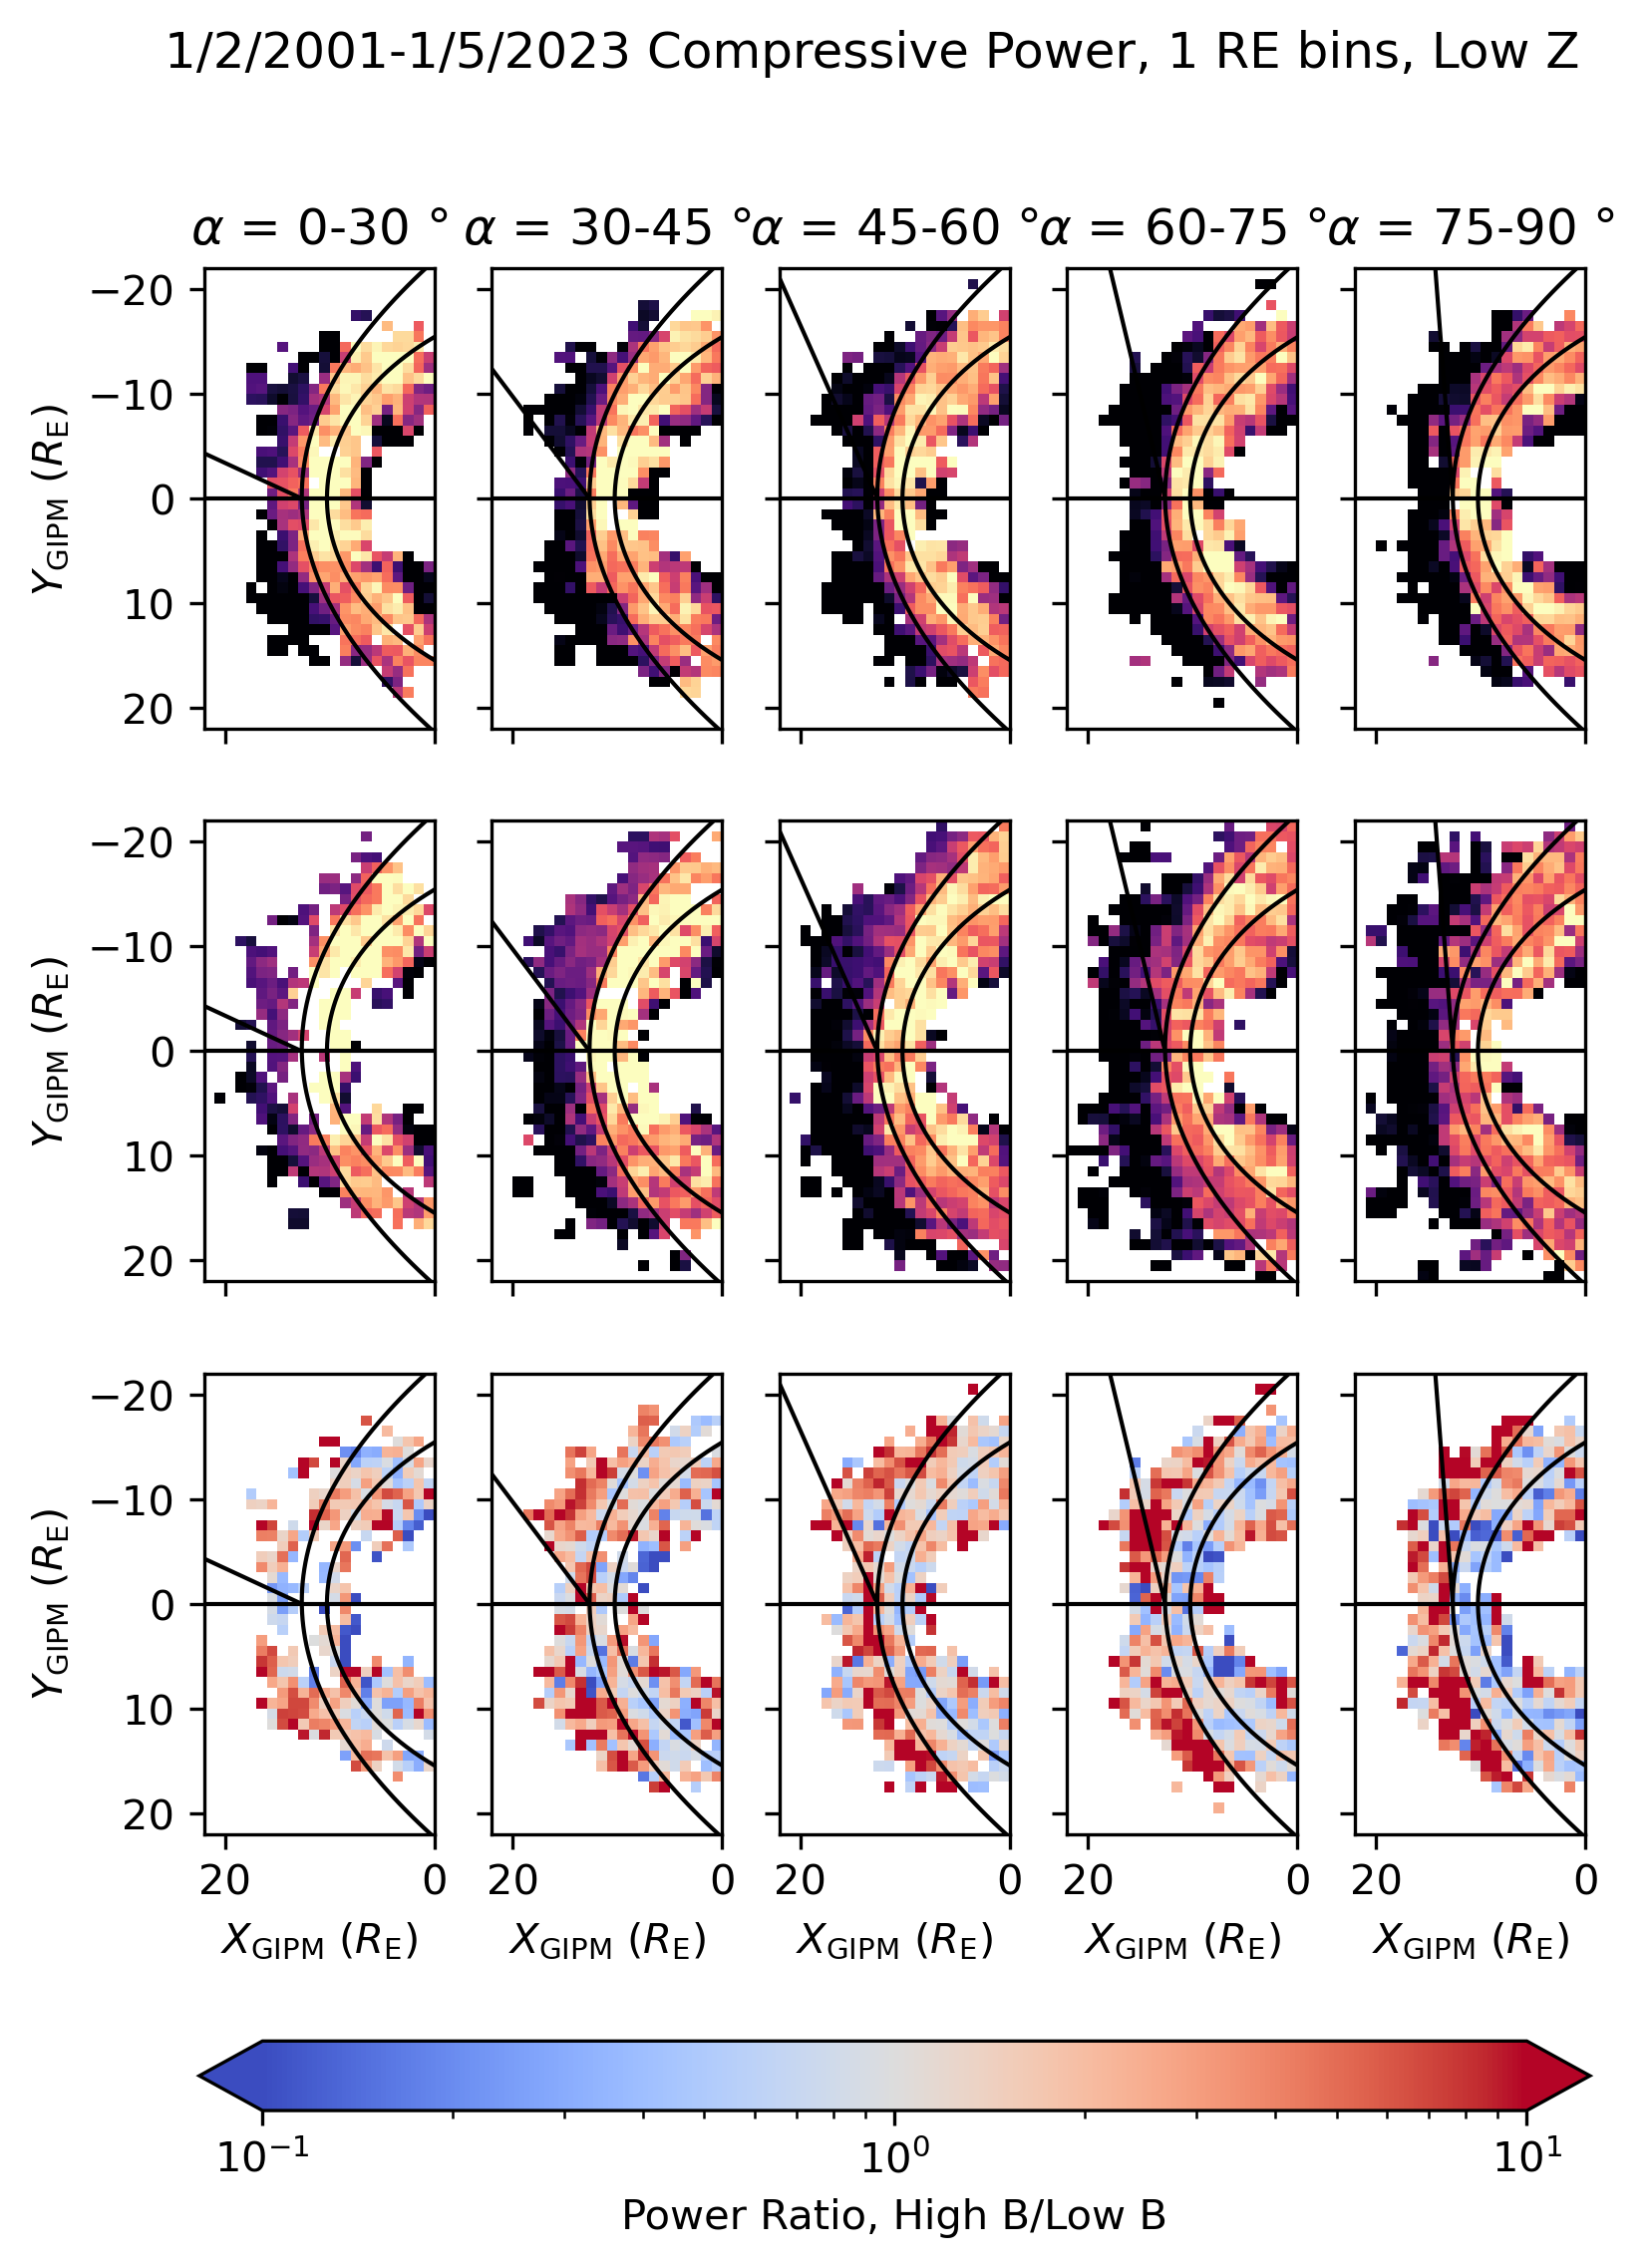

In [12]:
#plot w/ two rows of 5-10 and 10-15 and then the difference.

#now make the big plot with all the compressive components first

x = np.linspace(0, 20, 100) #x coordinates (Re)
y = np.linspace(-30, 30, 100) #y coordinates (Re)
z = 0 #z coordinates in Re

[Xgipm,Ygipm,Zgipm] = np.meshgrid(x,y,z,indexing="ij")

fitting_coeffs = merka05_surface_eq_array_GIPM(XMA_all)

Xn = Xgipm
Yn = Ygipm
Zn = Zgipm
f = fitting_coeffs[0]*Xn**2 + fitting_coeffs[1]*Yn**2 + fitting_coeffs[2]*Zn**2+ 2*fitting_coeffs[3]*Xn*Yn + 2*fitting_coeffs[4]*Yn*Zn + 2*fitting_coeffs[5]*Xn*Zn + 2*fitting_coeffs[6]*Xn+2*fitting_coeffs[7]*Yn + 2*fitting_coeffs[8]*Zn + fitting_coeffs[9]

x_1 = np.linspace(0, 20, 100) #x coordinates (Re)
y_1 = 0 #y coordinates (Re)
z_1 = np.linspace(-30, 30, 100) #z coordinates in Re

[Xgipm_1,Ygipm_1,Zgipm_1] = np.meshgrid(x_1,y_1,z_1,indexing="ij")
Xn_1 = Xgipm_1
Yn_1 = Ygipm_1
Zn_1 = Zgipm_1
f_1 = fitting_coeffs[0]*Xn_1**2 + fitting_coeffs[1]*Yn_1**2 + fitting_coeffs[2]*Zn_1**2+ 2*fitting_coeffs[3]*Xn_1*Yn_1 + 2*fitting_coeffs[4]*Yn_1*Zn_1 + 2*fitting_coeffs[5]*Xn_1*Zn_1 + 2*fitting_coeffs[6]*Xn_1+2*fitting_coeffs[7]*Yn_1 + 2*fitting_coeffs[8]*Zn_1 + fitting_coeffs[9]

#magnetopause model, D = 2 nPa

m_1 = 10.22
m_2 = 1.29
m_3 = 0.184
m_4 = 8.14
m_5 = 6.6
m_6 = 0.58
m_7 = -0.007
m_8 = 0.024

#use B_z =0
B_z = 0
D_p = 2

alpha = (m_6 + m_7*B_z)*(1 +m_8*(np.log(D_p)))

tanh_angle = m_3*(B_z+m_4)
r_0 = (m_1 + m_2*np.tanh(tanh_angle))*(D_p**(-1/m_5))

pi = np.pi

theta = np.arange(-pi/2, pi/2, 0.01)

r_mod = (2/(1+np.cos(theta)))**alpha
r = r_0*r_mod

X_shue = r*(np.cos(theta))
R_shue = r*(np.sin(theta))

###################
fig, ax = plt.subplots(figsize=(6, 8), dpi=300)
subfigs = fig.subfigures(1, 1)
axsLeft = subfigs.subplots(3, 5, sharey=True, sharex=True)
subfigs.suptitle('1/2/2001-1/5/2023 Compressive Power, 1 RE bins, Low Z')

#cmap norm

norm = colors.LogNorm(0.1, 10)
norm_plasma = colors.LogNorm(0.1, 10)

#cmap mesh

bin_size = 1
x_mesh = np.arange(0, 25, bin_size) 
y_mesh = np.arange(-26, 26, bin_size)
x_bin_ticks = int(25/bin_size)
y_bin_ticks = int(52/bin_size)

#ax0.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

#want to find three points on the bow shock surface, at y=0 and y=±8 and draw lines from there
#without exceeding current bounds of plot
inter_med = fitting_coeffs[6]**2 - (fitting_coeffs[0]*fitting_coeffs[9])
X_BS_nose = (-fitting_coeffs[6] + np.sqrt(inter_med))/fitting_coeffs[0]

x_s = X_BS_nose
y_s = 0
x_e = 30

tan_angle_0 = np.tan(np.deg2rad(15))
y_e_0 = -x_e*(tan_angle_0)

ax1 = axsLeft[0,0]

ax1.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax1.plot(X_shue, R_shue, linewidth=1, color='k')

col_array_1 = np.array(mean_para_rad_lowB)
color_grid_1 = col_array_1.reshape(x_bin_ticks, y_bin_ticks)
color_grid_1 = np.rot90(color_grid_1)
color_grid_1 = np.flipud(color_grid_1)

ax1.set_aspect('equal')
#ax1.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax1.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax1.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax1.pcolormesh(x_mesh, y_mesh, color_grid_1[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax1.plot([x_s, x_e], [y_s, y_e_0], color='k',linewidth=1)
ax1.set_ylim(-22,22)
ax1.set_xlim(0,22)
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax1.set_title(r'$\alpha$ = 0-30 $\degree$')
cbar_title = r'Power Ratio, High B/Low B'
fig.colorbar(cm.ScalarMappable(norm=norm, cmap='coolwarm'),location='bottom',anchor=(0.5, 0), panchor=(0.5, 0.2), pad =0, ax=axsLeft, extend='both', label=cbar_title)


ax2 = axsLeft[1,0]

col_array_2 = np.array(mean_para_rad_highB)
color_grid_2 = col_array_2.reshape(x_bin_ticks, y_bin_ticks)
color_grid_2 = np.rot90(color_grid_2)
color_grid_2 = np.flipud(color_grid_2)

ax2.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax2.plot(X_shue, R_shue, linewidth=1, color='k')

ax2.set_aspect('equal')
#ax2.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax2.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


ax2.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax2.pcolormesh(x_mesh, y_mesh, color_grid_2[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax2.plot([x_s, x_e], [y_s, y_e_0], color='k',linewidth=1)
ax2.set_ylim(-22,22)
ax2.set_xlim(0,22)
ax2.invert_xaxis()
ax2.invert_yaxis()

ax3 = axsLeft[2,0]

ax3.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax3.plot(X_shue, R_shue, linewidth=1, color='k')

col_array_3 = para_ratio_rad_lowB_highB
color_grid_3 = col_array_3.reshape(x_bin_ticks, y_bin_ticks)
color_grid_3 = np.rot90(color_grid_3)
color_grid_3 = np.flipud(color_grid_3)

ax3.set_aspect('equal')
#ax3.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax3.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

ax3.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax3.pcolormesh(x_mesh, y_mesh, color_grid_3[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax3.plot([x_s, x_e], [y_s, y_e_0], color='k',linewidth=1)
ax3.set_ylim(-22,22)
ax3.set_xlim(0,22)
ax3.invert_xaxis()
ax3.invert_yaxis()
ax3.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

###########LOW SPIRAL############################

tan_angle_lowspir = np.tan(np.deg2rad(37.5))
y_e_lowspir = -x_e*(tan_angle_lowspir)

ax5 = axsLeft[0,1]

ax5.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax5.plot(X_shue, R_shue, linewidth=1, color='k')
ax5.set_aspect('equal')
#a5.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax5.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_5 = np.array(mean_para_lowspir_lowB)
color_grid_5 = col_array_5.reshape(x_bin_ticks, y_bin_ticks)
color_grid_5 = np.rot90(color_grid_5)
color_grid_5 = np.flipud(color_grid_5)

ax5.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax5.pcolormesh(x_mesh, y_mesh, color_grid_5[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax5.plot([x_s, x_e], [y_s, y_e_lowspir], color='k',linewidth=1)
ax5.set_ylim(-22,22)
ax5.set_xlim(0,22)
ax5.invert_xaxis()
ax5.invert_yaxis()
ax5.set_title(r'$\alpha$ = 30-45 $\degree$')

ax6 = axsLeft[1,1]

ax6.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax6.plot(X_shue, R_shue, linewidth=1, color='k')
ax6.set_aspect('equal')
#ax6.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax6.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_6 = np.array(mean_para_lowspir_highB)
color_grid_6 = col_array_6.reshape(x_bin_ticks, y_bin_ticks)
color_grid_6 = np.rot90(color_grid_6)
color_grid_6 = np.flipud(color_grid_6)

ax6.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax6.pcolormesh(x_mesh, y_mesh, color_grid_6[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax6.plot([x_s, x_e], [y_s, y_e_lowspir], color='k',linewidth=1)
ax6.set_ylim(-22,22)
ax6.set_xlim(0,22)
ax6.invert_xaxis()
ax6.invert_yaxis()

ax7 = axsLeft[2,1]

ax7.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax7.plot(X_shue, R_shue, linewidth=1, color='k')
ax7.set_aspect('equal')
#ax7.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax7.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_7 = para_ratio_lowspir_lowB_highB
color_grid_7 = col_array_7.reshape(x_bin_ticks, y_bin_ticks)
color_grid_7 = np.rot90(color_grid_7)
color_grid_7 = np.flipud(color_grid_7)

ax7.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax7.pcolormesh(x_mesh, y_mesh, color_grid_7[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax7.plot([x_s, x_e], [y_s, y_e_lowspir], color='k',linewidth=1)
ax7.set_ylim(-22,22)
ax7.set_xlim(0,22)
ax7.invert_xaxis()
ax7.invert_yaxis()
ax7.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

###########HIGH SPIRAL############################

tan_angle_highspir = np.tan(np.deg2rad(52.5))
y_e_highspir = -x_e*(tan_angle_highspir)

#ax8.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax8.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

ax9 = axsLeft[0,2]

ax9.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax9.plot(X_shue, R_shue, linewidth=1, color='k')
ax9.set_aspect('equal')
#ax9.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax9.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_9 = np.array(mean_para_highspir_lowB)
color_grid_9 = col_array_9.reshape(x_bin_ticks, y_bin_ticks)
color_grid_9 = np.rot90(color_grid_9)
color_grid_9 = np.flipud(color_grid_9)

ax9.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax9.pcolormesh(x_mesh, y_mesh, color_grid_9[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax9.plot([x_s, x_e], [y_s, y_e_highspir], color='k',linewidth=1)
ax9.set_ylim(-22,22)
ax9.set_xlim(0,22)
ax9.invert_xaxis()
ax9.invert_yaxis()
ax9.set_title(r'$\alpha$ = 45-60 $\degree$')

ax10 = axsLeft[1,2]

ax10.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax10.plot(X_shue, R_shue, linewidth=1, color='k')
ax10.set_aspect('equal')
#ax10.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax10.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_10 = np.array(mean_para_highspir_highB)
color_grid_10 = col_array_10.reshape(x_bin_ticks, y_bin_ticks)
color_grid_10 = np.rot90(color_grid_10)
color_grid_10 = np.flipud(color_grid_10)

ax10.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax10.pcolormesh(x_mesh, y_mesh, color_grid_10[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax10.plot([x_s, x_e], [y_s, y_e_highspir], color='k',linewidth=1)
ax10.set_ylim(-22,22)
ax10.set_xlim(0,22)
ax10.invert_xaxis()
ax10.invert_yaxis()

ax11 = axsLeft[2,2]

ax11.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax11.plot(X_shue, R_shue, linewidth=1, color='k')
ax11.set_aspect('equal')
#ax11.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax11.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_11 = para_ratio_highspir_lowB_highB
color_grid_11 = col_array_11.reshape(x_bin_ticks, y_bin_ticks)
color_grid_11 = np.rot90(color_grid_11)
color_grid_11 = np.flipud(color_grid_11)

ax11.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax11.pcolormesh(x_mesh, y_mesh, color_grid_11[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax11.plot([x_s, x_e], [y_s, y_e_highspir], color='k',linewidth=1)
ax11.set_ylim(-22,22)
ax11.set_xlim(0,22)
ax11.invert_xaxis()
ax11.invert_yaxis()
ax11.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


######LOW PERPENDICULAR

tan_angle_lowperp = np.tan(np.deg2rad(67.5))
y_e_lowperp = -x_e*(tan_angle_lowperp)

ax13 = axsLeft[0,3]

ax13.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax13.plot(X_shue, R_shue, linewidth=1, color='k')
ax13.set_aspect('equal')
ax13.set_title(r'$\alpha$ = 60-75 $\degree$')
#ax13.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax13.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

col_array_13 = np.array(mean_para_lowperp_lowB)
color_grid_13 = col_array_13.reshape(x_bin_ticks, y_bin_ticks)
color_grid_13 = np.rot90(color_grid_13)
color_grid_13 = np.flipud(color_grid_13)

ax13.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax13.pcolormesh(x_mesh, y_mesh, color_grid_13[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax13.plot([x_s, x_e], [y_s, y_e_lowperp], color='k',linewidth=1)
ax13.set_ylim(-22,22)
ax13.set_xlim(0,22)
ax13.invert_xaxis()
ax13.invert_yaxis()

ax14 = axsLeft[1,3]

ax14.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax14.plot(X_shue, R_shue, linewidth=1, color='k')
ax14.set_aspect('equal')
#ax14.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax14.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

col_array_14 = np.array(mean_para_lowperp_highB)
color_grid_14 = col_array_14.reshape(x_bin_ticks, y_bin_ticks)
color_grid_14 = np.rot90(color_grid_14)
color_grid_14 = np.flipud(color_grid_14)

ax14.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax14.pcolormesh(x_mesh, y_mesh, color_grid_14[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax14.plot([x_s, x_e], [y_s, y_e_lowperp], color='k',linewidth=1)
ax14.set_ylim(-22,22)
ax14.set_xlim(0,22)
ax14.invert_xaxis()
ax14.invert_yaxis()

ax15 = axsLeft[2,3]

ax15.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax15.plot(X_shue, R_shue, linewidth=1, color='k')
ax15.set_aspect('equal')
#ax15.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax15.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_15 = para_ratio_lowperp_lowB_highB
color_grid_15 = col_array_15.reshape(x_bin_ticks, y_bin_ticks)
color_grid_15 = np.rot90(color_grid_15)
color_grid_15 = np.flipud(color_grid_15)

ax15.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax15.pcolormesh(x_mesh, y_mesh, color_grid_15[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax15.plot([x_s, x_e], [y_s, y_e_lowperp], color='k',linewidth=1)
ax15.set_ylim(-22,22)
ax15.set_xlim(0,22)
ax15.invert_xaxis()
ax15.invert_yaxis()

ax15.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

######HIGH PERPENDICULAR

tan_angle_highperp = np.tan(np.deg2rad(82.5))
y_e_highperp = -x_e*(tan_angle_highperp)


ax17 = axsLeft[0,4]

ax17.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax17.plot(X_shue, R_shue, linewidth=1, color='k')
ax17.set_aspect('equal')

col_array_17 = np.array(mean_para_highperp_lowB)
color_grid_17 = col_array_17.reshape(x_bin_ticks, y_bin_ticks)
color_grid_17 = np.rot90(color_grid_17)
color_grid_17 = np.flipud(color_grid_17)

ax17.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax17.pcolormesh(x_mesh, y_mesh, color_grid_17[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax17.plot([x_s, x_e], [y_s, y_e_highperp], color='k',linewidth=1)
ax17.set_ylim(-22,22)
ax17.set_xlim(0,22)
ax17.set_title(r'$\alpha$ = 75-90 $\degree$')
ax17.invert_xaxis()
ax17.invert_yaxis()


ax18 = axsLeft[1,4]

ax18.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax18.plot(X_shue, R_shue, linewidth=1, color='k')
ax18.set_aspect('equal')

col_array_18 = np.array(mean_para_highperp_highB)
color_grid_18 = col_array_18.reshape(x_bin_ticks, y_bin_ticks)
color_grid_18 = np.rot90(color_grid_18)
color_grid_18 = np.flipud(color_grid_18)

ax18.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax18.pcolormesh(x_mesh, y_mesh, color_grid_18[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax18.plot([x_s, x_e], [y_s, y_e_highperp], color='k',linewidth=1)
ax18.set_ylim(-22,22)
ax18.set_xlim(0,22)
ax18.invert_xaxis()
ax18.invert_yaxis()

ax19 = axsLeft[2,4]

ax19.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax19.plot(X_shue, R_shue, linewidth=1, color='k')
ax19.set_aspect('equal')

col_array_19 = para_ratio_highperp_lowB_highB
color_grid_19 = col_array_19.reshape(x_bin_ticks, y_bin_ticks)
color_grid_19 = np.rot90(color_grid_19)
color_grid_19 = np.flipud(color_grid_19)

ax19.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax19.pcolormesh(x_mesh, y_mesh, color_grid_19[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax19.plot([x_s, x_e], [y_s, y_e_highperp], color='k',linewidth=1)
ax19.set_ylim(-22,22)
ax19.set_xlim(0,22)
ax19.invert_xaxis()
ax19.invert_yaxis()

ax19.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


Text(0.5, 0, '$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)')

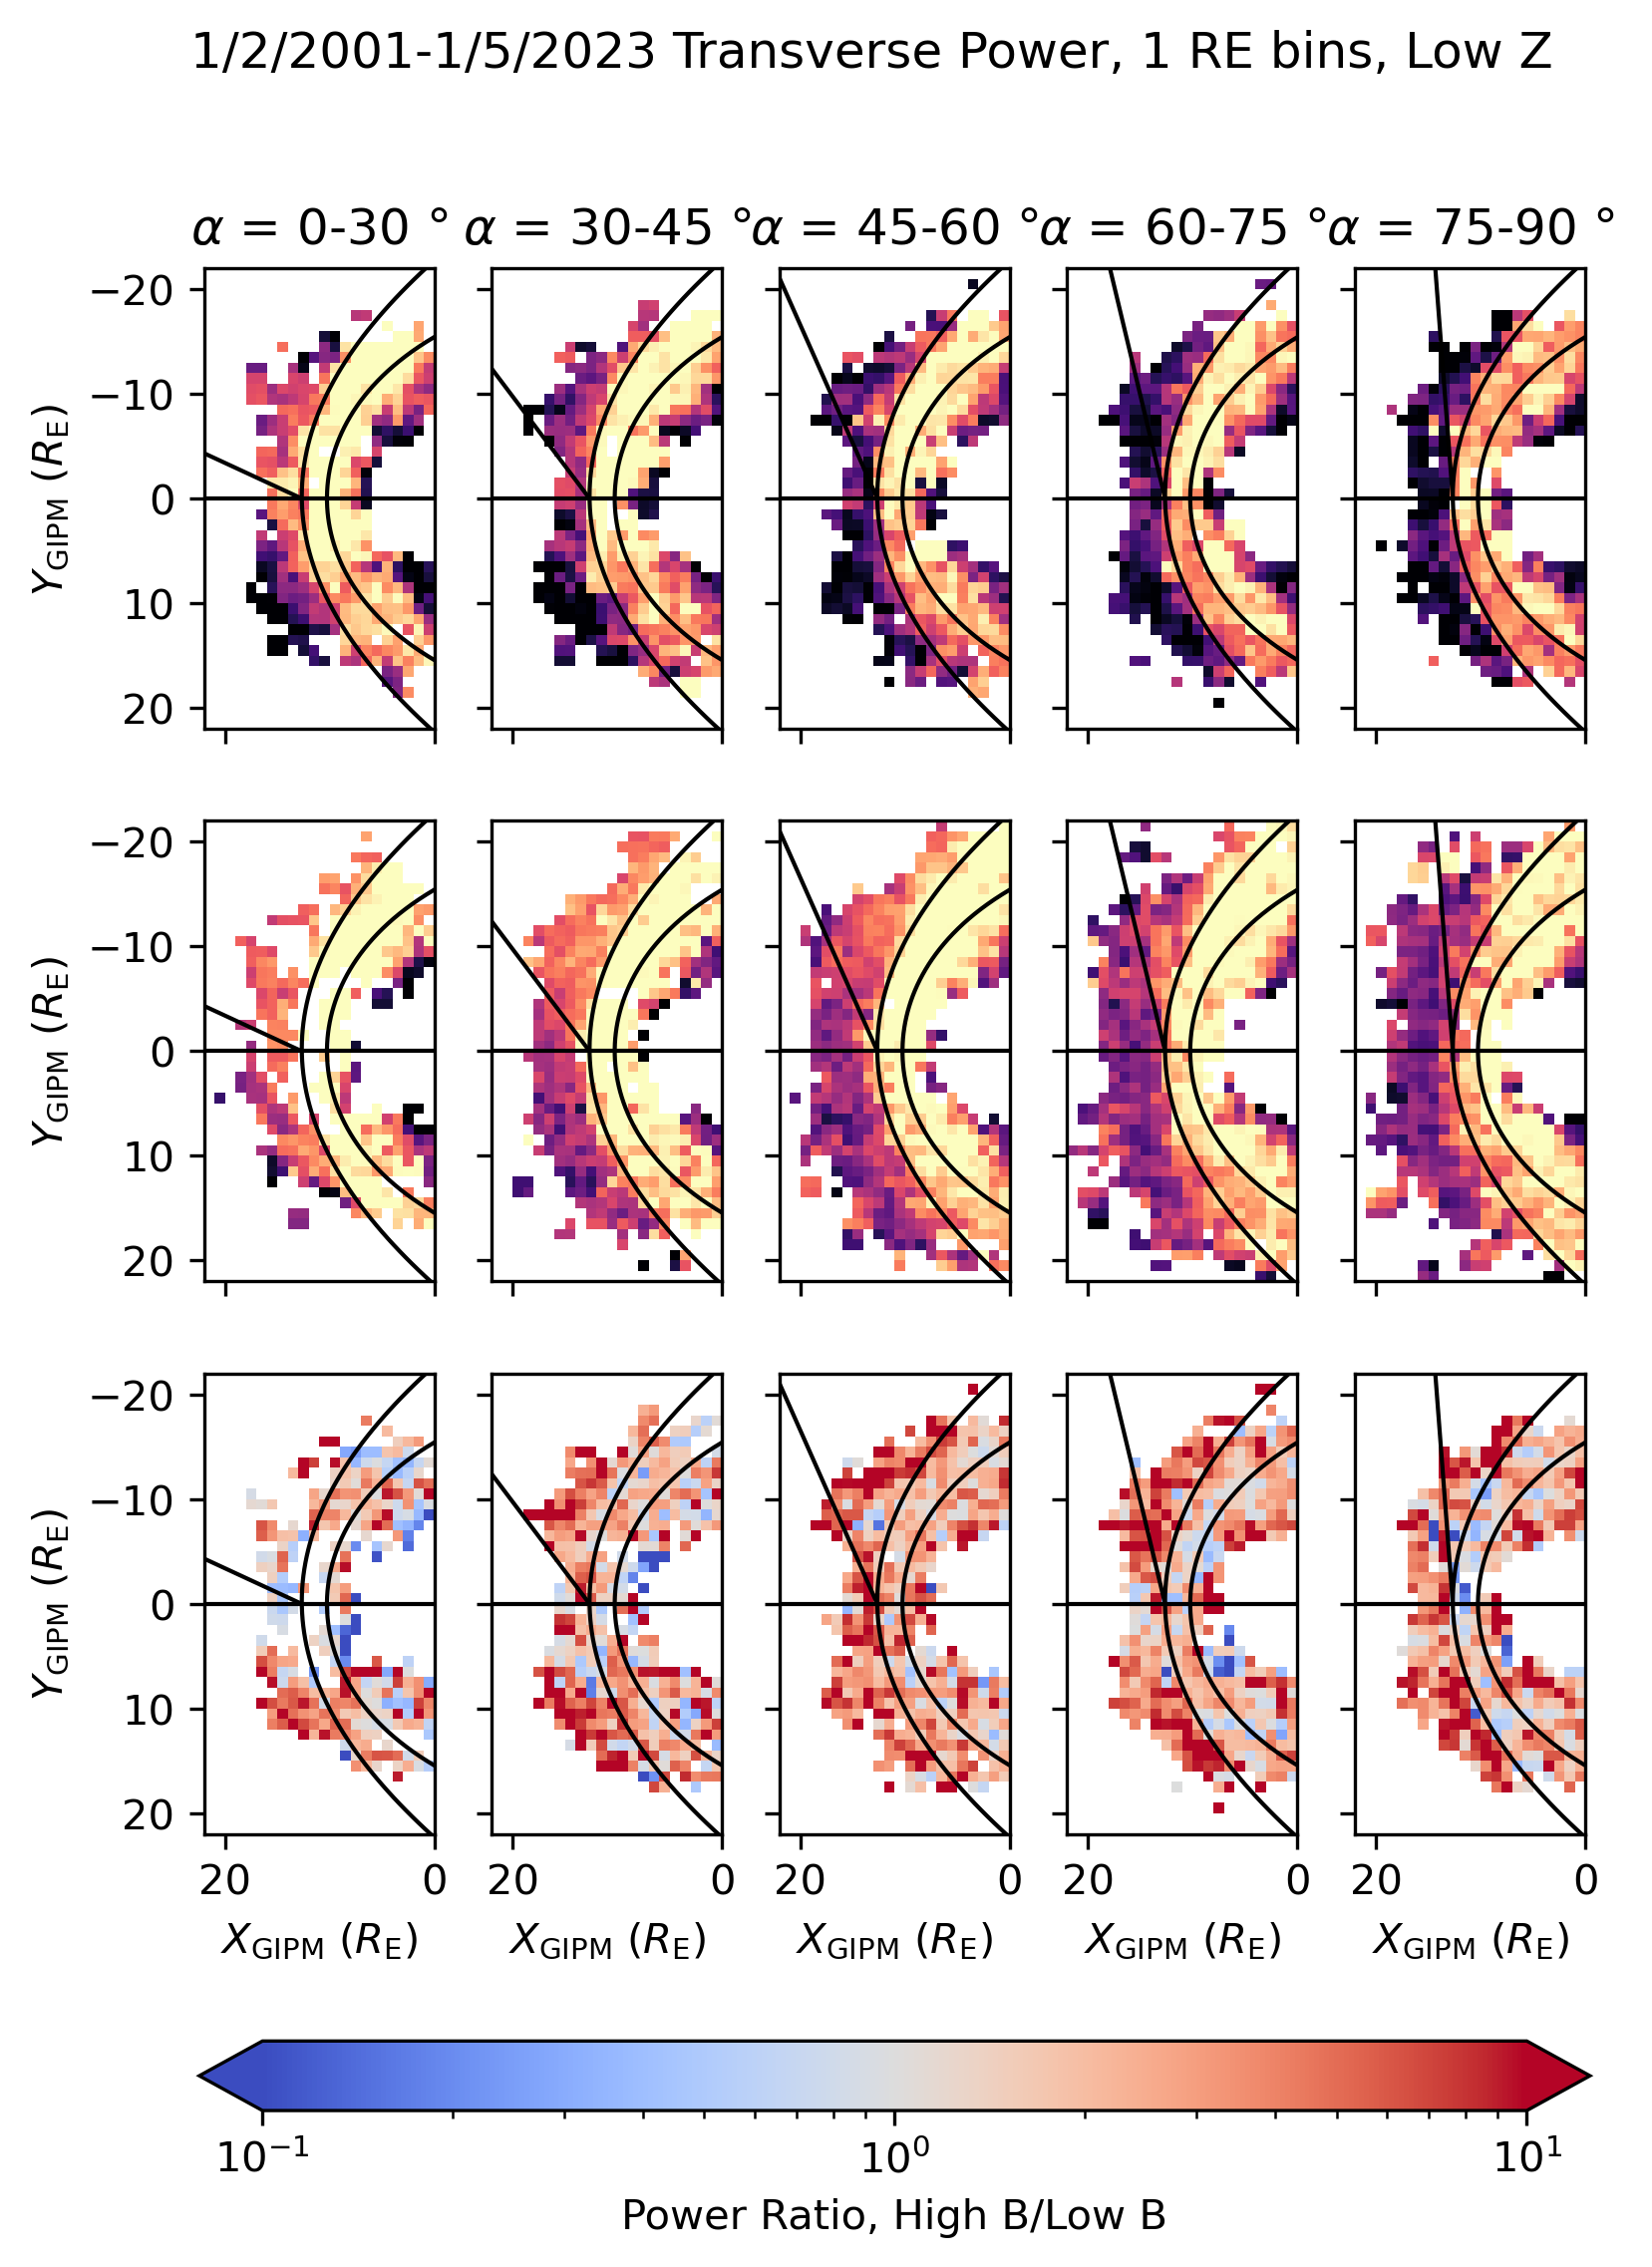

In [13]:
#plot w/ two rows of 5-10 and 10-15 and then the ratioerence.

#now make the big plot with all the transverse components first

x = np.linspace(0, 20, 100) #x coordinates (Re)
y = np.linspace(-30, 30, 100) #y coordinates (Re)
z = 0 #z coordinates in Re

[Xgipm,Ygipm,Zgipm] = np.meshgrid(x,y,z,indexing="ij")

fitting_coeffs = merka05_surface_eq_array_GIPM(XMA_all)

Xn = Xgipm
Yn = Ygipm
Zn = Zgipm
f = fitting_coeffs[0]*Xn**2 + fitting_coeffs[1]*Yn**2 + fitting_coeffs[2]*Zn**2+ 2*fitting_coeffs[3]*Xn*Yn + 2*fitting_coeffs[4]*Yn*Zn + 2*fitting_coeffs[5]*Xn*Zn + 2*fitting_coeffs[6]*Xn+2*fitting_coeffs[7]*Yn + 2*fitting_coeffs[8]*Zn + fitting_coeffs[9]

x_1 = np.linspace(0, 20, 100) #x coordinates (Re)
y_1 = 0 #y coordinates (Re)
z_1 = np.linspace(-30, 30, 100) #z coordinates in Re

[Xgipm_1,Ygipm_1,Zgipm_1] = np.meshgrid(x_1,y_1,z_1,indexing="ij")
Xn_1 = Xgipm_1
Yn_1 = Ygipm_1
Zn_1 = Zgipm_1
f_1 = fitting_coeffs[0]*Xn_1**2 + fitting_coeffs[1]*Yn_1**2 + fitting_coeffs[2]*Zn_1**2+ 2*fitting_coeffs[3]*Xn_1*Yn_1 + 2*fitting_coeffs[4]*Yn_1*Zn_1 + 2*fitting_coeffs[5]*Xn_1*Zn_1 + 2*fitting_coeffs[6]*Xn_1+2*fitting_coeffs[7]*Yn_1 + 2*fitting_coeffs[8]*Zn_1 + fitting_coeffs[9]

#magnetopause model, D = 2 nPa

m_1 = 10.22
m_2 = 1.29
m_3 = 0.184
m_4 = 8.14
m_5 = 6.6
m_6 = 0.58
m_7 = -0.007
m_8 = 0.024

#use B_z =0
B_z = 0
D_p = 2

alpha = (m_6 + m_7*B_z)*(1 +m_8*(np.log(D_p)))

tanh_angle = m_3*(B_z+m_4)
r_0 = (m_1 + m_2*np.tanh(tanh_angle))*(D_p**(-1/m_5))

pi = np.pi

theta = np.arange(-pi/2, pi/2, 0.01)

r_mod = (2/(1+np.cos(theta)))**alpha
r = r_0*r_mod

X_shue = r*(np.cos(theta))
R_shue = r*(np.sin(theta))

###################
fig, ax = plt.subplots(figsize=(6, 8), dpi=300)
subfigs = fig.subfigures(1, 1)
axsLeft = subfigs.subplots(3, 5, sharey=True, sharex=True)
subfigs.suptitle('1/2/2001-1/5/2023 Transverse Power, 1 RE bins, Low Z')

#cmap norm

norm = colors.LogNorm(0.1, 10)
norm_plasma = colors.LogNorm(0.1, 10)

#cmap mesh

bin_size = 1
x_mesh = np.arange(0, 25, bin_size) 
y_mesh = np.arange(-26, 26, bin_size)
x_bin_ticks = int(25/bin_size)
y_bin_ticks = int(52/bin_size)

#ax0.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

#want to find three points on the bow shock surface, at y=0 and y=±8 and draw lines from there
#without exceeding current bounds of plot
inter_med = fitting_coeffs[6]**2 - (fitting_coeffs[0]*fitting_coeffs[9])
X_BS_nose = (-fitting_coeffs[6] + np.sqrt(inter_med))/fitting_coeffs[0]

x_s = X_BS_nose
y_s = 0
x_e = 30

tan_angle_0 = np.tan(np.deg2rad(15))
y_e_0 = -x_e*(tan_angle_0)

ax1 = axsLeft[0,0]

ax1.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax1.plot(X_shue, R_shue, linewidth=1, color='k')

col_array_1 = np.array(mean_perp_rad_lowB)
color_grid_1 = col_array_1.reshape(x_bin_ticks, y_bin_ticks)
color_grid_1 = np.rot90(color_grid_1)
color_grid_1 = np.flipud(color_grid_1)

ax1.set_aspect('equal')
#ax1.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax1.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax1.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax1.pcolormesh(x_mesh, y_mesh, color_grid_1[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax1.plot([x_s, x_e], [y_s, y_e_0], color='k',linewidth=1)
ax1.set_ylim(-22,22)
ax1.set_xlim(0,22)
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax1.set_title(r'$\alpha$ = 0-30 $\degree$')
cbar_title = r'Power Ratio, High B/Low B'
fig.colorbar(cm.ScalarMappable(norm=norm, cmap='coolwarm'),location='bottom',anchor=(0.5, 0), panchor=(0.5, 0.2), pad =0, ax=axsLeft, extend='both', label=cbar_title)


ax2 = axsLeft[1,0]

col_array_2 = np.array(mean_perp_rad_highB)
color_grid_2 = col_array_2.reshape(x_bin_ticks, y_bin_ticks)
color_grid_2 = np.rot90(color_grid_2)
color_grid_2 = np.flipud(color_grid_2)

ax2.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax2.plot(X_shue, R_shue, linewidth=1, color='k')

ax2.set_aspect('equal')
#ax2.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax2.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


ax2.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax2.pcolormesh(x_mesh, y_mesh, color_grid_2[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax2.plot([x_s, x_e], [y_s, y_e_0], color='k',linewidth=1)
ax2.set_ylim(-22,22)
ax2.set_xlim(0,22)
ax2.invert_xaxis()
ax2.invert_yaxis()

ax3 = axsLeft[2,0]

ax3.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax3.plot(X_shue, R_shue, linewidth=1, color='k')

col_array_3 = perp_ratio_rad_lowB_highB
color_grid_3 = col_array_3.reshape(x_bin_ticks, y_bin_ticks)
color_grid_3 = np.rot90(color_grid_3)
color_grid_3 = np.flipud(color_grid_3)

ax3.set_aspect('equal')
#ax3.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax3.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

ax3.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax3.pcolormesh(x_mesh, y_mesh, color_grid_3[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax3.plot([x_s, x_e], [y_s, y_e_0], color='k',linewidth=1)
ax3.set_ylim(-22,22)
ax3.set_xlim(0,22)
ax3.invert_xaxis()
ax3.invert_yaxis()
ax3.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

###########LOW SPIRAL############################

tan_angle_lowspir = np.tan(np.deg2rad(37.5))
y_e_lowspir = -x_e*(tan_angle_lowspir)

ax5 = axsLeft[0,1]

ax5.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax5.plot(X_shue, R_shue, linewidth=1, color='k')
ax5.set_aspect('equal')
#a5.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax5.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_5 = np.array(mean_perp_lowspir_lowB)
color_grid_5 = col_array_5.reshape(x_bin_ticks, y_bin_ticks)
color_grid_5 = np.rot90(color_grid_5)
color_grid_5 = np.flipud(color_grid_5)

ax5.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax5.pcolormesh(x_mesh, y_mesh, color_grid_5[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax5.plot([x_s, x_e], [y_s, y_e_lowspir], color='k',linewidth=1)
ax5.set_ylim(-22,22)
ax5.set_xlim(0,22)
ax5.invert_xaxis()
ax5.invert_yaxis()
ax5.set_title(r'$\alpha$ = 30-45 $\degree$')

ax6 = axsLeft[1,1]

ax6.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax6.plot(X_shue, R_shue, linewidth=1, color='k')
ax6.set_aspect('equal')
#ax6.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax6.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_6 = np.array(mean_perp_lowspir_highB)
color_grid_6 = col_array_6.reshape(x_bin_ticks, y_bin_ticks)
color_grid_6 = np.rot90(color_grid_6)
color_grid_6 = np.flipud(color_grid_6)

ax6.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax6.pcolormesh(x_mesh, y_mesh, color_grid_6[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax6.plot([x_s, x_e], [y_s, y_e_lowspir], color='k',linewidth=1)
ax6.set_ylim(-22,22)
ax6.set_xlim(0,22)
ax6.invert_xaxis()
ax6.invert_yaxis()

ax7 = axsLeft[2,1]

ax7.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax7.plot(X_shue, R_shue, linewidth=1, color='k')
ax7.set_aspect('equal')
#ax7.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax7.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_7 = perp_ratio_lowspir_lowB_highB
color_grid_7 = col_array_7.reshape(x_bin_ticks, y_bin_ticks)
color_grid_7 = np.rot90(color_grid_7)
color_grid_7 = np.flipud(color_grid_7)

ax7.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax7.pcolormesh(x_mesh, y_mesh, color_grid_7[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax7.plot([x_s, x_e], [y_s, y_e_lowspir], color='k',linewidth=1)
ax7.set_ylim(-22,22)
ax7.set_xlim(0,22)
ax7.invert_xaxis()
ax7.invert_yaxis()
ax7.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

###########HIGH SPIRAL############################

tan_angle_highspir = np.tan(np.deg2rad(52.5))
y_e_highspir = -x_e*(tan_angle_highspir)

#ax8.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax8.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

ax9 = axsLeft[0,2]

ax9.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax9.plot(X_shue, R_shue, linewidth=1, color='k')
ax9.set_aspect('equal')
#ax9.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax9.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_9 = np.array(mean_perp_highspir_lowB)
color_grid_9 = col_array_9.reshape(x_bin_ticks, y_bin_ticks)
color_grid_9 = np.rot90(color_grid_9)
color_grid_9 = np.flipud(color_grid_9)

ax9.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax9.pcolormesh(x_mesh, y_mesh, color_grid_9[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax9.plot([x_s, x_e], [y_s, y_e_highspir], color='k',linewidth=1)
ax9.set_ylim(-22,22)
ax9.set_xlim(0,22)
ax9.invert_xaxis()
ax9.invert_yaxis()
ax9.set_title(r'$\alpha$ = 45-60 $\degree$')

ax10 = axsLeft[1,2]

ax10.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax10.plot(X_shue, R_shue, linewidth=1, color='k')
ax10.set_aspect('equal')
#ax10.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax10.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_10 = np.array(mean_perp_highspir_highB)
color_grid_10 = col_array_10.reshape(x_bin_ticks, y_bin_ticks)
color_grid_10 = np.rot90(color_grid_10)
color_grid_10 = np.flipud(color_grid_10)

ax10.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax10.pcolormesh(x_mesh, y_mesh, color_grid_10[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax10.plot([x_s, x_e], [y_s, y_e_highspir], color='k',linewidth=1)
ax10.set_ylim(-22,22)
ax10.set_xlim(0,22)
ax10.invert_xaxis()
ax10.invert_yaxis()

ax11 = axsLeft[2,2]

ax11.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax11.plot(X_shue, R_shue, linewidth=1, color='k')
ax11.set_aspect('equal')
#ax11.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax11.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_11 = perp_ratio_highspir_lowB_highB
color_grid_11 = col_array_11.reshape(x_bin_ticks, y_bin_ticks)
color_grid_11 = np.rot90(color_grid_11)
color_grid_11 = np.flipud(color_grid_11)

ax11.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax11.pcolormesh(x_mesh, y_mesh, color_grid_11[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax11.plot([x_s, x_e], [y_s, y_e_highspir], color='k',linewidth=1)
ax11.set_ylim(-22,22)
ax11.set_xlim(0,22)
ax11.invert_xaxis()
ax11.invert_yaxis()
ax11.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


######LOW PERPENDICULAR

tan_angle_lowperp = np.tan(np.deg2rad(67.5))
y_e_lowperp = -x_e*(tan_angle_lowperp)

ax13 = axsLeft[0,3]

ax13.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax13.plot(X_shue, R_shue, linewidth=1, color='k')
ax13.set_aspect('equal')
ax13.set_title(r'$\alpha$ = 60-75 $\degree$')
#ax13.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax13.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

col_array_13 = np.array(mean_perp_lowperp_lowB)
color_grid_13 = col_array_13.reshape(x_bin_ticks, y_bin_ticks)
color_grid_13 = np.rot90(color_grid_13)
color_grid_13 = np.flipud(color_grid_13)

ax13.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax13.pcolormesh(x_mesh, y_mesh, color_grid_13[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax13.plot([x_s, x_e], [y_s, y_e_lowperp], color='k',linewidth=1)
ax13.set_ylim(-22,22)
ax13.set_xlim(0,22)
ax13.invert_xaxis()
ax13.invert_yaxis()

ax14 = axsLeft[1,3]

ax14.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax14.plot(X_shue, R_shue, linewidth=1, color='k')
ax14.set_aspect('equal')
#ax14.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax14.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

col_array_14 = np.array(mean_perp_lowperp_highB)
color_grid_14 = col_array_14.reshape(x_bin_ticks, y_bin_ticks)
color_grid_14 = np.rot90(color_grid_14)
color_grid_14 = np.flipud(color_grid_14)

ax14.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax14.pcolormesh(x_mesh, y_mesh, color_grid_14[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax14.plot([x_s, x_e], [y_s, y_e_lowperp], color='k',linewidth=1)
ax14.set_ylim(-22,22)
ax14.set_xlim(0,22)
ax14.invert_xaxis()
ax14.invert_yaxis()

ax15 = axsLeft[2,3]

ax15.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax15.plot(X_shue, R_shue, linewidth=1, color='k')
ax15.set_aspect('equal')
#ax15.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax15.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_15 = perp_ratio_lowperp_lowB_highB
color_grid_15 = col_array_15.reshape(x_bin_ticks, y_bin_ticks)
color_grid_15 = np.rot90(color_grid_15)
color_grid_15 = np.flipud(color_grid_15)

ax15.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax15.pcolormesh(x_mesh, y_mesh, color_grid_15[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax15.plot([x_s, x_e], [y_s, y_e_lowperp], color='k',linewidth=1)
ax15.set_ylim(-22,22)
ax15.set_xlim(0,22)
ax15.invert_xaxis()
ax15.invert_yaxis()

ax15.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

######HIGH PERPENDICULAR

tan_angle_highperp = np.tan(np.deg2rad(82.5))
y_e_highperp = -x_e*(tan_angle_highperp)


ax17 = axsLeft[0,4]

ax17.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax17.plot(X_shue, R_shue, linewidth=1, color='k')
ax17.set_aspect('equal')

col_array_17 = np.array(mean_perp_highperp_lowB)
color_grid_17 = col_array_17.reshape(x_bin_ticks, y_bin_ticks)
color_grid_17 = np.rot90(color_grid_17)
color_grid_17 = np.flipud(color_grid_17)

ax17.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax17.pcolormesh(x_mesh, y_mesh, color_grid_17[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax17.plot([x_s, x_e], [y_s, y_e_highperp], color='k',linewidth=1)
ax17.set_ylim(-22,22)
ax17.set_xlim(0,22)
ax17.set_title(r'$\alpha$ = 75-90 $\degree$')
ax17.invert_xaxis()
ax17.invert_yaxis()


ax18 = axsLeft[1,4]

ax18.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax18.plot(X_shue, R_shue, linewidth=1, color='k')
ax18.set_aspect('equal')

col_array_18 = np.array(mean_perp_highperp_highB)
color_grid_18 = col_array_18.reshape(x_bin_ticks, y_bin_ticks)
color_grid_18 = np.rot90(color_grid_18)
color_grid_18 = np.flipud(color_grid_18)

ax18.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax18.pcolormesh(x_mesh, y_mesh, color_grid_18[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax18.plot([x_s, x_e], [y_s, y_e_highperp], color='k',linewidth=1)
ax18.set_ylim(-22,22)
ax18.set_xlim(0,22)
ax18.invert_xaxis()
ax18.invert_yaxis()

ax19 = axsLeft[2,4]

ax19.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax19.plot(X_shue, R_shue, linewidth=1, color='k')
ax19.set_aspect('equal')

col_array_19 = perp_ratio_highperp_lowB_highB
color_grid_19 = col_array_19.reshape(x_bin_ticks, y_bin_ticks)
color_grid_19 = np.rot90(color_grid_19)
color_grid_19 = np.flipud(color_grid_19)

ax19.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax19.pcolormesh(x_mesh, y_mesh, color_grid_19[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax19.plot([x_s, x_e], [y_s, y_e_highperp], color='k',linewidth=1)
ax19.set_ylim(-22,22)
ax19.set_xlim(0,22)
ax19.invert_xaxis()
ax19.invert_yaxis()

ax19.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


In [14]:
#now produce a binned plot of integrated power!first split into bins and then plot
#changed to do mean of ratios not ratio of means

def binning_normB_fourier_no_bad_stats(cluster_df):
    
    #first mask out datapoints so only those within -5<Z<5 Re are left
    
    cluster_df_XY = cluster_df.loc[(cluster_df['GIPM Z']> -5) & (cluster_df['GIPM Z'] < 5)]

    #break up into X strips between 0 and 25 in increments of 0.5 Re
    #probably want to do this using lists
    #or maybe window start times??
    bin_size = 1
    n = 25/bin_size
    n = int(n)
    lists = [[] for _ in range(n)]
    X_lim = 1
    
    for i in lists:
        #X lower bound
        X_lb = X_lim - bin_size
        #find all date times where X is within current bounds
        mask = cluster_df_XY.loc[(cluster_df_XY['GIPM X']>= X_lb) & (cluster_df_XY['GIPM X'] < X_lim)]
        windows = mask.index
        #and append to that list
        i.extend(windows)
        #increment X limit
        X_lim = X_lim + bin_size
    
    #now have lists of each timestamp associated with binsize Re width X bands
    #separate into binsize XY boxes

    n = (52/bin_size) * (25/bin_size)
    n = int(n)
    bin_lists = [[] for _ in range(n)]
    row_counter = 1

    #work by X row. i is one row, i.e. one list! of date times
    for i in lists:
        #set starting Y lim
        Y_lim = -25
        #mask df to just those times that are in i:
        mask = cluster_df_XY.loc[cluster_df_XY.index.isin(i)]
    
        y_bins_lower = (52/bin_size)*(row_counter-1)
        y_bins_lower = int(y_bins_lower)
        y_bins = (52/bin_size)*row_counter
        y_bins = int(y_bins)
        
        #now separate by Y bin NEED TO CHANGE Y BIN LIMS
        for j in range(y_bins_lower, y_bins): 
            Y_lb = Y_lim - bin_size
            mask_2 = mask.loc[(mask['GIPM Y']>= Y_lb) & (mask['GIPM Y'] < Y_lim)]
            windows = mask_2.index
            #and append to that list
            bin_lists[j].extend(windows)
            #increment X limit
            Y_lim = Y_lim + bin_size
        
        row_counter = row_counter + 1
    
    #new list of bin values
    #now for each list in bin_lists, find associated mean cluster B ratio
    #and extend new lists

    mean_para_perbin = []
    mean_perp_perbin = []
    para_perp_ratio_perbin = []
    
    for j in bin_lists:
        #intermediate list for taking mean
        int_list_para = []
        int_list_perp = []
        
        #filter cluster database for just the times included in the binlist
        for m in j:
            mask = cluster_df_XY.loc[cluster_df_XY.index== m]
            para_power = mask['Integrated Parallel Power']
            background_B = mask['B mean']
            norm_para_power = para_power/(background_B**2)
            int_list_para.extend(norm_para_power)
            perp_power = mask['Integrated Perpendicular Power']
            norm_perp_power = perp_power/(background_B**2)
            int_list_perp.extend(norm_perp_power)
        
        if len(int_list_para) >= 100:
            mean_para = sum(int_list_para)/len(int_list_para)
            mean_para_perbin.append(mean_para)
            mean_perp = sum(int_list_perp)/len(int_list_perp)
            mean_perp_perbin.append(mean_perp)
            #para_perp = mean_para/mean_perp
            int_list_para_ar = np.array(int_list_para)
            int_list_perp_ar = np.array(int_list_perp)
            para_perp_ar = int_list_para_ar/int_list_perp_ar
            para_perp = np.mean(para_perp_ar)
            para_perp_ratio_perbin.append(para_perp)
            
            
        else:
            mean_para_perbin.append(np.nan)
            mean_perp_perbin.append(np.nan)
            para_perp_ratio_perbin.append(np.nan)
        
    return(mean_para_perbin,mean_perp_perbin,para_perp_ratio_perbin)

In [15]:
##NOW NORM'D FOR OVERALL B

#########RADIAL#######

###<3.5 nT

mean_para_rad_normB_lowB,mean_perp_rad_normB_lowB,para_perp_rad_normB_lowB = binning_normB_fourier_no_bad_stats(radial_low_mask)

###> 5.5nT

mean_para_rad_normB_highB,mean_perp_rad_normB_highB,para_perp_rad_normB_highB = binning_normB_fourier_no_bad_stats(radial_high_mask)

#########LOWSPIRAL######
###<3.5 nT

mean_para_lowspir_normB_lowB,mean_perp_lowspir_normB_lowB,para_perp_lowspir_normB_lowB = binning_normB_fourier_no_bad_stats(lowspir_low_mask)

###> 5.5nT

mean_para_lowspir_normB_highB,mean_perp_lowspir_normB_highB,para_perp_lowspir_normB_highB = binning_normB_fourier_no_bad_stats(lowspir_high_mask)

#########HIGHSPIRAL######
###<3.5 nT

mean_para_highspir_normB_lowB,mean_perp_highspir_normB_lowB,para_perp_highspir_normB_lowB = binning_normB_fourier_no_bad_stats(highspir_low_mask)

###> 5.5nT

mean_para_highspir_normB_highB,mean_perp_highspir_normB_highB,para_perp_highspir_normB_highB = binning_normB_fourier_no_bad_stats(highspir_high_mask)

#########LOWPERP######
###<3.5 nT

mean_para_lowperp_normB_lowB,mean_perp_lowperp_normB_lowB,para_perp_lowperp_normB_lowB = binning_normB_fourier_no_bad_stats(lowperp_low_mask)

###> 5.5nT

mean_para_lowperp_normB_highB,mean_perp_lowperp_normB_highB,para_perp_lowperp_normB_highB = binning_normB_fourier_no_bad_stats(lowperp_high_mask)

#########HIGHPERP######

###<3.5 nT

mean_para_highperp_normB_lowB,mean_perp_highperp_normB_lowB,para_perp_highperp_normB_lowB = binning_normB_fourier_no_bad_stats(highperp_low_mask)

###> 5.5 nT

mean_para_highperp_normB_highB,mean_perp_highperp_normB_highB,para_perp_highperp_normB_highB = binning_normB_fourier_no_bad_stats(highperp_high_mask)



In [16]:
##subtract/divide values to see differences

### want 5-10, 10-15 comparison. can also do 15more but that is secondary. Radial.

mean_para_rad_normB_lowB_arr = np.array(mean_para_rad_normB_lowB)
mean_perp_rad_normB_lowB_arr = np.array(mean_perp_rad_normB_lowB)
para_perp_rad_normB_lowB_arr = np.array(para_perp_rad_normB_lowB)

mean_para_rad_normB_highB_arr = np.array(mean_para_rad_normB_highB)
mean_perp_rad_normB_highB_arr = np.array(mean_perp_rad_normB_highB)
para_perp_rad_normB_highB_arr = np.array(para_perp_rad_normB_highB)

para_diff_rad_normB_lowB_highB = mean_para_rad_normB_highB_arr - mean_para_rad_normB_lowB_arr
perp_diff_rad_normB_lowB_highB  = mean_perp_rad_normB_highB_arr - mean_perp_rad_normB_lowB_arr
ratio_diff_rad_normB_lowB_highB  = para_perp_rad_normB_highB_arr - para_perp_rad_normB_lowB_arr

para_ratio_rad_normB_lowB_highB  = mean_para_rad_normB_highB_arr/mean_para_rad_normB_lowB_arr
perp_ratio_rad_normB_lowB_highB  = mean_perp_rad_normB_highB_arr/mean_perp_rad_normB_lowB_arr
ratio_ratio_rad_normB_lowB_highB = para_perp_rad_normB_highB_arr/para_perp_rad_normB_lowB_arr

#########LOWSPIRAL######

mean_para_lowspir_normB_lowB_arr = np.array(mean_para_lowspir_normB_lowB)
mean_perp_lowspir_normB_lowB_arr = np.array(mean_perp_lowspir_normB_lowB)
para_perp_lowspir_normB_lowB_arr = np.array(para_perp_lowspir_normB_lowB)

mean_para_lowspir_normB_highB_arr = np.array(mean_para_lowspir_normB_highB)
mean_perp_lowspir_normB_highB_arr = np.array(mean_perp_lowspir_normB_highB)
para_perp_lowspir_normB_highB_arr = np.array(para_perp_lowspir_normB_highB)


para_diff_lowspir_normB_lowB_highB  = mean_para_lowspir_normB_highB_arr - mean_para_lowspir_normB_lowB_arr
perp_diff_lowspir_normB_lowB_highB  = mean_perp_lowspir_normB_highB_arr - mean_perp_lowspir_normB_lowB_arr
ratio_diff_lowspir_normB_lowB_highB = para_perp_lowspir_normB_highB_arr - para_perp_lowspir_normB_lowB_arr

para_ratio_lowspir_normB_lowB_highB = mean_para_lowspir_normB_highB_arr/mean_para_lowspir_normB_lowB_arr
perp_ratio_lowspir_normB_lowB_highB = mean_perp_lowspir_normB_highB_arr/mean_perp_lowspir_normB_lowB_arr
ratio_ratio_lowspir_normB_lowB_highB = para_perp_lowspir_normB_highB_arr/para_perp_lowspir_normB_lowB_arr

#########HIGHSPIRAL######

mean_para_highspir_normB_lowB_arr = np.array(mean_para_highspir_normB_lowB)
mean_perp_highspir_normB_lowB_arr = np.array(mean_perp_highspir_normB_lowB)
para_perp_highspir_normB_lowB_arr = np.array(para_perp_highspir_normB_lowB)

mean_para_highspir_normB_highB_arr = np.array(mean_para_highspir_normB_highB)
mean_perp_highspir_normB_highB_arr = np.array(mean_perp_highspir_normB_highB)
para_perp_highspir_normB_highB_arr = np.array(para_perp_highspir_normB_highB)

para_diff_highspir_normB_lowB_highB = mean_para_highspir_normB_highB_arr - mean_para_highspir_normB_lowB_arr
perp_diff_highspir_normB_lowB_highB  = mean_perp_highspir_normB_highB_arr - mean_perp_highspir_normB_lowB_arr
ratio_diff_highspir_normB_lowB_highB = para_perp_highspir_normB_highB_arr - para_perp_highspir_normB_lowB_arr

para_ratio_highspir_normB_lowB_highB = mean_para_highspir_normB_highB_arr/mean_para_highspir_normB_lowB_arr
perp_ratio_highspir_normB_lowB_highB = mean_perp_highspir_normB_highB_arr/mean_perp_highspir_normB_lowB_arr
ratio_ratio_highspir_normB_lowB_highB = para_perp_highspir_normB_highB_arr/para_perp_highspir_lowB_arr

#########LOWPERP######

mean_para_lowperp_normB_lowB_arr = np.array(mean_para_lowperp_normB_lowB)
mean_perp_lowperp_normB_lowB_arr = np.array(mean_perp_lowperp_normB_lowB)
para_perp_lowperp_normB_lowB_arr = np.array(para_perp_lowperp_normB_lowB)

mean_para_lowperp_normB_highB_arr = np.array(mean_para_lowperp_normB_highB)
mean_perp_lowperp_normB_highB_arr = np.array(mean_perp_lowperp_normB_highB)
para_perp_lowperp_normB_highB_arr = np.array(para_perp_lowperp_normB_highB)

para_diff_lowperp_normB_lowB_highB  = mean_para_lowperp_normB_highB_arr - mean_para_lowperp_normB_lowB_arr
perp_diff_lowperp_normB_lowB_highB = mean_perp_lowperp_normB_highB_arr - mean_perp_lowperp_normB_lowB_arr
ratio_diff_lowperp_normB_lowB_highB = para_perp_lowperp_normB_highB_arr - para_perp_lowperp_normB_lowB_arr

para_ratio_lowperp_normB_lowB_highB = mean_para_lowperp_normB_highB_arr/mean_para_lowperp_normB_lowB_arr
perp_ratio_lowperp_normB_lowB_highB = mean_perp_lowperp_normB_highB_arr/mean_perp_lowperp_normB_lowB_arr
ratio_ratio_lowperp_normB_lowB_highB = para_perp_lowperp_normB_highB_arr/para_perp_lowperp_normB_lowB_arr

#########HIGHPERP######

mean_para_highperp_normB_lowB_arr = np.array(mean_para_highperp_normB_lowB)
mean_perp_highperp_normB_lowB_arr = np.array(mean_perp_highperp_normB_lowB)
para_perp_highperp_normB_lowB_arr = np.array(para_perp_highperp_normB_lowB)

mean_para_highperp_normB_highB_arr = np.array(mean_para_highperp_normB_highB)
mean_perp_highperp_normB_highB_arr = np.array(mean_perp_highperp_normB_highB)
para_perp_highperp_normB_highB_arr = np.array(para_perp_highperp_normB_highB)

para_diff_highperp_normB_lowB_highB = mean_para_highperp_normB_highB_arr - mean_para_highperp_normB_lowB_arr
perp_diff_highperp_normB_lowB_highB = mean_perp_highperp_normB_highB_arr - mean_perp_highperp_normB_lowB_arr
ratio_diff_highperp_normB_lowB_highB = para_perp_highperp_normB_highB_arr - para_perp_highperp_normB_lowB_arr

para_ratio_highperp_normB_lowB_highB = mean_para_highperp_normB_highB_arr/mean_para_highperp_normB_lowB_arr
perp_ratio_highperp_normB_lowB_highB = mean_perp_highperp_normB_highB_arr/mean_perp_highperp_normB_lowB_arr
ratio_ratio_highperp_normB_lowB_highB = para_perp_highperp_normB_highB_arr/para_perp_highperp_normB_lowB_arr


Text(0.5, 0, '$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)')

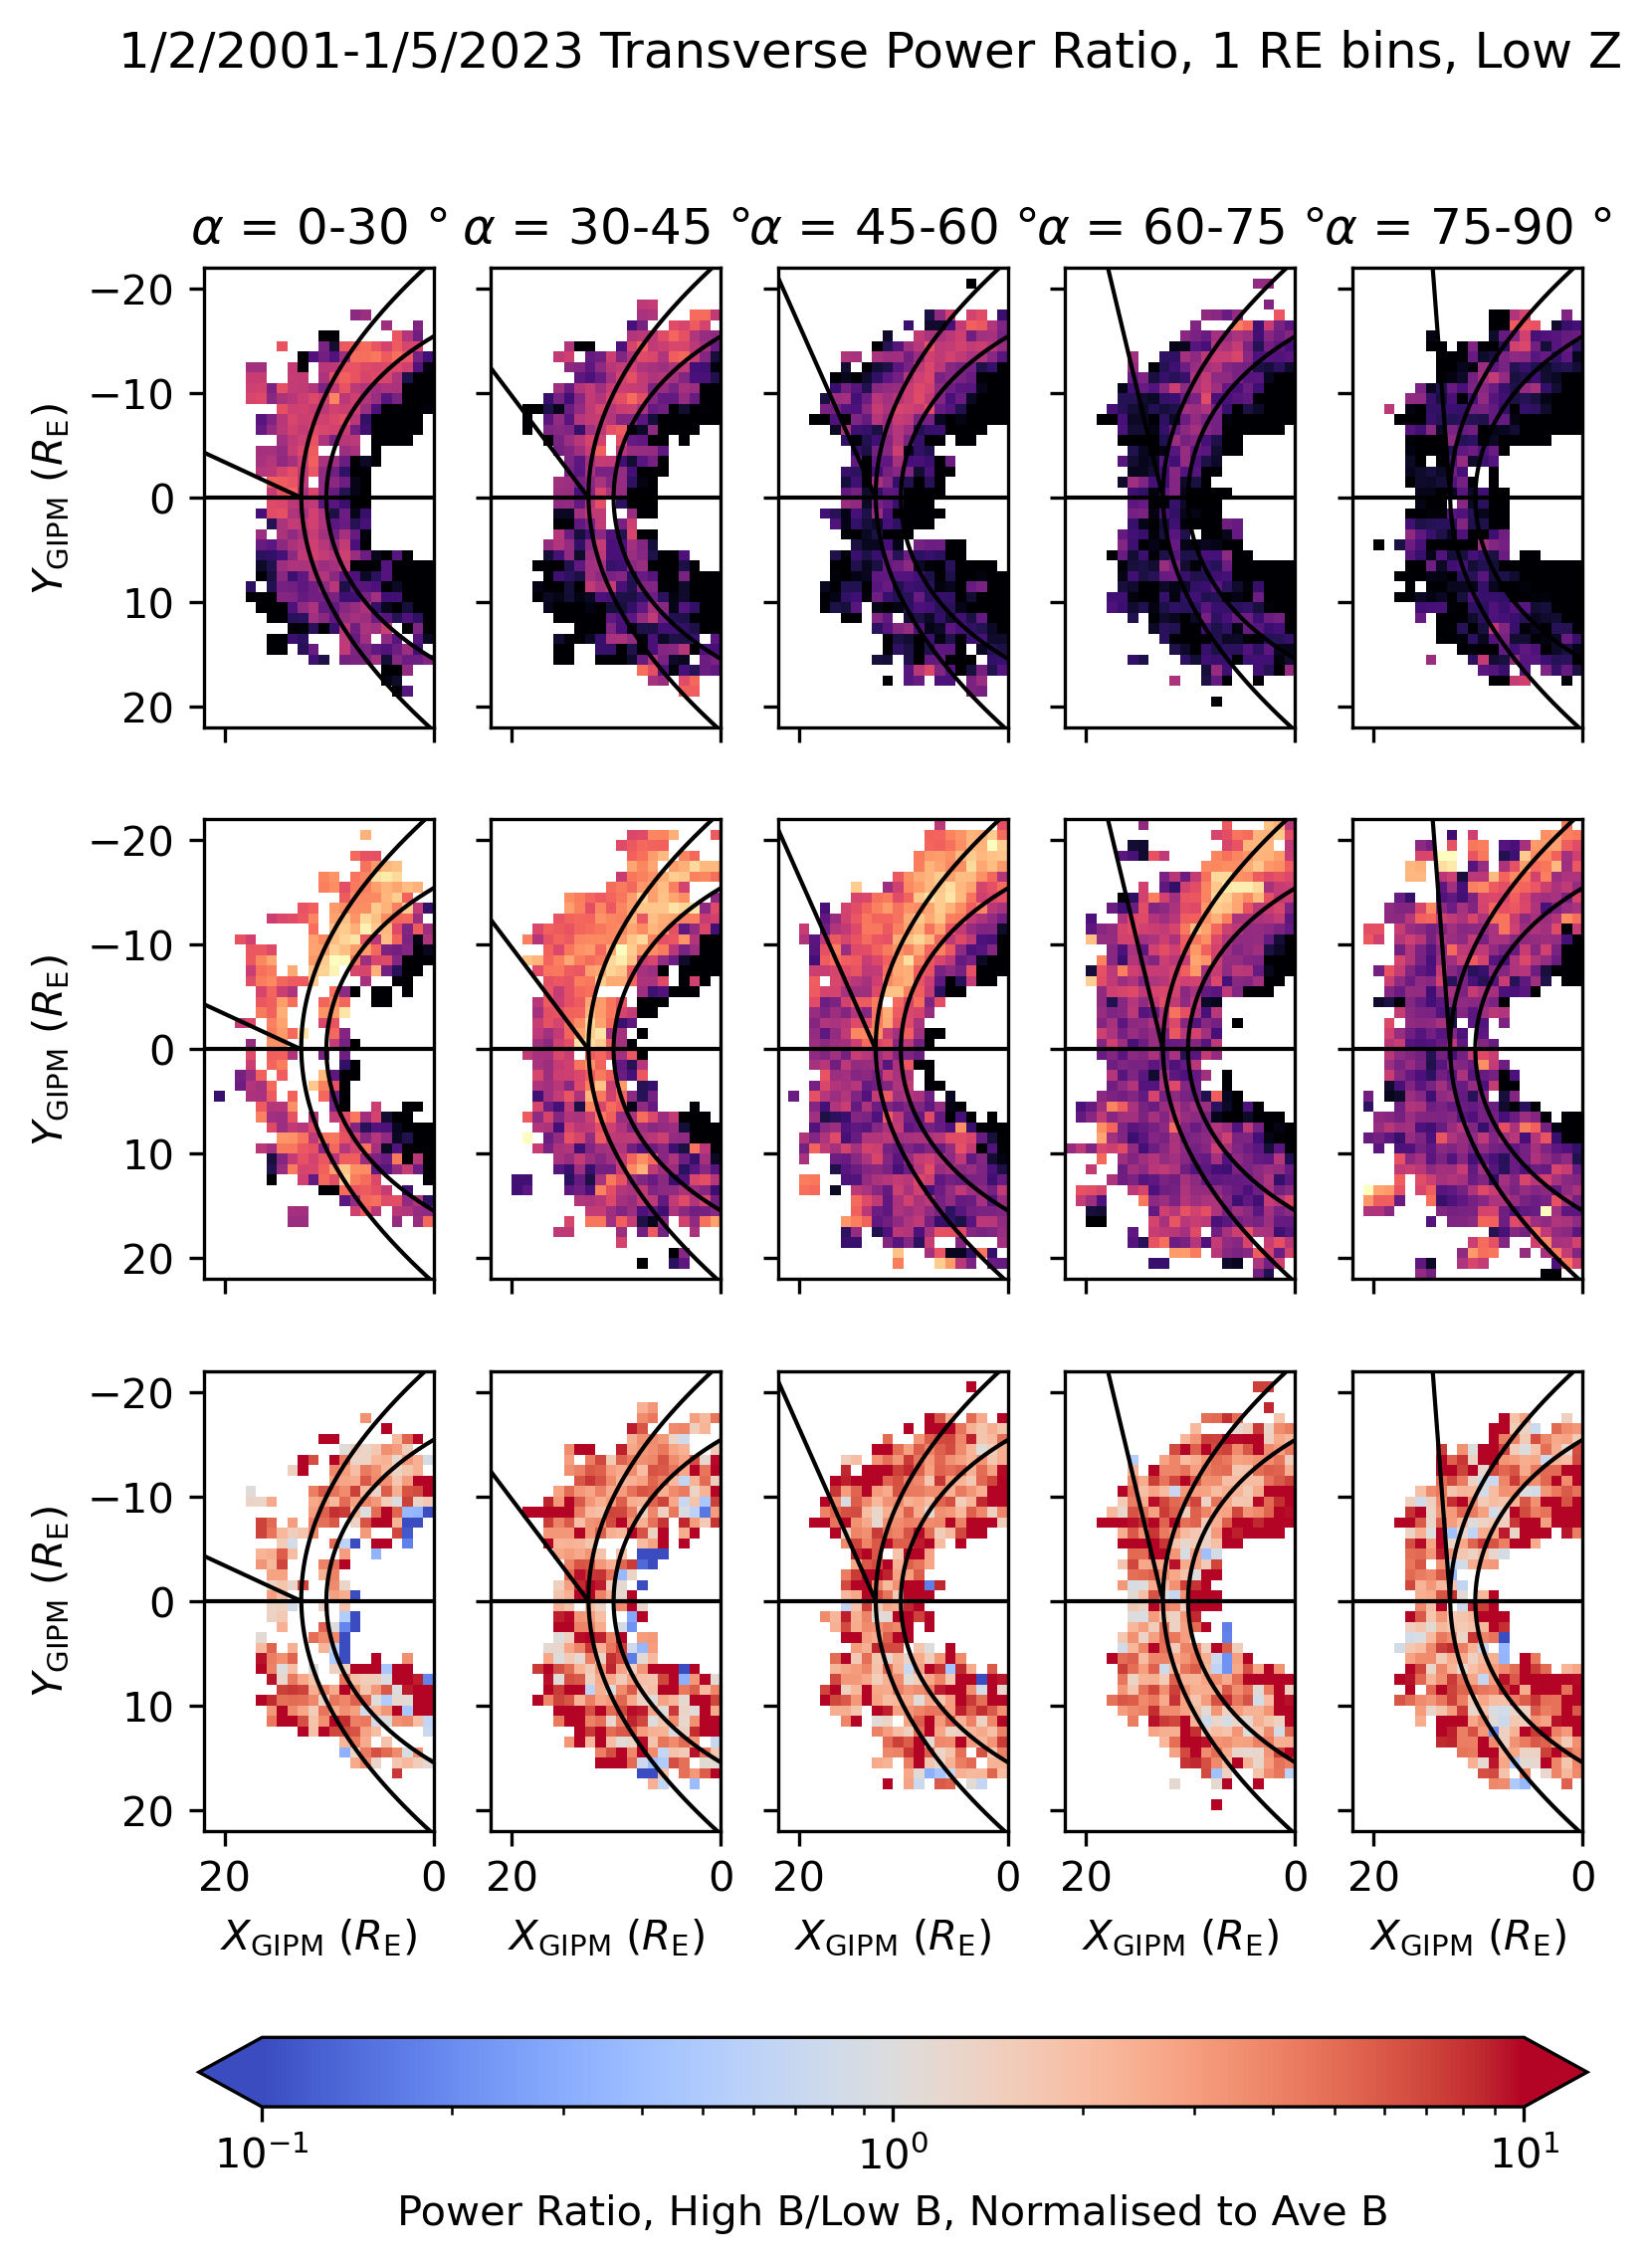

In [17]:
##normed version

#now make the big plot with all the transverse components first

x = np.linspace(0, 20, 100) #x coordinates (Re)
y = np.linspace(-30, 30, 100) #y coordinates (Re)
z = 0 #z coordinates in Re

[Xgipm,Ygipm,Zgipm] = np.meshgrid(x,y,z,indexing="ij")

fitting_coeffs = merka05_surface_eq_array_GIPM(XMA_all)

Xn = Xgipm
Yn = Ygipm
Zn = Zgipm
f = fitting_coeffs[0]*Xn**2 + fitting_coeffs[1]*Yn**2 + fitting_coeffs[2]*Zn**2+ 2*fitting_coeffs[3]*Xn*Yn + 2*fitting_coeffs[4]*Yn*Zn + 2*fitting_coeffs[5]*Xn*Zn + 2*fitting_coeffs[6]*Xn+2*fitting_coeffs[7]*Yn + 2*fitting_coeffs[8]*Zn + fitting_coeffs[9]

x_1 = np.linspace(0, 20, 100) #x coordinates (Re)
y_1 = 0 #y coordinates (Re)
z_1 = np.linspace(-30, 30, 100) #z coordinates in Re

[Xgipm_1,Ygipm_1,Zgipm_1] = np.meshgrid(x_1,y_1,z_1,indexing="ij")
Xn_1 = Xgipm_1
Yn_1 = Ygipm_1
Zn_1 = Zgipm_1
f_1 = fitting_coeffs[0]*Xn_1**2 + fitting_coeffs[1]*Yn_1**2 + fitting_coeffs[2]*Zn_1**2+ 2*fitting_coeffs[3]*Xn_1*Yn_1 + 2*fitting_coeffs[4]*Yn_1*Zn_1 + 2*fitting_coeffs[5]*Xn_1*Zn_1 + 2*fitting_coeffs[6]*Xn_1+2*fitting_coeffs[7]*Yn_1 + 2*fitting_coeffs[8]*Zn_1 + fitting_coeffs[9]

#magnetopause model, D = 2 nPa

m_1 = 10.22
m_2 = 1.29
m_3 = 0.184
m_4 = 8.14
m_5 = 6.6
m_6 = 0.58
m_7 = -0.007
m_8 = 0.024

#use B_z =0
B_z = 0
D_p = 2

alpha = (m_6 + m_7*B_z)*(1 +m_8*(np.log(D_p)))

tanh_angle = m_3*(B_z+m_4)
r_0 = (m_1 + m_2*np.tanh(tanh_angle))*(D_p**(-1/m_5))

pi = np.pi

theta = np.arange(-pi/2, pi/2, 0.01)

r_mod = (2/(1+np.cos(theta)))**alpha
r = r_0*r_mod

X_shue = r*(np.cos(theta))
R_shue = r*(np.sin(theta))

###################
fig, ax = plt.subplots(figsize=(6, 8), dpi=300)
subfigs = fig.subfigures(1, 1)
axsLeft = subfigs.subplots(3, 5, sharey=True, sharex=True)
subfigs.suptitle('1/2/2001-1/5/2023 Transverse Power Ratio, 1 RE bins, Low Z')

#cmap norm

norm = colors.LogNorm(0.1, 10)
norm_plasma = colors.LogNorm(0.1, 10)

#cmap mesh

bin_size = 1
x_mesh = np.arange(0, 25, bin_size) 
y_mesh = np.arange(-26, 26, bin_size)
x_bin_ticks = int(25/bin_size)
y_bin_ticks = int(52/bin_size)

#ax0.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

#want to find three points on the bow shock surface, at y=0 and y=±8 and draw lines from there
#without exceeding current bounds of plot
inter_med = fitting_coeffs[6]**2 - (fitting_coeffs[0]*fitting_coeffs[9])
X_BS_nose = (-fitting_coeffs[6] + np.sqrt(inter_med))/fitting_coeffs[0]

x_s = X_BS_nose
y_s = 0
x_e = 30

tan_angle_0 = np.tan(np.deg2rad(15))
y_e_0 = -x_e*(tan_angle_0)

ax1 = axsLeft[0,0]

ax1.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax1.plot(X_shue, R_shue, linewidth=1, color='k')

col_array_1 = np.array(mean_perp_rad_normB_lowB)
color_grid_1 = col_array_1.reshape(x_bin_ticks, y_bin_ticks)
color_grid_1 = np.rot90(color_grid_1)
color_grid_1 = np.flipud(color_grid_1)

ax1.set_aspect('equal')
#ax1.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax1.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax1.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax1.pcolormesh(x_mesh, y_mesh, color_grid_1[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax1.plot([x_s, x_e], [y_s, y_e_0], color='k',linewidth=1)
ax1.set_ylim(-22,22)
ax1.set_xlim(0,22)
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax1.set_title(r'$\alpha$ = 0-30 $\degree$')
cbar_title = r'Power Ratio, High B/Low B, Normalised to Ave B'
fig.colorbar(cm.ScalarMappable(norm=norm, cmap='coolwarm'),location='bottom',anchor=(0.5, 0), panchor=(0.5, 0.2), pad =0, ax=axsLeft, extend='both', label=cbar_title)


ax2 = axsLeft[1,0]

col_array_2 = np.array(mean_perp_rad_normB_highB)
color_grid_2 = col_array_2.reshape(x_bin_ticks, y_bin_ticks)
color_grid_2 = np.rot90(color_grid_2)
color_grid_2 = np.flipud(color_grid_2)

ax2.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax2.plot(X_shue, R_shue, linewidth=1, color='k')

ax2.set_aspect('equal')
#ax2.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax2.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


ax2.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax2.pcolormesh(x_mesh, y_mesh, color_grid_2[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax2.plot([x_s, x_e], [y_s, y_e_0], color='k',linewidth=1)
ax2.set_ylim(-22,22)
ax2.set_xlim(0,22)
ax2.invert_xaxis()
ax2.invert_yaxis()

ax3 = axsLeft[2,0]

ax3.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax3.plot(X_shue, R_shue, linewidth=1, color='k')

col_array_3 = perp_ratio_rad_normB_lowB_highB
color_grid_3 = col_array_3.reshape(x_bin_ticks, y_bin_ticks)
color_grid_3 = np.rot90(color_grid_3)
color_grid_3 = np.flipud(color_grid_3)

ax3.set_aspect('equal')
#ax3.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax3.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

ax3.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax3.pcolormesh(x_mesh, y_mesh, color_grid_3[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax3.plot([x_s, x_e], [y_s, y_e_0], color='k',linewidth=1)
ax3.set_ylim(-22,22)
ax3.set_xlim(0,22)
ax3.invert_xaxis()
ax3.invert_yaxis()
ax3.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

###########LOW SPIRAL############################

tan_angle_lowspir = np.tan(np.deg2rad(37.5))
y_e_lowspir = -x_e*(tan_angle_lowspir)

ax5 = axsLeft[0,1]

ax5.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax5.plot(X_shue, R_shue, linewidth=1, color='k')
ax5.set_aspect('equal')
#a5.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax5.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_5 = np.array(mean_perp_lowspir_normB_lowB)
color_grid_5 = col_array_5.reshape(x_bin_ticks, y_bin_ticks)
color_grid_5 = np.rot90(color_grid_5)
color_grid_5 = np.flipud(color_grid_5)

ax5.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax5.pcolormesh(x_mesh, y_mesh, color_grid_5[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax5.plot([x_s, x_e], [y_s, y_e_lowspir], color='k',linewidth=1)
ax5.set_ylim(-22,22)
ax5.set_xlim(0,22)
ax5.invert_xaxis()
ax5.invert_yaxis()
ax5.set_title(r'$\alpha$ = 30-45 $\degree$')

ax6 = axsLeft[1,1]

ax6.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax6.plot(X_shue, R_shue, linewidth=1, color='k')
ax6.set_aspect('equal')
#ax6.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax6.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_6 = np.array(mean_perp_lowspir_normB_highB)
color_grid_6 = col_array_6.reshape(x_bin_ticks, y_bin_ticks)
color_grid_6 = np.rot90(color_grid_6)
color_grid_6 = np.flipud(color_grid_6)

ax6.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax6.pcolormesh(x_mesh, y_mesh, color_grid_6[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax6.plot([x_s, x_e], [y_s, y_e_lowspir], color='k',linewidth=1)
ax6.set_ylim(-22,22)
ax6.set_xlim(0,22)
ax6.invert_xaxis()
ax6.invert_yaxis()

ax7 = axsLeft[2,1]

ax7.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax7.plot(X_shue, R_shue, linewidth=1, color='k')
ax7.set_aspect('equal')
#ax7.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax7.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_7 = perp_ratio_lowspir_normB_lowB_highB
color_grid_7 = col_array_7.reshape(x_bin_ticks, y_bin_ticks)
color_grid_7 = np.rot90(color_grid_7)
color_grid_7 = np.flipud(color_grid_7)

ax7.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax7.pcolormesh(x_mesh, y_mesh, color_grid_7[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax7.plot([x_s, x_e], [y_s, y_e_lowspir], color='k',linewidth=1)
ax7.set_ylim(-22,22)
ax7.set_xlim(0,22)
ax7.invert_xaxis()
ax7.invert_yaxis()
ax7.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

###########HIGH SPIRAL############################

tan_angle_highspir = np.tan(np.deg2rad(52.5))
y_e_highspir = -x_e*(tan_angle_highspir)

#ax8.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax8.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

ax9 = axsLeft[0,2]

ax9.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax9.plot(X_shue, R_shue, linewidth=1, color='k')
ax9.set_aspect('equal')
#ax9.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax9.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_9 = np.array(mean_perp_highspir_normB_lowB)
color_grid_9 = col_array_9.reshape(x_bin_ticks, y_bin_ticks)
color_grid_9 = np.rot90(color_grid_9)
color_grid_9 = np.flipud(color_grid_9)

ax9.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax9.pcolormesh(x_mesh, y_mesh, color_grid_9[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax9.plot([x_s, x_e], [y_s, y_e_highspir], color='k',linewidth=1)
ax9.set_ylim(-22,22)
ax9.set_xlim(0,22)
ax9.invert_xaxis()
ax9.invert_yaxis()
ax9.set_title(r'$\alpha$ = 45-60 $\degree$')

ax10 = axsLeft[1,2]

ax10.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax10.plot(X_shue, R_shue, linewidth=1, color='k')
ax10.set_aspect('equal')
#ax10.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax10.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_10 = np.array(mean_perp_highspir_normB_highB)
color_grid_10 = col_array_10.reshape(x_bin_ticks, y_bin_ticks)
color_grid_10 = np.rot90(color_grid_10)
color_grid_10 = np.flipud(color_grid_10)

ax10.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax10.pcolormesh(x_mesh, y_mesh, color_grid_10[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax10.plot([x_s, x_e], [y_s, y_e_highspir], color='k',linewidth=1)
ax10.set_ylim(-22,22)
ax10.set_xlim(0,22)
ax10.invert_xaxis()
ax10.invert_yaxis()

ax11 = axsLeft[2,2]

ax11.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax11.plot(X_shue, R_shue, linewidth=1, color='k')
ax11.set_aspect('equal')
#ax11.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax11.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_11 = perp_ratio_highspir_normB_lowB_highB
color_grid_11 = col_array_11.reshape(x_bin_ticks, y_bin_ticks)
color_grid_11 = np.rot90(color_grid_11)
color_grid_11 = np.flipud(color_grid_11)

ax11.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax11.pcolormesh(x_mesh, y_mesh, color_grid_11[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax11.plot([x_s, x_e], [y_s, y_e_highspir], color='k',linewidth=1)
ax11.set_ylim(-22,22)
ax11.set_xlim(0,22)
ax11.invert_xaxis()
ax11.invert_yaxis()
ax11.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


######LOW PERPENDICULAR

tan_angle_lowperp = np.tan(np.deg2rad(67.5))
y_e_lowperp = -x_e*(tan_angle_lowperp)

ax13 = axsLeft[0,3]

ax13.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax13.plot(X_shue, R_shue, linewidth=1, color='k')
ax13.set_aspect('equal')
ax13.set_title(r'$\alpha$ = 60-75 $\degree$')
#ax13.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax13.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

col_array_13 = np.array(mean_perp_lowperp_normB_lowB)
color_grid_13 = col_array_13.reshape(x_bin_ticks, y_bin_ticks)
color_grid_13 = np.rot90(color_grid_13)
color_grid_13 = np.flipud(color_grid_13)

ax13.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax13.pcolormesh(x_mesh, y_mesh, color_grid_13[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax13.plot([x_s, x_e], [y_s, y_e_lowperp], color='k',linewidth=1)
ax13.set_ylim(-22,22)
ax13.set_xlim(0,22)
ax13.invert_xaxis()
ax13.invert_yaxis()

ax14 = axsLeft[1,3]

ax14.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax14.plot(X_shue, R_shue, linewidth=1, color='k')
ax14.set_aspect('equal')
#ax14.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax14.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

col_array_14 = np.array(mean_perp_lowperp_normB_highB)
color_grid_14 = col_array_14.reshape(x_bin_ticks, y_bin_ticks)
color_grid_14 = np.rot90(color_grid_14)
color_grid_14 = np.flipud(color_grid_14)

ax14.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax14.pcolormesh(x_mesh, y_mesh, color_grid_14[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax14.plot([x_s, x_e], [y_s, y_e_lowperp], color='k',linewidth=1)
ax14.set_ylim(-22,22)
ax14.set_xlim(0,22)
ax14.invert_xaxis()
ax14.invert_yaxis()

ax15 = axsLeft[2,3]

ax15.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax15.plot(X_shue, R_shue, linewidth=1, color='k')
ax15.set_aspect('equal')
#ax15.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax15.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_15 = perp_ratio_lowperp_normB_lowB_highB
color_grid_15 = col_array_15.reshape(x_bin_ticks, y_bin_ticks)
color_grid_15 = np.rot90(color_grid_15)
color_grid_15 = np.flipud(color_grid_15)

ax15.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax15.pcolormesh(x_mesh, y_mesh, color_grid_15[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax15.plot([x_s, x_e], [y_s, y_e_lowperp], color='k',linewidth=1)
ax15.set_ylim(-22,22)
ax15.set_xlim(0,22)
ax15.invert_xaxis()
ax15.invert_yaxis()

ax15.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

######HIGH PERPENDICULAR

tan_angle_highperp = np.tan(np.deg2rad(82.5))
y_e_highperp = -x_e*(tan_angle_highperp)


ax17 = axsLeft[0,4]

ax17.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax17.plot(X_shue, R_shue, linewidth=1, color='k')
ax17.set_aspect('equal')

col_array_17 = np.array(mean_perp_highperp_normB_lowB)
color_grid_17 = col_array_17.reshape(x_bin_ticks, y_bin_ticks)
color_grid_17 = np.rot90(color_grid_17)
color_grid_17 = np.flipud(color_grid_17)

ax17.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax17.pcolormesh(x_mesh, y_mesh, color_grid_17[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax17.plot([x_s, x_e], [y_s, y_e_highperp], color='k',linewidth=1)
ax17.set_ylim(-22,22)
ax17.set_xlim(0,22)
ax17.set_title(r'$\alpha$ = 75-90 $\degree$')
ax17.invert_xaxis()
ax17.invert_yaxis()


ax18 = axsLeft[1,4]

ax18.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax18.plot(X_shue, R_shue, linewidth=1, color='k')
ax18.set_aspect('equal')

col_array_18 = np.array(mean_perp_highperp_normB_highB)
color_grid_18 = col_array_18.reshape(x_bin_ticks, y_bin_ticks)
color_grid_18 = np.rot90(color_grid_18)
color_grid_18 = np.flipud(color_grid_18)

ax18.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax18.pcolormesh(x_mesh, y_mesh, color_grid_18[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax18.plot([x_s, x_e], [y_s, y_e_highperp], color='k',linewidth=1)
ax18.set_ylim(-22,22)
ax18.set_xlim(0,22)
ax18.invert_xaxis()
ax18.invert_yaxis()

ax19 = axsLeft[2,4]

ax19.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax19.plot(X_shue, R_shue, linewidth=1, color='k')
ax19.set_aspect('equal')

col_array_19 = perp_ratio_highperp_normB_lowB_highB
color_grid_19 = col_array_19.reshape(x_bin_ticks, y_bin_ticks)
color_grid_19 = np.rot90(color_grid_19)
color_grid_19 = np.flipud(color_grid_19)

ax19.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax19.pcolormesh(x_mesh, y_mesh, color_grid_19[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax19.plot([x_s, x_e], [y_s, y_e_highperp], color='k',linewidth=1)
ax19.set_ylim(-22,22)
ax19.set_xlim(0,22)
ax19.invert_xaxis()
ax19.invert_yaxis()

ax19.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


Text(0.5, 0, '$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)')

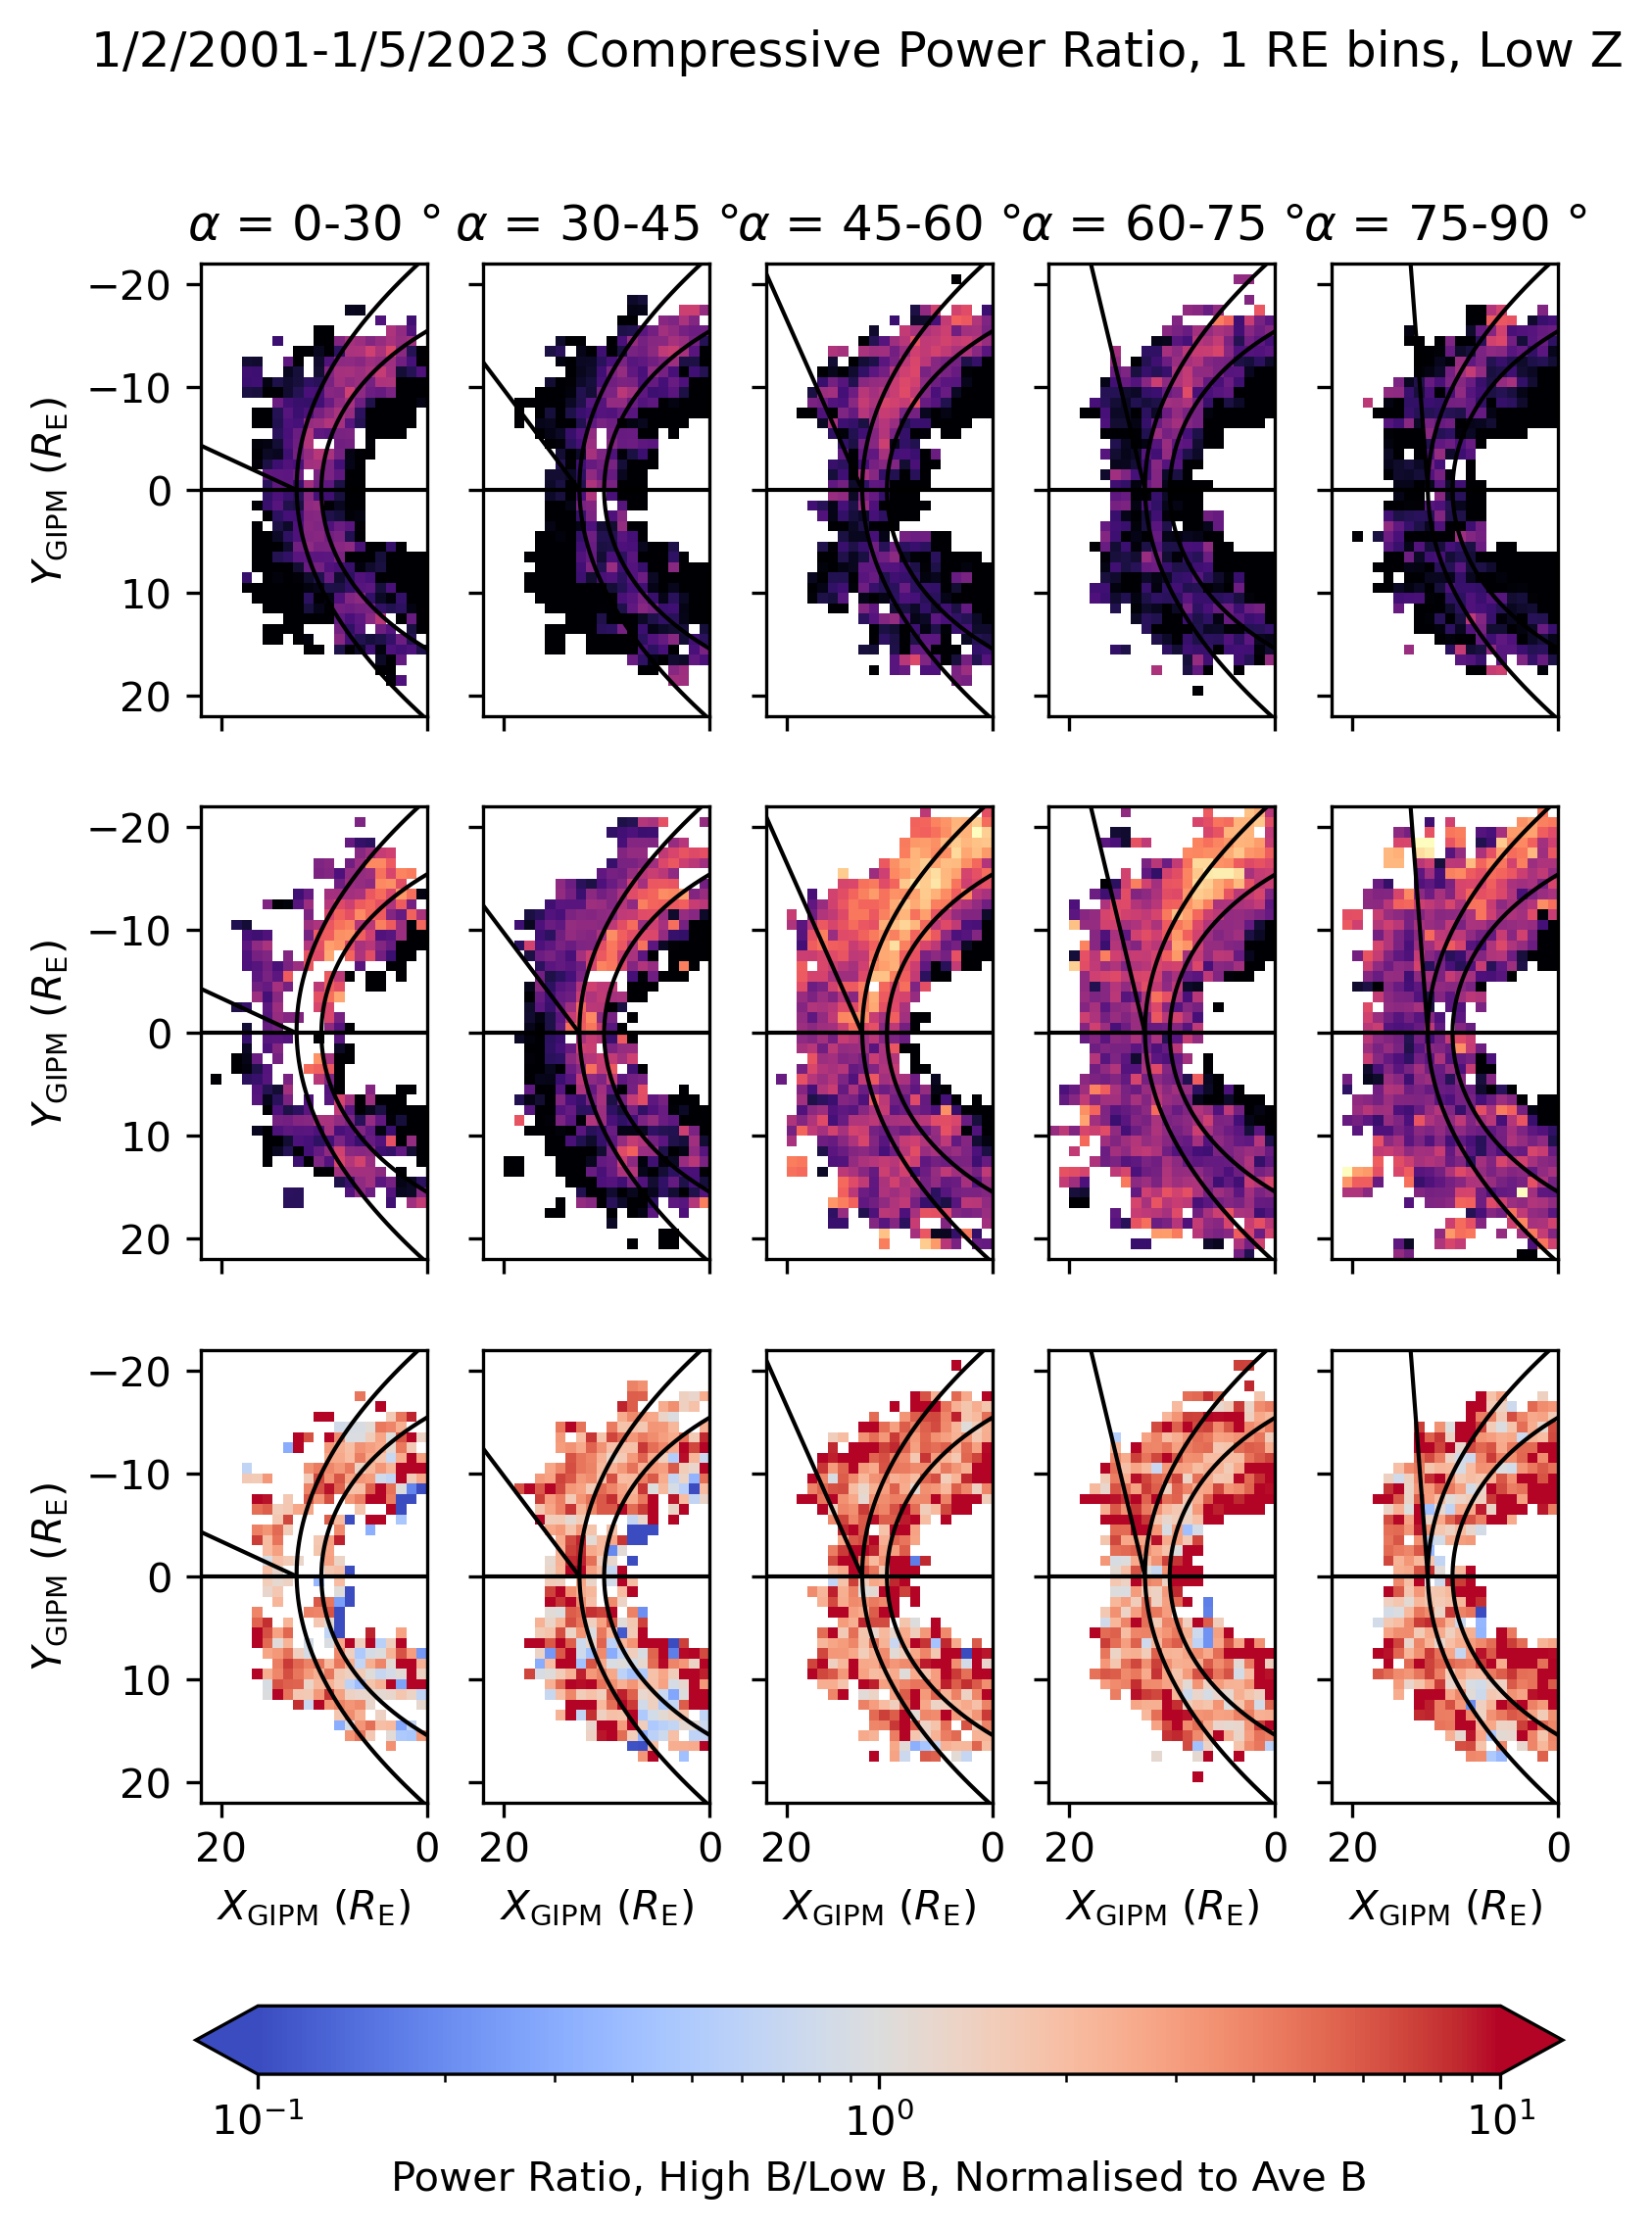

In [18]:
##normed version

#plot w/ two rows of 5-10 and 10-15 and then the ratioerence.

#now make the big plot with all the Compressive components first

x = np.linspace(0, 20, 100) #x coordinates (Re)
y = np.linspace(-30, 30, 100) #y coordinates (Re)
z = 0 #z coordinates in Re

[Xgipm,Ygipm,Zgipm] = np.meshgrid(x,y,z,indexing="ij")

fitting_coeffs = merka05_surface_eq_array_GIPM(XMA_all)

Xn = Xgipm
Yn = Ygipm
Zn = Zgipm
f = fitting_coeffs[0]*Xn**2 + fitting_coeffs[1]*Yn**2 + fitting_coeffs[2]*Zn**2+ 2*fitting_coeffs[3]*Xn*Yn + 2*fitting_coeffs[4]*Yn*Zn + 2*fitting_coeffs[5]*Xn*Zn + 2*fitting_coeffs[6]*Xn+2*fitting_coeffs[7]*Yn + 2*fitting_coeffs[8]*Zn + fitting_coeffs[9]

x_1 = np.linspace(0, 20, 100) #x coordinates (Re)
y_1 = 0 #y coordinates (Re)
z_1 = np.linspace(-30, 30, 100) #z coordinates in Re

[Xgipm_1,Ygipm_1,Zgipm_1] = np.meshgrid(x_1,y_1,z_1,indexing="ij")
Xn_1 = Xgipm_1
Yn_1 = Ygipm_1
Zn_1 = Zgipm_1
f_1 = fitting_coeffs[0]*Xn_1**2 + fitting_coeffs[1]*Yn_1**2 + fitting_coeffs[2]*Zn_1**2+ 2*fitting_coeffs[3]*Xn_1*Yn_1 + 2*fitting_coeffs[4]*Yn_1*Zn_1 + 2*fitting_coeffs[5]*Xn_1*Zn_1 + 2*fitting_coeffs[6]*Xn_1+2*fitting_coeffs[7]*Yn_1 + 2*fitting_coeffs[8]*Zn_1 + fitting_coeffs[9]

#magnetopause model, D = 2 nPa

m_1 = 10.22
m_2 = 1.29
m_3 = 0.184
m_4 = 8.14
m_5 = 6.6
m_6 = 0.58
m_7 = -0.007
m_8 = 0.024

#use B_z =0
B_z = 0
D_p = 2

alpha = (m_6 + m_7*B_z)*(1 +m_8*(np.log(D_p)))

tanh_angle = m_3*(B_z+m_4)
r_0 = (m_1 + m_2*np.tanh(tanh_angle))*(D_p**(-1/m_5))

pi = np.pi

theta = np.arange(-pi/2, pi/2, 0.01)

r_mod = (2/(1+np.cos(theta)))**alpha
r = r_0*r_mod

X_shue = r*(np.cos(theta))
R_shue = r*(np.sin(theta))

###################
fig, ax = plt.subplots(figsize=(6, 8), dpi=300)
subfigs = fig.subfigures(1, 1)
axsLeft = subfigs.subplots(3, 5, sharey=True, sharex=True)
subfigs.suptitle('1/2/2001-1/5/2023 Compressive Power Ratio, 1 RE bins, Low Z')

#cmap norm

norm = colors.LogNorm(0.1, 10)
norm_plasma = colors.LogNorm(0.1, 10)

#cmap mesh

bin_size = 1
x_mesh = np.arange(0, 25, bin_size) 
y_mesh = np.arange(-26, 26, bin_size)
x_bin_ticks = int(25/bin_size)
y_bin_ticks = int(52/bin_size)

#ax0.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

#want to find three points on the bow shock surface, at y=0 and y=±8 and draw lines from there
#without exceeding current bounds of plot
inter_med = fitting_coeffs[6]**2 - (fitting_coeffs[0]*fitting_coeffs[9])
X_BS_nose = (-fitting_coeffs[6] + np.sqrt(inter_med))/fitting_coeffs[0]

x_s = X_BS_nose
y_s = 0
x_e = 30

tan_angle_0 = np.tan(np.deg2rad(15))
y_e_0 = -x_e*(tan_angle_0)

ax1 = axsLeft[0,0]

ax1.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax1.plot(X_shue, R_shue, linewidth=1, color='k')

col_array_1 = np.array(mean_para_rad_normB_lowB)
color_grid_1 = col_array_1.reshape(x_bin_ticks, y_bin_ticks)
color_grid_1 = np.rot90(color_grid_1)
color_grid_1 = np.flipud(color_grid_1)

ax1.set_aspect('equal')
#ax1.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax1.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax1.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax1.pcolormesh(x_mesh, y_mesh, color_grid_1[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax1.plot([x_s, x_e], [y_s, y_e_0], color='k',linewidth=1)
ax1.set_ylim(-22,22)
ax1.set_xlim(0,22)
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax1.set_title(r'$\alpha$ = 0-30 $\degree$')
cbar_title = r'Power Ratio, High B/Low B, Normalised to Ave B'
fig.colorbar(cm.ScalarMappable(norm=norm, cmap='coolwarm'),location='bottom',anchor=(0.5, 0), panchor=(0.5, 0.2), pad =0, ax=axsLeft, extend='both', label=cbar_title)


ax2 = axsLeft[1,0]

col_array_2 = np.array(mean_para_rad_normB_highB)
color_grid_2 = col_array_2.reshape(x_bin_ticks, y_bin_ticks)
color_grid_2 = np.rot90(color_grid_2)
color_grid_2 = np.flipud(color_grid_2)

ax2.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax2.plot(X_shue, R_shue, linewidth=1, color='k')

ax2.set_aspect('equal')
#ax2.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax2.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


ax2.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax2.pcolormesh(x_mesh, y_mesh, color_grid_2[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax2.plot([x_s, x_e], [y_s, y_e_0], color='k',linewidth=1)
ax2.set_ylim(-22,22)
ax2.set_xlim(0,22)
ax2.invert_xaxis()
ax2.invert_yaxis()

ax3 = axsLeft[2,0]

ax3.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax3.plot(X_shue, R_shue, linewidth=1, color='k')

col_array_3 = para_ratio_rad_normB_lowB_highB
color_grid_3 = col_array_3.reshape(x_bin_ticks, y_bin_ticks)
color_grid_3 = np.rot90(color_grid_3)
color_grid_3 = np.flipud(color_grid_3)

ax3.set_aspect('equal')
#ax3.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax3.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

ax3.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax3.pcolormesh(x_mesh, y_mesh, color_grid_3[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax3.plot([x_s, x_e], [y_s, y_e_0], color='k',linewidth=1)
ax3.set_ylim(-22,22)
ax3.set_xlim(0,22)
ax3.invert_xaxis()
ax3.invert_yaxis()
ax3.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

###########LOW SPIRAL############################

tan_angle_lowspir = np.tan(np.deg2rad(37.5))
y_e_lowspir = -x_e*(tan_angle_lowspir)

ax5 = axsLeft[0,1]

ax5.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax5.plot(X_shue, R_shue, linewidth=1, color='k')
ax5.set_aspect('equal')
#a5.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax5.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_5 = np.array(mean_para_lowspir_normB_lowB)
color_grid_5 = col_array_5.reshape(x_bin_ticks, y_bin_ticks)
color_grid_5 = np.rot90(color_grid_5)
color_grid_5 = np.flipud(color_grid_5)

ax5.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax5.pcolormesh(x_mesh, y_mesh, color_grid_5[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax5.plot([x_s, x_e], [y_s, y_e_lowspir], color='k',linewidth=1)
ax5.set_ylim(-22,22)
ax5.set_xlim(0,22)
ax5.invert_xaxis()
ax5.invert_yaxis()
ax5.set_title(r'$\alpha$ = 30-45 $\degree$')

ax6 = axsLeft[1,1]

ax6.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax6.plot(X_shue, R_shue, linewidth=1, color='k')
ax6.set_aspect('equal')
#ax6.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax6.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_6 = np.array(mean_para_lowspir_normB_highB)
color_grid_6 = col_array_6.reshape(x_bin_ticks, y_bin_ticks)
color_grid_6 = np.rot90(color_grid_6)
color_grid_6 = np.flipud(color_grid_6)

ax6.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax6.pcolormesh(x_mesh, y_mesh, color_grid_6[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax6.plot([x_s, x_e], [y_s, y_e_lowspir], color='k',linewidth=1)
ax6.set_ylim(-22,22)
ax6.set_xlim(0,22)
ax6.invert_xaxis()
ax6.invert_yaxis()

ax7 = axsLeft[2,1]

ax7.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax7.plot(X_shue, R_shue, linewidth=1, color='k')
ax7.set_aspect('equal')
#ax7.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax7.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_7 = para_ratio_lowspir_normB_lowB_highB
color_grid_7 = col_array_7.reshape(x_bin_ticks, y_bin_ticks)
color_grid_7 = np.rot90(color_grid_7)
color_grid_7 = np.flipud(color_grid_7)

ax7.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax7.pcolormesh(x_mesh, y_mesh, color_grid_7[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax7.plot([x_s, x_e], [y_s, y_e_lowspir], color='k',linewidth=1)
ax7.set_ylim(-22,22)
ax7.set_xlim(0,22)
ax7.invert_xaxis()
ax7.invert_yaxis()
ax7.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

###########HIGH SPIRAL############################

tan_angle_highspir = np.tan(np.deg2rad(52.5))
y_e_highspir = -x_e*(tan_angle_highspir)

#ax8.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax8.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

ax9 = axsLeft[0,2]

ax9.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax9.plot(X_shue, R_shue, linewidth=1, color='k')
ax9.set_aspect('equal')
#ax9.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax9.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_9 = np.array(mean_perp_highspir_normB_lowB)
color_grid_9 = col_array_9.reshape(x_bin_ticks, y_bin_ticks)
color_grid_9 = np.rot90(color_grid_9)
color_grid_9 = np.flipud(color_grid_9)

ax9.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax9.pcolormesh(x_mesh, y_mesh, color_grid_9[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax9.plot([x_s, x_e], [y_s, y_e_highspir], color='k',linewidth=1)
ax9.set_ylim(-22,22)
ax9.set_xlim(0,22)
ax9.invert_xaxis()
ax9.invert_yaxis()
ax9.set_title(r'$\alpha$ = 45-60 $\degree$')

ax10 = axsLeft[1,2]

ax10.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax10.plot(X_shue, R_shue, linewidth=1, color='k')
ax10.set_aspect('equal')
#ax10.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax10.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_10 = np.array(mean_perp_highspir_normB_highB)
color_grid_10 = col_array_10.reshape(x_bin_ticks, y_bin_ticks)
color_grid_10 = np.rot90(color_grid_10)
color_grid_10 = np.flipud(color_grid_10)

ax10.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax10.pcolormesh(x_mesh, y_mesh, color_grid_10[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax10.plot([x_s, x_e], [y_s, y_e_highspir], color='k',linewidth=1)
ax10.set_ylim(-22,22)
ax10.set_xlim(0,22)
ax10.invert_xaxis()
ax10.invert_yaxis()

ax11 = axsLeft[2,2]

ax11.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax11.plot(X_shue, R_shue, linewidth=1, color='k')
ax11.set_aspect('equal')
#ax11.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax11.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_11 = perp_ratio_highspir_normB_lowB_highB
color_grid_11 = col_array_11.reshape(x_bin_ticks, y_bin_ticks)
color_grid_11 = np.rot90(color_grid_11)
color_grid_11 = np.flipud(color_grid_11)

ax11.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax11.pcolormesh(x_mesh, y_mesh, color_grid_11[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax11.plot([x_s, x_e], [y_s, y_e_highspir], color='k',linewidth=1)
ax11.set_ylim(-22,22)
ax11.set_xlim(0,22)
ax11.invert_xaxis()
ax11.invert_yaxis()
ax11.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


######LOW PERPENDICULAR

tan_angle_lowperp = np.tan(np.deg2rad(67.5))
y_e_lowperp = -x_e*(tan_angle_lowperp)

ax13 = axsLeft[0,3]

ax13.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax13.plot(X_shue, R_shue, linewidth=1, color='k')
ax13.set_aspect('equal')
ax13.set_title(r'$\alpha$ = 60-75 $\degree$')
#ax13.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax13.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

col_array_13 = np.array(mean_perp_lowperp_normB_lowB)
color_grid_13 = col_array_13.reshape(x_bin_ticks, y_bin_ticks)
color_grid_13 = np.rot90(color_grid_13)
color_grid_13 = np.flipud(color_grid_13)

ax13.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax13.pcolormesh(x_mesh, y_mesh, color_grid_13[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax13.plot([x_s, x_e], [y_s, y_e_lowperp], color='k',linewidth=1)
ax13.set_ylim(-22,22)
ax13.set_xlim(0,22)
ax13.invert_xaxis()
ax13.invert_yaxis()

ax14 = axsLeft[1,3]

ax14.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax14.plot(X_shue, R_shue, linewidth=1, color='k')
ax14.set_aspect('equal')
#ax14.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax14.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

col_array_14 = np.array(mean_perp_lowperp_normB_highB)
color_grid_14 = col_array_14.reshape(x_bin_ticks, y_bin_ticks)
color_grid_14 = np.rot90(color_grid_14)
color_grid_14 = np.flipud(color_grid_14)

ax14.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax14.pcolormesh(x_mesh, y_mesh, color_grid_14[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax14.plot([x_s, x_e], [y_s, y_e_lowperp], color='k',linewidth=1)
ax14.set_ylim(-22,22)
ax14.set_xlim(0,22)
ax14.invert_xaxis()
ax14.invert_yaxis()

ax15 = axsLeft[2,3]

ax15.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax15.plot(X_shue, R_shue, linewidth=1, color='k')
ax15.set_aspect('equal')
#ax15.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax15.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_15 = perp_ratio_lowperp_normB_lowB_highB
color_grid_15 = col_array_15.reshape(x_bin_ticks, y_bin_ticks)
color_grid_15 = np.rot90(color_grid_15)
color_grid_15 = np.flipud(color_grid_15)

ax15.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax15.pcolormesh(x_mesh, y_mesh, color_grid_15[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax15.plot([x_s, x_e], [y_s, y_e_lowperp], color='k',linewidth=1)
ax15.set_ylim(-22,22)
ax15.set_xlim(0,22)
ax15.invert_xaxis()
ax15.invert_yaxis()

ax15.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

######HIGH PERPENDICULAR

tan_angle_highperp = np.tan(np.deg2rad(82.5))
y_e_highperp = -x_e*(tan_angle_highperp)


ax17 = axsLeft[0,4]

ax17.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax17.plot(X_shue, R_shue, linewidth=1, color='k')
ax17.set_aspect('equal')

col_array_17 = np.array(mean_perp_highperp_normB_lowB)
color_grid_17 = col_array_17.reshape(x_bin_ticks, y_bin_ticks)
color_grid_17 = np.rot90(color_grid_17)
color_grid_17 = np.flipud(color_grid_17)

ax17.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax17.pcolormesh(x_mesh, y_mesh, color_grid_17[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax17.plot([x_s, x_e], [y_s, y_e_highperp], color='k',linewidth=1)
ax17.set_ylim(-22,22)
ax17.set_xlim(0,22)
ax17.set_title(r'$\alpha$ = 75-90 $\degree$')
ax17.invert_xaxis()
ax17.invert_yaxis()


ax18 = axsLeft[1,4]

ax18.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax18.plot(X_shue, R_shue, linewidth=1, color='k')
ax18.set_aspect('equal')

col_array_18 = np.array(mean_perp_highperp_normB_highB)
color_grid_18 = col_array_18.reshape(x_bin_ticks, y_bin_ticks)
color_grid_18 = np.rot90(color_grid_18)
color_grid_18 = np.flipud(color_grid_18)

ax18.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax18.pcolormesh(x_mesh, y_mesh, color_grid_18[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax18.plot([x_s, x_e], [y_s, y_e_highperp], color='k',linewidth=1)
ax18.set_ylim(-22,22)
ax18.set_xlim(0,22)
ax18.invert_xaxis()
ax18.invert_yaxis()

ax19 = axsLeft[2,4]

ax19.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax19.plot(X_shue, R_shue, linewidth=1, color='k')
ax19.set_aspect('equal')

col_array_19 = perp_ratio_highperp_normB_lowB_highB
color_grid_19 = col_array_19.reshape(x_bin_ticks, y_bin_ticks)
color_grid_19 = np.rot90(color_grid_19)
color_grid_19 = np.flipud(color_grid_19)

ax19.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax19.pcolormesh(x_mesh, y_mesh, color_grid_19[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax19.plot([x_s, x_e], [y_s, y_e_highperp], color='k',linewidth=1)
ax19.set_ylim(-22,22)
ax19.set_xlim(0,22)
ax19.invert_xaxis()
ax19.invert_yaxis()

ax19.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


In [19]:
##ratio of ratios, how much is it changing?

change_normB_over_regular_rad = perp_ratio_rad_normB_lowB_highB/perp_ratio_rad_lowB_highB
change_normB_over_regular_lowspir = perp_ratio_lowspir_normB_lowB_highB/perp_ratio_lowspir_lowB_highB
change_normB_over_regular_highspir = perp_ratio_highspir_normB_lowB_highB/perp_ratio_highspir_lowB_highB
change_normB_over_regular_lowperp = perp_ratio_lowperp_normB_lowB_highB/perp_ratio_lowperp_lowB_highB
change_normB_over_regular_highperp = perp_ratio_highperp_normB_lowB_highB/perp_ratio_highperp_lowB_highB


In [20]:
np.nanmax(change_normB_over_regular_highspir)

18.908224127859047

In [21]:
np.nanmin(change_normB_over_regular_highspir)

0.1510218730067321

Text(0.5, 0, '$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)')

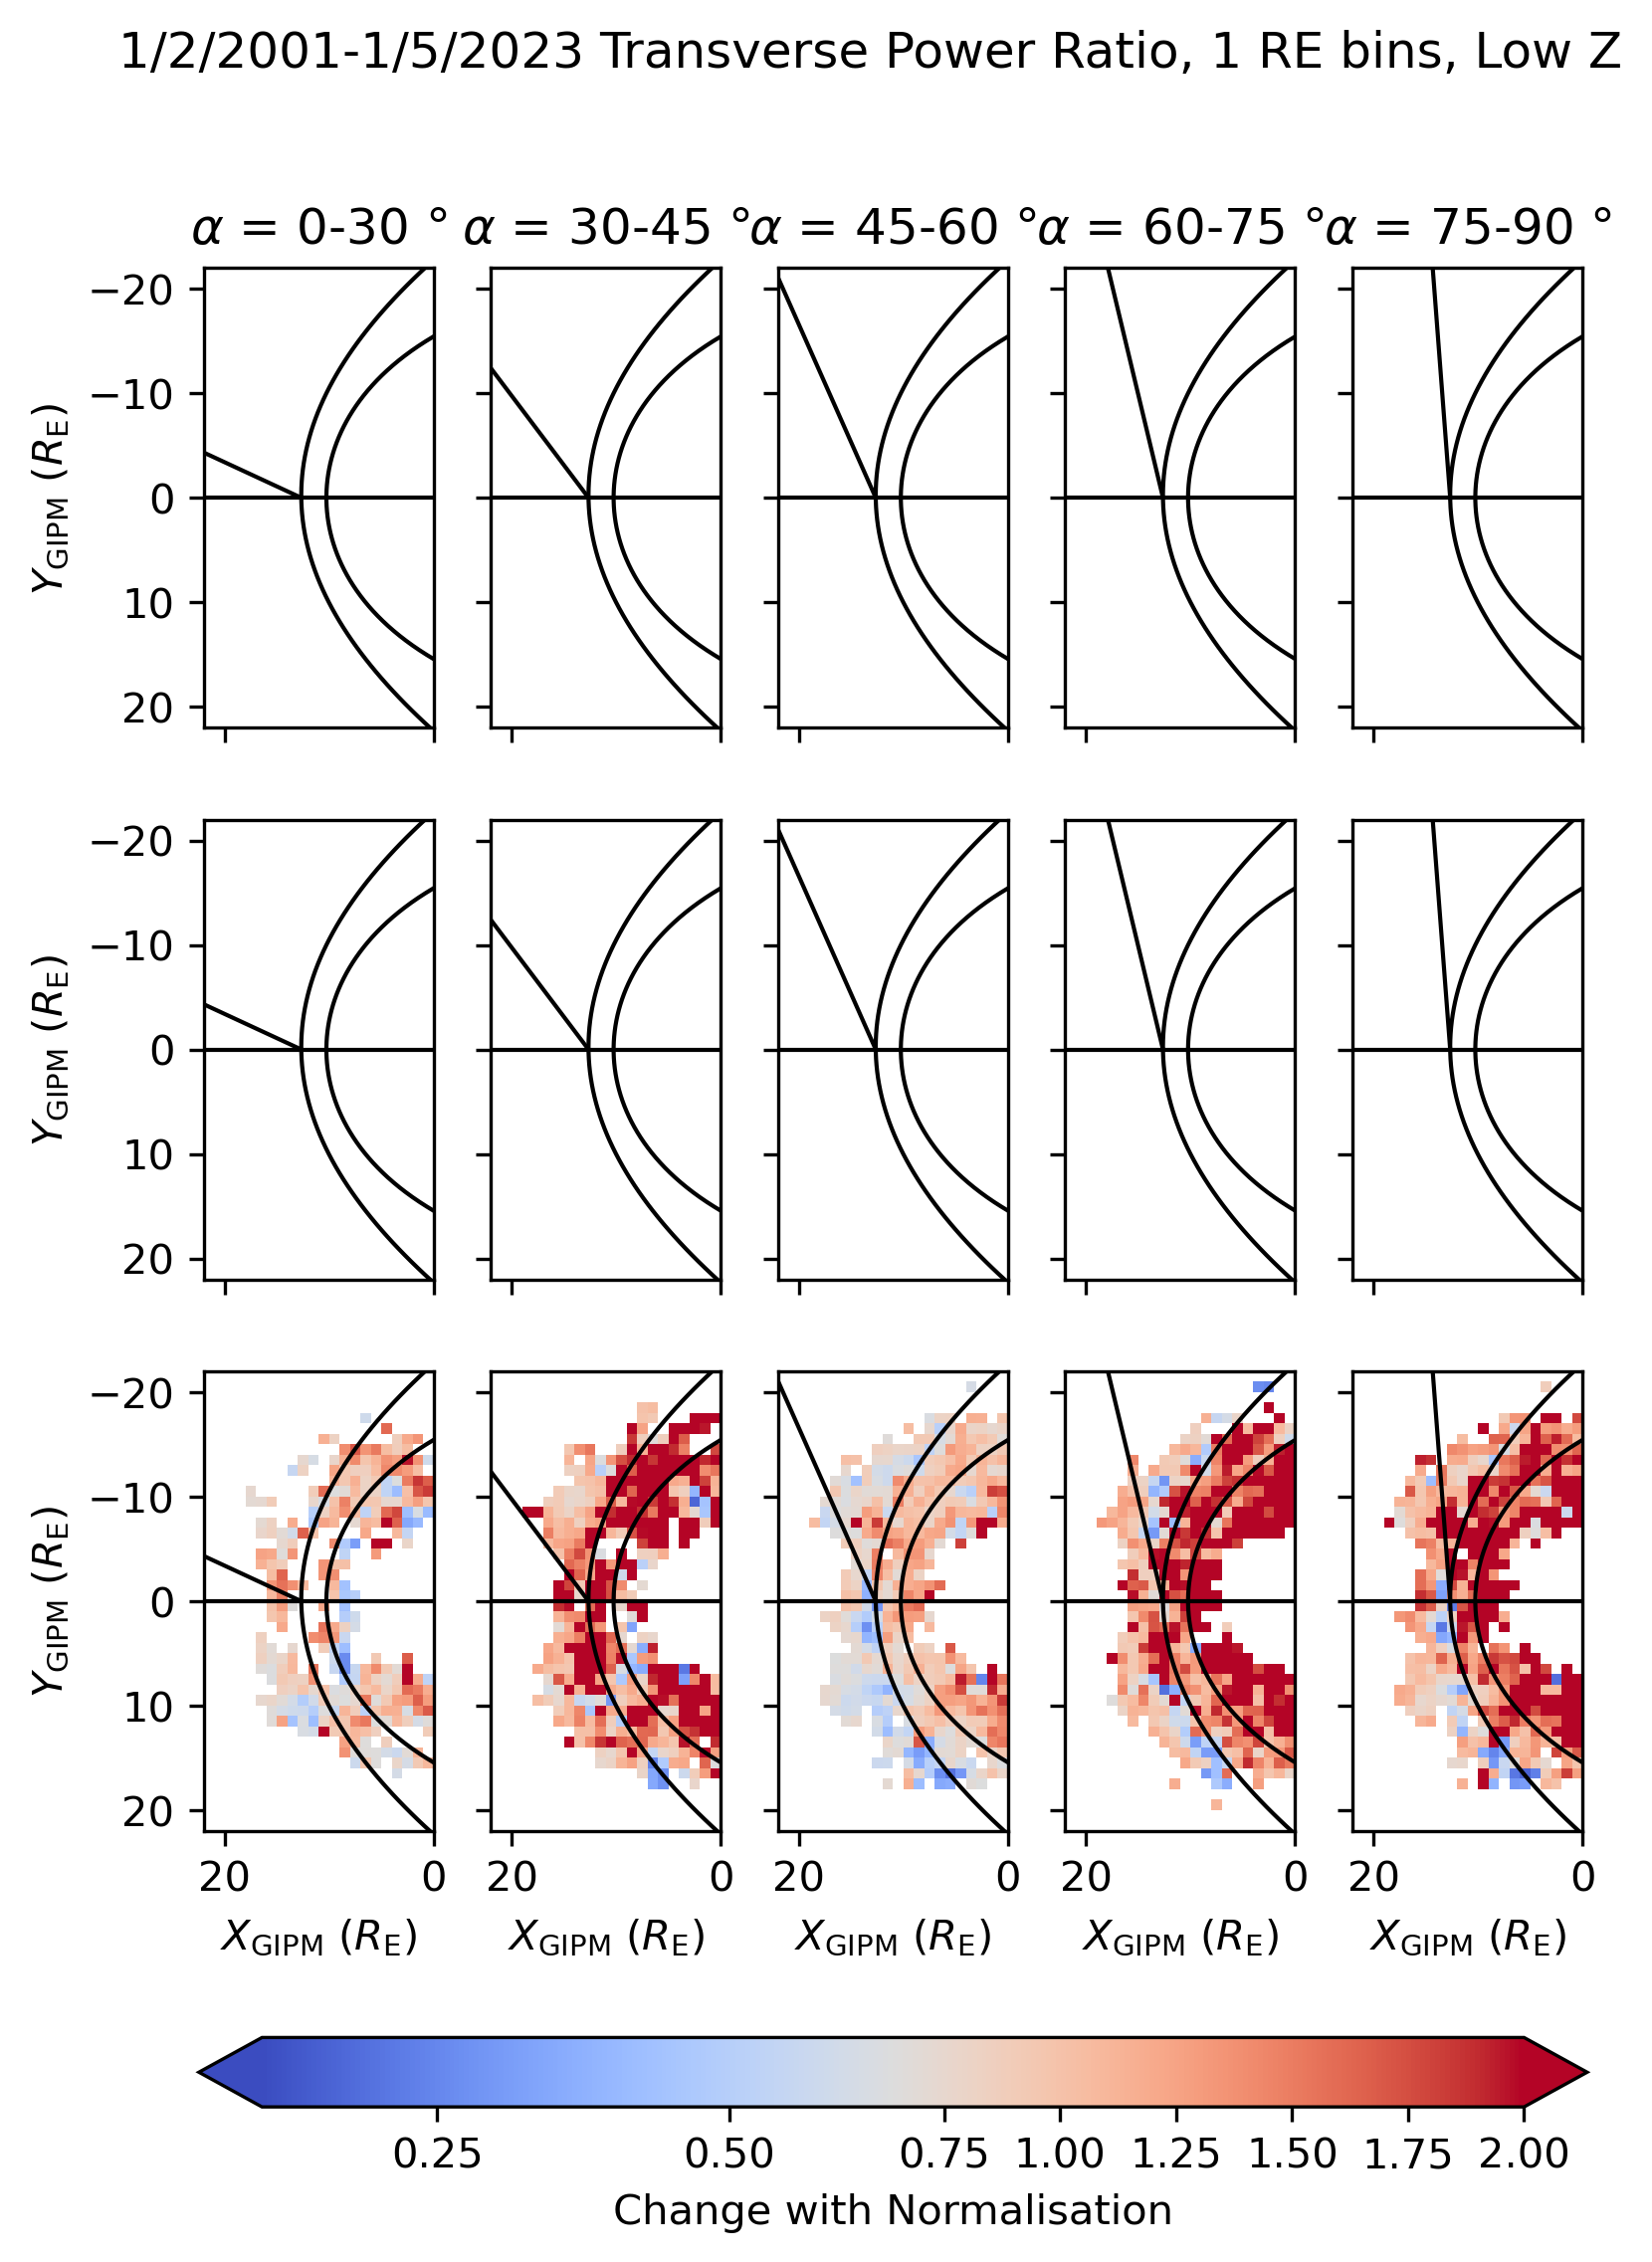

In [22]:
##normed version

#now make the big plot with all the transverse components first

x = np.linspace(0, 20, 100) #x coordinates (Re)
y = np.linspace(-30, 30, 100) #y coordinates (Re)
z = 0 #z coordinates in Re

[Xgipm,Ygipm,Zgipm] = np.meshgrid(x,y,z,indexing="ij")

fitting_coeffs = merka05_surface_eq_array_GIPM(XMA_all)

Xn = Xgipm
Yn = Ygipm
Zn = Zgipm
f = fitting_coeffs[0]*Xn**2 + fitting_coeffs[1]*Yn**2 + fitting_coeffs[2]*Zn**2+ 2*fitting_coeffs[3]*Xn*Yn + 2*fitting_coeffs[4]*Yn*Zn + 2*fitting_coeffs[5]*Xn*Zn + 2*fitting_coeffs[6]*Xn+2*fitting_coeffs[7]*Yn + 2*fitting_coeffs[8]*Zn + fitting_coeffs[9]

x_1 = np.linspace(0, 20, 100) #x coordinates (Re)
y_1 = 0 #y coordinates (Re)
z_1 = np.linspace(-30, 30, 100) #z coordinates in Re

[Xgipm_1,Ygipm_1,Zgipm_1] = np.meshgrid(x_1,y_1,z_1,indexing="ij")
Xn_1 = Xgipm_1
Yn_1 = Ygipm_1
Zn_1 = Zgipm_1
f_1 = fitting_coeffs[0]*Xn_1**2 + fitting_coeffs[1]*Yn_1**2 + fitting_coeffs[2]*Zn_1**2+ 2*fitting_coeffs[3]*Xn_1*Yn_1 + 2*fitting_coeffs[4]*Yn_1*Zn_1 + 2*fitting_coeffs[5]*Xn_1*Zn_1 + 2*fitting_coeffs[6]*Xn_1+2*fitting_coeffs[7]*Yn_1 + 2*fitting_coeffs[8]*Zn_1 + fitting_coeffs[9]

#magnetopause model, D = 2 nPa

m_1 = 10.22
m_2 = 1.29
m_3 = 0.184
m_4 = 8.14
m_5 = 6.6
m_6 = 0.58
m_7 = -0.007
m_8 = 0.024

#use B_z =0
B_z = 0
D_p = 2

alpha = (m_6 + m_7*B_z)*(1 +m_8*(np.log(D_p)))

tanh_angle = m_3*(B_z+m_4)
r_0 = (m_1 + m_2*np.tanh(tanh_angle))*(D_p**(-1/m_5))

pi = np.pi

theta = np.arange(-pi/2, pi/2, 0.01)

r_mod = (2/(1+np.cos(theta)))**alpha
r = r_0*r_mod

X_shue = r*(np.cos(theta))
R_shue = r*(np.sin(theta))

###################
fig, ax = plt.subplots(figsize=(6, 8), dpi=300)
subfigs = fig.subfigures(1, 1)
axsLeft = subfigs.subplots(3, 5, sharey=True, sharex=True)
subfigs.suptitle('1/2/2001-1/5/2023 Transverse Power Ratio, 1 RE bins, Low Z')

#cmap norm

norm = colors.LogNorm(0.1, 10)
norm_plasma = colors.LogNorm(0.1, 10)
norm_ratio = colors.TwoSlopeNorm(0.64, vmin=0.1, vmax=2)

#cmap mesh

bin_size = 1
x_mesh = np.arange(0, 25, bin_size) 
y_mesh = np.arange(-26, 26, bin_size)
x_bin_ticks = int(25/bin_size)
y_bin_ticks = int(52/bin_size)

#ax0.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

#want to find three points on the bow shock surface, at y=0 and y=±8 and draw lines from there
#without exceeding current bounds of plot
inter_med = fitting_coeffs[6]**2 - (fitting_coeffs[0]*fitting_coeffs[9])
X_BS_nose = (-fitting_coeffs[6] + np.sqrt(inter_med))/fitting_coeffs[0]

x_s = X_BS_nose
y_s = 0
x_e = 30

tan_angle_0 = np.tan(np.deg2rad(15))
y_e_0 = -x_e*(tan_angle_0)

ax1 = axsLeft[0,0]

ax1.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax1.plot(X_shue, R_shue, linewidth=1, color='k')

col_array_1 = np.array(mean_perp_rad_normB_lowB)
color_grid_1 = col_array_1.reshape(x_bin_ticks, y_bin_ticks)
color_grid_1 = np.rot90(color_grid_1)
color_grid_1 = np.flipud(color_grid_1)

ax1.set_aspect('equal')
#ax1.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax1.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax1.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
#ax1.pcolormesh(x_mesh, y_mesh, color_grid_1[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax1.plot([x_s, x_e], [y_s, y_e_0], color='k',linewidth=1)
ax1.set_ylim(-22,22)
ax1.set_xlim(0,22)
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax1.set_title(r'$\alpha$ = 0-30 $\degree$')
cbar_title = r'Change with Normalisation'
fig.colorbar(cm.ScalarMappable(norm=norm_ratio, cmap='coolwarm'),location='bottom',anchor=(0.5, 0), panchor=(0.5, 0.2), pad =0, ax=axsLeft, extend='both', label=cbar_title)


ax2 = axsLeft[1,0]

col_array_2 = np.array(mean_perp_rad_normB_highB)
color_grid_2 = col_array_2.reshape(x_bin_ticks, y_bin_ticks)
color_grid_2 = np.rot90(color_grid_2)
color_grid_2 = np.flipud(color_grid_2)

ax2.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax2.plot(X_shue, R_shue, linewidth=1, color='k')

ax2.set_aspect('equal')
#ax2.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax2.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


ax2.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
#ax2.pcolormesh(x_mesh, y_mesh, color_grid_2[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax2.plot([x_s, x_e], [y_s, y_e_0], color='k',linewidth=1)
ax2.set_ylim(-22,22)
ax2.set_xlim(0,22)
ax2.invert_xaxis()
ax2.invert_yaxis()

ax3 = axsLeft[2,0]

ax3.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax3.plot(X_shue, R_shue, linewidth=1, color='k')

col_array_3 = change_normB_over_regular_rad
color_grid_3 = col_array_3.reshape(x_bin_ticks, y_bin_ticks)
color_grid_3 = np.rot90(color_grid_3)
color_grid_3 = np.flipud(color_grid_3)

ax3.set_aspect('equal')
#ax3.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax3.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

ax3.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax3.pcolormesh(x_mesh, y_mesh, color_grid_3[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax3.plot([x_s, x_e], [y_s, y_e_0], color='k',linewidth=1)
ax3.set_ylim(-22,22)
ax3.set_xlim(0,22)
ax3.invert_xaxis()
ax3.invert_yaxis()
ax3.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

###########LOW SPIRAL############################

tan_angle_lowspir = np.tan(np.deg2rad(37.5))
y_e_lowspir = -x_e*(tan_angle_lowspir)

ax5 = axsLeft[0,1]

ax5.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax5.plot(X_shue, R_shue, linewidth=1, color='k')
ax5.set_aspect('equal')
#a5.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax5.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_5 = np.array(mean_perp_lowspir_normB_lowB)
color_grid_5 = col_array_5.reshape(x_bin_ticks, y_bin_ticks)
color_grid_5 = np.rot90(color_grid_5)
color_grid_5 = np.flipud(color_grid_5)

ax5.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
#ax5.pcolormesh(x_mesh, y_mesh, color_grid_5[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax5.plot([x_s, x_e], [y_s, y_e_lowspir], color='k',linewidth=1)
ax5.set_ylim(-22,22)
ax5.set_xlim(0,22)
ax5.invert_xaxis()
ax5.invert_yaxis()
ax5.set_title(r'$\alpha$ = 30-45 $\degree$')

ax6 = axsLeft[1,1]

ax6.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax6.plot(X_shue, R_shue, linewidth=1, color='k')
ax6.set_aspect('equal')
#ax6.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax6.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_6 = np.array(mean_perp_lowspir_normB_highB)
color_grid_6 = col_array_6.reshape(x_bin_ticks, y_bin_ticks)
color_grid_6 = np.rot90(color_grid_6)
color_grid_6 = np.flipud(color_grid_6)

ax6.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
#ax6.pcolormesh(x_mesh, y_mesh, color_grid_6[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax6.plot([x_s, x_e], [y_s, y_e_lowspir], color='k',linewidth=1)
ax6.set_ylim(-22,22)
ax6.set_xlim(0,22)
ax6.invert_xaxis()
ax6.invert_yaxis()

ax7 = axsLeft[2,1]

ax7.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax7.plot(X_shue, R_shue, linewidth=1, color='k')
ax7.set_aspect('equal')
#ax7.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax7.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_7 = change_normB_over_regular_lowspir
color_grid_7 = col_array_7.reshape(x_bin_ticks, y_bin_ticks)
color_grid_7 = np.rot90(color_grid_7)
color_grid_7 = np.flipud(color_grid_7)

ax7.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax7.pcolormesh(x_mesh, y_mesh, color_grid_7[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm_ratio)
ax7.plot([x_s, x_e], [y_s, y_e_lowspir], color='k',linewidth=1)
ax7.set_ylim(-22,22)
ax7.set_xlim(0,22)
ax7.invert_xaxis()
ax7.invert_yaxis()
ax7.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

###########HIGH SPIRAL############################

tan_angle_highspir = np.tan(np.deg2rad(52.5))
y_e_highspir = -x_e*(tan_angle_highspir)

#ax8.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax8.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

ax9 = axsLeft[0,2]

ax9.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax9.plot(X_shue, R_shue, linewidth=1, color='k')
ax9.set_aspect('equal')
#ax9.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax9.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_9 = np.array(mean_perp_highspir_normB_lowB)
color_grid_9 = col_array_9.reshape(x_bin_ticks, y_bin_ticks)
color_grid_9 = np.rot90(color_grid_9)
color_grid_9 = np.flipud(color_grid_9)

ax9.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
#ax9.pcolormesh(x_mesh, y_mesh, color_grid_9[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax9.plot([x_s, x_e], [y_s, y_e_highspir], color='k',linewidth=1)
ax9.set_ylim(-22,22)
ax9.set_xlim(0,22)
ax9.invert_xaxis()
ax9.invert_yaxis()
ax9.set_title(r'$\alpha$ = 45-60 $\degree$')

ax10 = axsLeft[1,2]

ax10.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax10.plot(X_shue, R_shue, linewidth=1, color='k')
ax10.set_aspect('equal')
#ax10.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax10.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_10 = np.array(mean_perp_highspir_normB_highB)
color_grid_10 = col_array_10.reshape(x_bin_ticks, y_bin_ticks)
color_grid_10 = np.rot90(color_grid_10)
color_grid_10 = np.flipud(color_grid_10)

ax10.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
#ax10.pcolormesh(x_mesh, y_mesh, color_grid_10[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax10.plot([x_s, x_e], [y_s, y_e_highspir], color='k',linewidth=1)
ax10.set_ylim(-22,22)
ax10.set_xlim(0,22)
ax10.invert_xaxis()
ax10.invert_yaxis()

ax11 = axsLeft[2,2]

ax11.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax11.plot(X_shue, R_shue, linewidth=1, color='k')
ax11.set_aspect('equal')
#ax11.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax11.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_11 = change_normB_over_regular_highspir
color_grid_11 = col_array_11.reshape(x_bin_ticks, y_bin_ticks)
color_grid_11 = np.rot90(color_grid_11)
color_grid_11 = np.flipud(color_grid_11)

ax11.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax11.pcolormesh(x_mesh, y_mesh, color_grid_11[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm)
ax11.plot([x_s, x_e], [y_s, y_e_highspir], color='k',linewidth=1)
ax11.set_ylim(-22,22)
ax11.set_xlim(0,22)
ax11.invert_xaxis()
ax11.invert_yaxis()
ax11.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


######LOW PERPENDICULAR

tan_angle_lowperp = np.tan(np.deg2rad(67.5))
y_e_lowperp = -x_e*(tan_angle_lowperp)

ax13 = axsLeft[0,3]

ax13.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax13.plot(X_shue, R_shue, linewidth=1, color='k')
ax13.set_aspect('equal')
ax13.set_title(r'$\alpha$ = 60-75 $\degree$')
#ax13.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax13.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

col_array_13 = np.array(mean_perp_lowperp_normB_lowB)
color_grid_13 = col_array_13.reshape(x_bin_ticks, y_bin_ticks)
color_grid_13 = np.rot90(color_grid_13)
color_grid_13 = np.flipud(color_grid_13)

ax13.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
#ax13.pcolormesh(x_mesh, y_mesh, color_grid_13[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax13.plot([x_s, x_e], [y_s, y_e_lowperp], color='k',linewidth=1)
ax13.set_ylim(-22,22)
ax13.set_xlim(0,22)
ax13.invert_xaxis()
ax13.invert_yaxis()

ax14 = axsLeft[1,3]

ax14.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax14.plot(X_shue, R_shue, linewidth=1, color='k')
ax14.set_aspect('equal')
#ax14.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax14.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

col_array_14 = np.array(mean_perp_lowperp_normB_highB)
color_grid_14 = col_array_14.reshape(x_bin_ticks, y_bin_ticks)
color_grid_14 = np.rot90(color_grid_14)
color_grid_14 = np.flipud(color_grid_14)

ax14.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
#ax14.pcolormesh(x_mesh, y_mesh, color_grid_14[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax14.plot([x_s, x_e], [y_s, y_e_lowperp], color='k',linewidth=1)
ax14.set_ylim(-22,22)
ax14.set_xlim(0,22)
ax14.invert_xaxis()
ax14.invert_yaxis()

ax15 = axsLeft[2,3]

ax15.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax15.plot(X_shue, R_shue, linewidth=1, color='k')
ax15.set_aspect('equal')
#ax15.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
#ax15.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
col_array_15 = change_normB_over_regular_lowperp
color_grid_15 = col_array_15.reshape(x_bin_ticks, y_bin_ticks)
color_grid_15 = np.rot90(color_grid_15)
color_grid_15 = np.flipud(color_grid_15)

ax15.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax15.pcolormesh(x_mesh, y_mesh, color_grid_15[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm_ratio)
ax15.plot([x_s, x_e], [y_s, y_e_lowperp], color='k',linewidth=1)
ax15.set_ylim(-22,22)
ax15.set_xlim(0,22)
ax15.invert_xaxis()
ax15.invert_yaxis()

ax15.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

######HIGH PERPENDICULAR

tan_angle_highperp = np.tan(np.deg2rad(82.5))
y_e_highperp = -x_e*(tan_angle_highperp)


ax17 = axsLeft[0,4]

ax17.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax17.plot(X_shue, R_shue, linewidth=1, color='k')
ax17.set_aspect('equal')

col_array_17 = np.array(mean_perp_highperp_normB_lowB)
color_grid_17 = col_array_17.reshape(x_bin_ticks, y_bin_ticks)
color_grid_17 = np.rot90(color_grid_17)
color_grid_17 = np.flipud(color_grid_17)

ax17.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
#ax17.pcolormesh(x_mesh, y_mesh, color_grid_17[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax17.plot([x_s, x_e], [y_s, y_e_highperp], color='k',linewidth=1)
ax17.set_ylim(-22,22)
ax17.set_xlim(0,22)
ax17.set_title(r'$\alpha$ = 75-90 $\degree$')
ax17.invert_xaxis()
ax17.invert_yaxis()


ax18 = axsLeft[1,4]

ax18.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax18.plot(X_shue, R_shue, linewidth=1, color='k')
ax18.set_aspect('equal')

col_array_18 = np.array(mean_perp_highperp_normB_highB)
color_grid_18 = col_array_18.reshape(x_bin_ticks, y_bin_ticks)
color_grid_18 = np.rot90(color_grid_18)
color_grid_18 = np.flipud(color_grid_18)

ax18.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
#ax18.pcolormesh(x_mesh, y_mesh, color_grid_18[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
ax18.plot([x_s, x_e], [y_s, y_e_highperp], color='k',linewidth=1)
ax18.set_ylim(-22,22)
ax18.set_xlim(0,22)
ax18.invert_xaxis()
ax18.invert_yaxis()

ax19 = axsLeft[2,4]

ax19.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax19.plot(X_shue, R_shue, linewidth=1, color='k')
ax19.set_aspect('equal')

col_array_19 = change_normB_over_regular_highspir
color_grid_19 = col_array_19.reshape(x_bin_ticks, y_bin_ticks)
color_grid_19 = np.rot90(color_grid_19)
color_grid_19 = np.flipud(color_grid_19)

ax19.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
ax19.pcolormesh(x_mesh, y_mesh, color_grid_19[:-1, :-1], shading='flat', cmap='coolwarm', norm=norm_ratio)
ax19.plot([x_s, x_e], [y_s, y_e_highperp], color='k',linewidth=1)
ax19.set_ylim(-22,22)
ax19.set_xlim(0,22)
ax19.invert_xaxis()
ax19.invert_yaxis()

ax19.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


In [23]:
##split into V categories now

##only cone angle 45-60 (high spir)

#split into appropriate bins. To do that, filter OMNI data and then find matching Cluster data
#firstly want 3.5<B<5.5

df_OMNI_midB = OMNI_all.loc[((OMNI_all['B_mag'] >= 3.5) & (OMNI_all['B_mag'] < 5.5))]

#then V in bins 250-350, 350-450, 450-550, 550-650
df_OMNI_midB_V1 = df_OMNI_midB.loc[((df_OMNI_midB['V_gse'] >= 250) & (df_OMNI_midB['V_gse'] < 350))]
df_OMNI_midB_V2 = df_OMNI_midB.loc[((df_OMNI_midB['V_gse'] >= 350) & (df_OMNI_midB['V_gse'] < 450))]
df_OMNI_midB_V3 = df_OMNI_midB.loc[((df_OMNI_midB['V_gse'] >= 450) & (df_OMNI_midB['V_gse'] < 550))]
df_OMNI_midB_V4 = df_OMNI_midB.loc[((df_OMNI_midB['V_gse'] >= 550) & (df_OMNI_midB['V_gse'] < 650))]


dt_list_V1 = df_OMNI_midB_V1.index
dt_list_V2 = df_OMNI_midB_V2.index
dt_list_V3 = df_OMNI_midB_V3.index
dt_list_V4 = df_OMNI_midB_V4.index

#search through filtered lowZ cluster obs to find ones with matching indices

#### high spir

#V1

highspir_V1_mask_list = []

for i in dt_list_V1:
    entries = df_highspir_lowZ.loc[(df_highspir_lowZ.index == i)]
    highspir_V1_mask_list.append(entries)
    
highspir_V1_mask = pd.concat(highspir_V1_mask_list)

#V2

highspir_V2_mask_list = []

for i in dt_list_V2:
    entries = df_highspir_lowZ.loc[(df_highspir_lowZ.index == i)]
    highspir_V2_mask_list.append(entries)
    
highspir_V2_mask = pd.concat(highspir_V2_mask_list)

#V3

highspir_V3_mask_list = []

for i in dt_list_V3:
    entries = df_highspir_lowZ.loc[(df_highspir_lowZ.index == i)]
    highspir_V3_mask_list.append(entries)
    
highspir_V3_mask = pd.concat(highspir_V3_mask_list)

#V4

highspir_V4_mask_list = []

for i in dt_list_V4:
    entries = df_highspir_lowZ.loc[(df_highspir_lowZ.index == i)]
    highspir_V4_mask_list.append(entries)
    
highspir_V4_mask = pd.concat(highspir_V4_mask_list)



In [24]:
##now produce histograms!

#########HIGHSPIRAL######

### 250-350 km/s

mean_para_highspir_V1,mean_perp_highspir_V1,para_perp_highspir_V1 = bin_lister_fourier_no_bad_stats(highspir_V1_mask)

### 350-450 km/s

mean_para_highspir_V2,mean_perp_highspir_V2,para_perp_highspir_V2 = bin_lister_fourier_no_bad_stats(highspir_V2_mask)

### 450-550 km/s

mean_para_highspir_V3,mean_perp_highspir_V3,para_perp_highspir_V3 = bin_lister_fourier_no_bad_stats(highspir_V3_mask)

### 550-650 km/s

mean_para_highspir_V4,mean_perp_highspir_V4,para_perp_highspir_V4 = bin_lister_fourier_no_bad_stats(highspir_V4_mask)

In [38]:
##split into V categories now

##only cone angle 45-60 (high spir)

#split into appropriate bins. To do that, filter OMNI data and then find matching Cluster data
#firstly want 3<B<5.5

df_OMNI_midB_a = OMNI_all.loc[(OMNI_all['B_mag'] >= 3) & (OMNI_all['B_mag'] < 5.5)]

#then V in bins 250-350, 350-450, 450-550, 550-650
df_OMNI_midB_V1_a = df_OMNI_midB_a.loc[((df_OMNI_midB_a['V_gse'] >= 250) & (df_OMNI_midB_a['V_gse'] < 350))]
df_OMNI_midB_V2_a = df_OMNI_midB_a.loc[((df_OMNI_midB_a['V_gse'] >= 350) & (df_OMNI_midB_a['V_gse'] < 450))]
df_OMNI_midB_V3_a = df_OMNI_midB_a.loc[((df_OMNI_midB_a['V_gse'] >= 450) & (df_OMNI_midB_a['V_gse'] < 550))]
df_OMNI_midB_V4_a = df_OMNI_midB_a.loc[((df_OMNI_midB_a['V_gse'] >= 550) & (df_OMNI_midB_a['V_gse'] < 650))]


dt_list_V1_a = df_OMNI_midB_V1_a.index
dt_list_V2_a = df_OMNI_midB_V2_a.index
dt_list_V3_a = df_OMNI_midB_V3_a.index
dt_list_V4_a = df_OMNI_midB_V4_a.index

#search through filtered lowZ cluster obs to find ones with matching indices

#### high spir

#V1

highspir_V1_mask_list_a = []

for i in dt_list_V1_a:
    entries = df_highspir_lowZ.loc[(df_highspir_lowZ.index == i)]
    highspir_V1_mask_list_a.append(entries)
    
highspir_V1_mask_a = pd.concat(highspir_V1_mask_list_a)

#V2

highspir_V2_mask_list_a = []

for i in dt_list_V2_a:
    entries = df_highspir_lowZ.loc[(df_highspir_lowZ.index == i)]
    highspir_V2_mask_list_a.append(entries)
    
highspir_V2_mask_a = pd.concat(highspir_V2_mask_list_a)

#V3

highspir_V3_mask_list_a = []

for i in dt_list_V3_a:
    entries = df_highspir_lowZ.loc[(df_highspir_lowZ.index == i)]
    highspir_V3_mask_list_a.append(entries)
    
highspir_V3_mask_a = pd.concat(highspir_V3_mask_list_a)

#V4

highspir_V4_mask_list_a = []

for i in dt_list_V4_a:
    entries = df_highspir_lowZ.loc[(df_highspir_lowZ.index == i)]
    highspir_V4_mask_list_a.append(entries)
    
highspir_V4_mask_a = pd.concat(highspir_V4_mask_list_a)



In [39]:
##now produce histograms!

#########HIGHSPIRAL######

### 250-350 km/s

mean_para_highspir_V1_a,mean_perp_highspir_V1_a,para_perp_highspir_V1_a = bin_lister_fourier_no_bad_stats(highspir_V1_mask_a)

### 350-450 km/s

mean_para_highspir_V2_a,mean_perp_highspir_V2_a,para_perp_highspir_V2_a = bin_lister_fourier_no_bad_stats(highspir_V2_mask_a)

### 450-550 km/s

mean_para_highspir_V3_a,mean_perp_highspir_V3_a,para_perp_highspir_V3_a = bin_lister_fourier_no_bad_stats(highspir_V3_mask_a)

### 550-650 km/s

mean_para_highspir_V4_a,mean_perp_highspir_V4_a,para_perp_highspir_V4_a = bin_lister_fourier_no_bad_stats(highspir_V4_mask_a)

In [48]:
##split into V categories now

##only cone angle 45-60 (high spir)

#split into appropriate bins. To do that, filter OMNI data and then find matching Cluster data
#firstly want 3<B<5.5

df_OMNI_midB_b = OMNI_all.loc[(OMNI_all['B_mag'] >= 3) & (OMNI_all['B_mag'] < 6)]

#then V in bins 250-350, 350-450, 450-550, 550-650
df_OMNI_midB_V1_b = df_OMNI_midB_b.loc[((df_OMNI_midB_b['V_gse'] >= 250) & (df_OMNI_midB_b['V_gse'] < 350))]
df_OMNI_midB_V2_b = df_OMNI_midB_b.loc[((df_OMNI_midB_b['V_gse'] >= 350) & (df_OMNI_midB_b['V_gse'] < 450))]
df_OMNI_midB_V3_b = df_OMNI_midB_b.loc[((df_OMNI_midB_b['V_gse'] >= 450) & (df_OMNI_midB_b['V_gse'] < 550))]
df_OMNI_midB_V4_b = df_OMNI_midB_b.loc[((df_OMNI_midB_b['V_gse'] >= 550) & (df_OMNI_midB_b['V_gse'] < 650))]


dt_list_V1_b = df_OMNI_midB_V1_b.index
dt_list_V2_b = df_OMNI_midB_V2_b.index
dt_list_V3_b = df_OMNI_midB_V3_b.index
dt_list_V4_b = df_OMNI_midB_V4_b.index

#search through filtered lowZ cluster obs to find ones with matching indices

#### high spir

#V1

highspir_V1_mask_list_b = []

for i in dt_list_V1_b:
    entries = df_highspir_lowZ.loc[(df_highspir_lowZ.index == i)]
    highspir_V1_mask_list_b.append(entries)
    
highspir_V1_mask_b = pd.concat(highspir_V1_mask_list_b)

#V2

highspir_V2_mask_list_b = []

for i in dt_list_V2_b:
    entries = df_highspir_lowZ.loc[(df_highspir_lowZ.index == i)]
    highspir_V2_mask_list_b.append(entries)
    
highspir_V2_mask_b = pd.concat(highspir_V2_mask_list_b)

#V3

highspir_V3_mask_list_b = []

for i in dt_list_V3_b:
    entries = df_highspir_lowZ.loc[(df_highspir_lowZ.index == i)]
    highspir_V3_mask_list_b.append(entries)
    
highspir_V3_mask_b = pd.concat(highspir_V3_mask_list_b)

#V4

highspir_V4_mask_list_b = []

for i in dt_list_V4_b:
    entries = df_highspir_lowZ.loc[(df_highspir_lowZ.index == i)]
    highspir_V4_mask_list_b.append(entries)
    
highspir_V4_mask_b = pd.concat(highspir_V4_mask_list_b)



In [50]:
##now produce histograms!

#########HIGHSPIRAL######

### 250-350 km/s

mean_para_highspir_V1_b,mean_perp_highspir_V1_b,para_perp_highspir_V1_b = bin_lister_fourier_no_bad_stats(highspir_V1_mask_b)

### 350-450 km/s

mean_para_highspir_V2_b,mean_perp_highspir_V2_b,para_perp_highspir_V2_b = bin_lister_fourier_no_bad_stats(highspir_V2_mask_b)

### 450-550 km/s

mean_para_highspir_V3_b,mean_perp_highspir_V3_b,para_perp_highspir_V3_b = bin_lister_fourier_no_bad_stats(highspir_V3_mask_b)

### 550-650 km/s

mean_para_highspir_V4_b,mean_perp_highspir_V4_b,para_perp_highspir_V4_b = bin_lister_fourier_no_bad_stats(highspir_V4_mask_b)

In [58]:
##re-sort into 30-52.5 and 52.5-75

df_spiral_30_52 = cl_power_all.loc[(cl_power_all['cone angle'] > 30) & (cl_power_all['cone angle'] < 52.5) & (cl_power_all['GIPM X'].notnull())]
df_spiral_52_70 = cl_power_all.loc[(cl_power_all['cone angle'] > 52.5) & (cl_power_all['cone angle'] < 70) & (cl_power_all['GIPM X'].notnull())]

##only cone angles 30-52.5 and 52.5-70 - need to take low Z values only

df_30_52_lowZ = df_spiral_30_52.loc[(df_spiral_30_52['GIPM Z'] < 5) & (df_spiral_30_52['GIPM Z'] > -5)]
df_52_70_lowZ = df_spiral_52_70.loc[(df_spiral_52_70['GIPM Z'] < 5) & (df_spiral_52_70['GIPM Z'] > -5)]


In [60]:
##split into V categories now


#search through filtered lowZ cluster obs to find ones with matching indices

#### 30-52.5 spir

#V1

spir_30_52_V1_mask_list = []

for i in dt_list_V1:
    entries = df_30_52_lowZ.loc[(df_30_52_lowZ.index == i)]
    spir_30_52_V1_mask_list.append(entries)
    
spir_30_52_V1_mask = pd.concat(spir_30_52_V1_mask_list)

#V2

spir_30_52_V2_mask_list = []

for i in dt_list_V2:
    entries = df_30_52_lowZ.loc[(df_30_52_lowZ.index == i)]
    spir_30_52_V2_mask_list.append(entries)
    
spir_30_52_V2_mask = pd.concat(spir_30_52_V2_mask_list)

#V3

spir_30_52_V3_mask_list = []

for i in dt_list_V3:
    entries = df_30_52_lowZ.loc[(df_30_52_lowZ.index == i)]
    spir_30_52_V3_mask_list.append(entries)
    
spir_30_52_V3_mask = pd.concat(spir_30_52_V3_mask_list)

#V4

spir_30_52_V4_mask_list = []

for i in dt_list_V4:
    entries = df_30_52_lowZ.loc[(df_30_52_lowZ.index == i)]
    spir_30_52_V4_mask_list.append(entries)
    
spir_30_52_V4_mask = pd.concat(spir_30_52_V4_mask_list)

#search through filtered lowZ cluster obs to find ones with matching indices

#### 30-52.5 spir

#V1

spir_52_70_V1_mask_list = []

for i in dt_list_V1:
    entries = df_52_70_lowZ.loc[(df_52_70_lowZ.index == i)]
    spir_52_70_V1_mask_list.append(entries)
    
spir_52_70_V1_mask = pd.concat(spir_52_70_V1_mask_list)

#V2

spir_52_70_V2_mask_list = []

for i in dt_list_V2:
    entries = df_52_70_lowZ.loc[(df_52_70_lowZ.index == i)]
    spir_52_70_V2_mask_list.append(entries)
    
spir_52_70_V2_mask = pd.concat(spir_52_70_V2_mask_list)

#V3

spir_52_70_V3_mask_list = []

for i in dt_list_V3:
    entries = df_52_70_lowZ.loc[(df_52_70_lowZ.index == i)]
    spir_52_70_V3_mask_list.append(entries)
    
spir_52_70_V3_mask = pd.concat(spir_52_70_V3_mask_list)

#V4

spir_52_70_V4_mask_list = []

for i in dt_list_V4:
    entries = df_52_70_lowZ.loc[(df_52_70_lowZ.index == i)]
    spir_52_70_V4_mask_list.append(entries)
    
spir_52_70_V4_mask = pd.concat(spir_52_70_V4_mask_list)


In [61]:
#########30_52######

### 250-350 km/s

mean_para_spir_30_52_V1,mean_perp_spir_30_52_V1,para_perp_spir_30_52_V1 = bin_lister_fourier_no_bad_stats(spir_30_52_V1_mask)

### 350-450 km/s

mean_para_spir_30_52_V2,mean_perp_spir_30_52_V2,para_perp_spir_30_52_V2 = bin_lister_fourier_no_bad_stats(spir_30_52_V2_mask)

### 450-550 km/s

mean_para_spir_30_52_V3,mean_perp_spir_30_52_V3,para_perp_spir_30_52_V3 = bin_lister_fourier_no_bad_stats(spir_30_52_V3_mask)

### 550-650 km/s

mean_para_spir_30_52_V4,mean_perp_spir_30_52_V4,para_perp_spir_30_52_V4 = bin_lister_fourier_no_bad_stats(spir_30_52_V4_mask)

#########52-70######

### 250-350 km/s

mean_para_spir_52_70_V1,mean_perp_spir_52_70_V1,para_perp_spir_52_70_V1 = bin_lister_fourier_no_bad_stats(spir_52_70_V1_mask)

### 350-450 km/s

mean_para_spir_52_70_V2,mean_perp_spir_52_70_V2,para_perp_spir_52_70_V2 = bin_lister_fourier_no_bad_stats(spir_52_70_V2_mask)

### 450-550 km/s

mean_para_spir_52_70_V3,mean_perp_spir_52_70_V3,para_perp_spir_52_70_V3 = bin_lister_fourier_no_bad_stats(spir_52_70_V3_mask)

### 550-650 km/s

mean_para_spir_52_70_V4,mean_perp_spir_52_70_V4,para_perp_spir_52_70_V4 = bin_lister_fourier_no_bad_stats(spir_52_70_V4_mask)

In [113]:
##function to put in df filter list and dataset & return V 1-2-3-4 histogram data

def Velocity_Hists(input_df, df_filter_list):
    
    #B limits of form [a,b] in nT
    
    #search through filtered lowZ cluster obs to find ones with matching indices

    #### 30-52.5 spir

    #V1

    V1_mask_list = []

    for i in df_filter_list[3]:
        entries = input_df.loc[(input_df.index == i)]
        V1_mask_list.append(entries)

    V1_mask = pd.concat(V1_mask_list)

    #V2

    V2_mask_list = []

    for i in df_filter_list[2]:
        entries = input_df.loc[(input_df.index == i)]
        V2_mask_list.append(entries)

    V2_mask = pd.concat(V2_mask_list)

    #V3

    V3_mask_list = []

    for i in df_filter_list[1]:
        entries = input_df.loc[(input_df.index == i)]
        V3_mask_list.append(entries)

    V3_mask = pd.concat(spir_30_52_V3_mask_list)

    #V4

    V4_mask_list = []

    for i in df_filter_list[0]:
        entries = input_df.loc[(input_df.index == i)]
        V4_mask_list.append(entries)

    V4_mask = pd.concat(V4_mask_list)


    ##apply binning

    ### 250-350 km/s

    mean_para_V1,mean_perp_V1,para_perp_V1 = bin_lister_fourier_no_bad_stats(V1_mask)

    ### 350-450 km/s

    mean_para_V2,mean_perp_V2,para_perp_V2 = bin_lister_fourier_no_bad_stats(V2_mask)

    ### 450-550 km/s

    mean_para_V3,mean_perp_V3,para_perp_V3 = bin_lister_fourier_no_bad_stats(V3_mask)

    ### 550-650 km/s

    mean_para_V4,mean_perp_V4,para_perp_V4 = bin_lister_fourier_no_bad_stats(V4_mask)
    
    para_hists = [mean_para_V4, mean_para_V3, mean_para_V2, mean_para_V1]
    perp_hists = [mean_perp_V4, mean_perp_V3, mean_perp_V2, mean_perp_V1]
    ratio_hists = [para_perp_V4, para_perp_V3, para_perp_V2, para_perp_V1]
    
    return (para_hists, perp_hists, ratio_hists)


In [95]:
##and also the plots

def Velocity_Plots(input_hist_list, w_property, B_limits, B_angles):
    
    #B limits of form [a,b] in nT, but is for title anyway
    #inp hist list of form [V4, V3, V2, V1]
    #w property (compressive, transverse, ratio, is a string that goes in title)
    #B angles of form [a,b]
    
    #V plot
    x = np.linspace(0, 20, 100) #x coordinates (Re)
    y = np.linspace(-30, 30, 100) #y coordinates (Re)
    z = 0 #z coordinates in Re

    [Xgipm,Ygipm,Zgipm] = np.meshgrid(x,y,z,indexing="ij")

    fitting_coeffs = merka05_surface_eq_array_GIPM(XMA_all)

    Xn = Xgipm
    Yn = Ygipm
    Zn = Zgipm
    f = fitting_coeffs[0]*Xn**2 + fitting_coeffs[1]*Yn**2 + fitting_coeffs[2]*Zn**2+ 2*fitting_coeffs[3]*Xn*Yn + 2*fitting_coeffs[4]*Yn*Zn + 2*fitting_coeffs[5]*Xn*Zn + 2*fitting_coeffs[6]*Xn+2*fitting_coeffs[7]*Yn + 2*fitting_coeffs[8]*Zn + fitting_coeffs[9]

    x_1 = np.linspace(0, 20, 100) #x coordinates (Re)
    y_1 = 0 #y coordinates (Re)
    z_1 = np.linspace(-30, 30, 100) #z coordinates in Re

    [Xgipm_1,Ygipm_1,Zgipm_1] = np.meshgrid(x_1,y_1,z_1,indexing="ij")
    Xn_1 = Xgipm_1
    Yn_1 = Ygipm_1
    Zn_1 = Zgipm_1
    f_1 = fitting_coeffs[0]*Xn_1**2 + fitting_coeffs[1]*Yn_1**2 + fitting_coeffs[2]*Zn_1**2+ 2*fitting_coeffs[3]*Xn_1*Yn_1 + 2*fitting_coeffs[4]*Yn_1*Zn_1 + 2*fitting_coeffs[5]*Xn_1*Zn_1 + 2*fitting_coeffs[6]*Xn_1+2*fitting_coeffs[7]*Yn_1 + 2*fitting_coeffs[8]*Zn_1 + fitting_coeffs[9]

    #magnetopause model, D = 2 nPa

    m_1 = 10.22
    m_2 = 1.29
    m_3 = 0.184
    m_4 = 8.14
    m_5 = 6.6
    m_6 = 0.58
    m_7 = -0.007
    m_8 = 0.024

    #use B_z =0
    B_z = 0
    D_p = 2

    alpha = (m_6 + m_7*B_z)*(1 +m_8*(np.log(D_p)))

    tanh_angle = m_3*(B_z+m_4)
    r_0 = (m_1 + m_2*np.tanh(tanh_angle))*(D_p**(-1/m_5))

    pi = np.pi

    theta = np.arange(-pi/2, pi/2, 0.01)

    r_mod = (2/(1+np.cos(theta)))**alpha
    r = r_0*r_mod

    X_shue = r*(np.cos(theta))
    R_shue = r*(np.sin(theta))

    #########################

    fig, ax = plt.subplots(figsize=(3, 9), dpi=300)
    subfigs = fig.subfigures(1, 1)
    axsLeft = subfigs.subplots(4)
    fig_title = w_property +' '+ str(B_limits[0])+'-'+str(B_limits[1])+'nT'
    subfigs.suptitle(fig_title)

    #cmap norm

    norm = colors.LogNorm(0.1, 10)
    norm_plasma = colors.LogNorm(0.1, 10)
    #norm_ratio = colors.TwoSlopeNorm(0.64, vmin=0.1, vmax=2)

    #cmap mesh

    bin_size = 1
    x_mesh = np.arange(0, 25, bin_size) 
    y_mesh = np.arange(-26, 26, bin_size)
    x_bin_ticks = int(25/bin_size)
    y_bin_ticks = int(52/bin_size)
    
    B_angle = (B_angles[1]+B_angles[0])/2

    tan_angle = np.tan(np.deg2rad(B_angle))
    y_e = -x_e*(tan_angle)

    ax0 = axsLeft[0]

    ax0.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
    ax0.plot(X_shue, R_shue, linewidth=1, color='k')
    ax0.set_aspect('equal')
    ax0.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
    col_array_0 = np.array(input_hist_list[0])
    color_grid_0 = col_array_0.reshape(x_bin_ticks, y_bin_ticks)
    color_grid_0 = np.rot90(color_grid_0)
    color_grid_0 = np.flipud(color_grid_0)

    ax0.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
    ax0.pcolormesh(x_mesh, y_mesh, color_grid_0[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
    ax0.plot([x_s, x_e], [y_s, y_e], color='k',linewidth=1)
    ax0.set_ylim(-22,22)
    ax0.set_xlim(0,22)
    ax0.invert_xaxis()
    ax0.invert_yaxis()
    ax0.set_title(r'$\alpha$ = ' + str(B_angles[0])+'-'+str(B_angles[1]) +'$\degree$')
    cbar_title = r'ULF Power, nT^2'
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap='magma'),location='right',anchor=(0.5, 0), panchor=(0.5, 0.2), pad =0, ax=axsLeft, extend='both', label=cbar_title)


    ax1 = axsLeft[1]

    ax1.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
    ax1.plot(X_shue, R_shue, linewidth=1, color='k')
    ax1.set_aspect('equal')
    ax1.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
    color_array_1 = np.array(input_hist_list[1])
    color_grid_1 = color_array_1.reshape(x_bin_ticks, y_bin_ticks)
    color_grid_1 = np.rot90(color_grid_1)
    color_grid_1 = np.flipud(color_grid_1)

    ax1.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
    ax1.pcolormesh(x_mesh, y_mesh, color_grid_1[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
    ax1.plot([x_s, x_e], [y_s, y_e], color='k',linewidth=1)
    ax1.set_ylim(-22,22)
    ax1.set_xlim(0,22)
    ax1.invert_xaxis()
    ax1.invert_yaxis()

    ax2 = axsLeft[2]

    ax2.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
    ax2.plot(X_shue, R_shue, linewidth=1, color='k')
    ax2.set_aspect('equal')

    col_array_2 = np.array(input_hist_list[2])
    color_grid_2 = col_array_2.reshape(x_bin_ticks, y_bin_ticks)
    color_grid_2 = np.rot90(color_grid_2)
    color_grid_2 = np.flipud(color_grid_2)

    ax2.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
    ax2.pcolormesh(x_mesh, y_mesh, color_grid_2[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
    ax2.plot([x_s, x_e], [y_s, y_e], color='k',linewidth=1)
    ax2.set_ylim(-22,22)
    ax2.set_xlim(0,22)
    ax2.invert_xaxis()
    ax2.invert_yaxis()
    ax2.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

    ax3 = axsLeft[3]

    ax3.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
    ax3.plot(X_shue, R_shue, linewidth=1, color='k')
    ax3.set_aspect('equal')

    col_array_3 = np.array(input_hist_list[3])
    color_grid_3 = col_array_3.reshape(x_bin_ticks, y_bin_ticks)
    color_grid_3 = np.rot90(color_grid_3)
    color_grid_3 = np.flipud(color_grid_3)

    ax3.hlines(y=0, xmin= 0, xmax=25, linewidth=1, color='k')
    ax3.pcolormesh(x_mesh, y_mesh, color_grid_3[:-1, :-1], shading='flat', cmap='magma', norm=norm_plasma)
    ax3.plot([x_s, x_e], [y_s, y_e], color='k',linewidth=1)
    ax3.set_ylim(-22,22)
    ax3.set_xlim(0,22)
    ax3.invert_xaxis()
    ax3.invert_yaxis()
    ax3.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
    ax3.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")

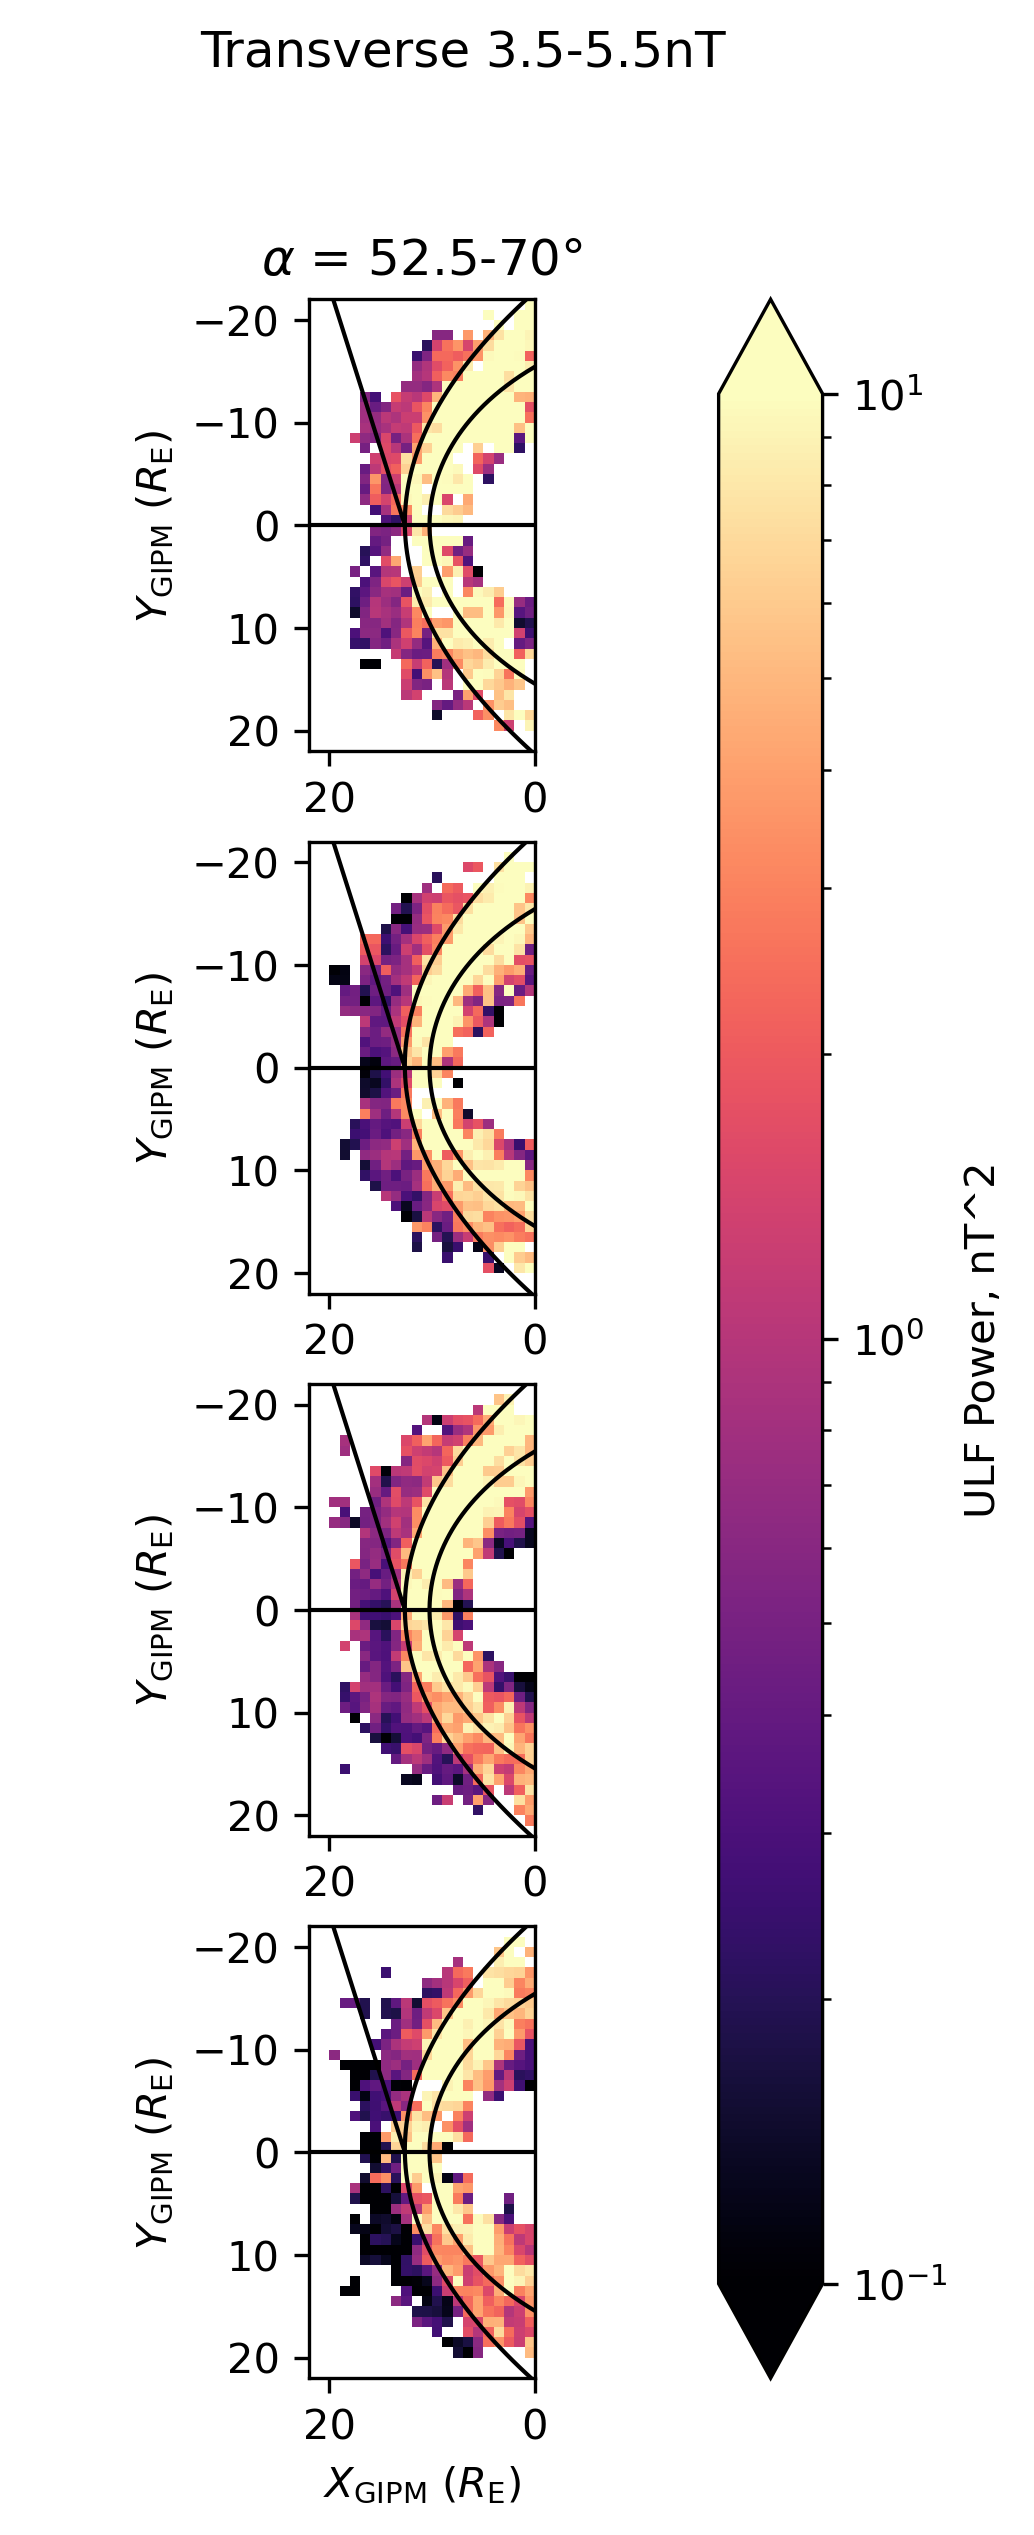

In [97]:
V_52_70_hists_perp = [mean_perp_spir_52_70_V4,mean_perp_spir_52_70_V3,mean_perp_spir_52_70_V2,mean_perp_spir_52_70_V1]
B_3p5_5p5 = [3.5,5.5]
B_angle_52_70 = [52.5,70]
Velocity_Plots(V_52_70_hists_perp, 'Transverse', B_3p5_5p5, B_angle_52_70)

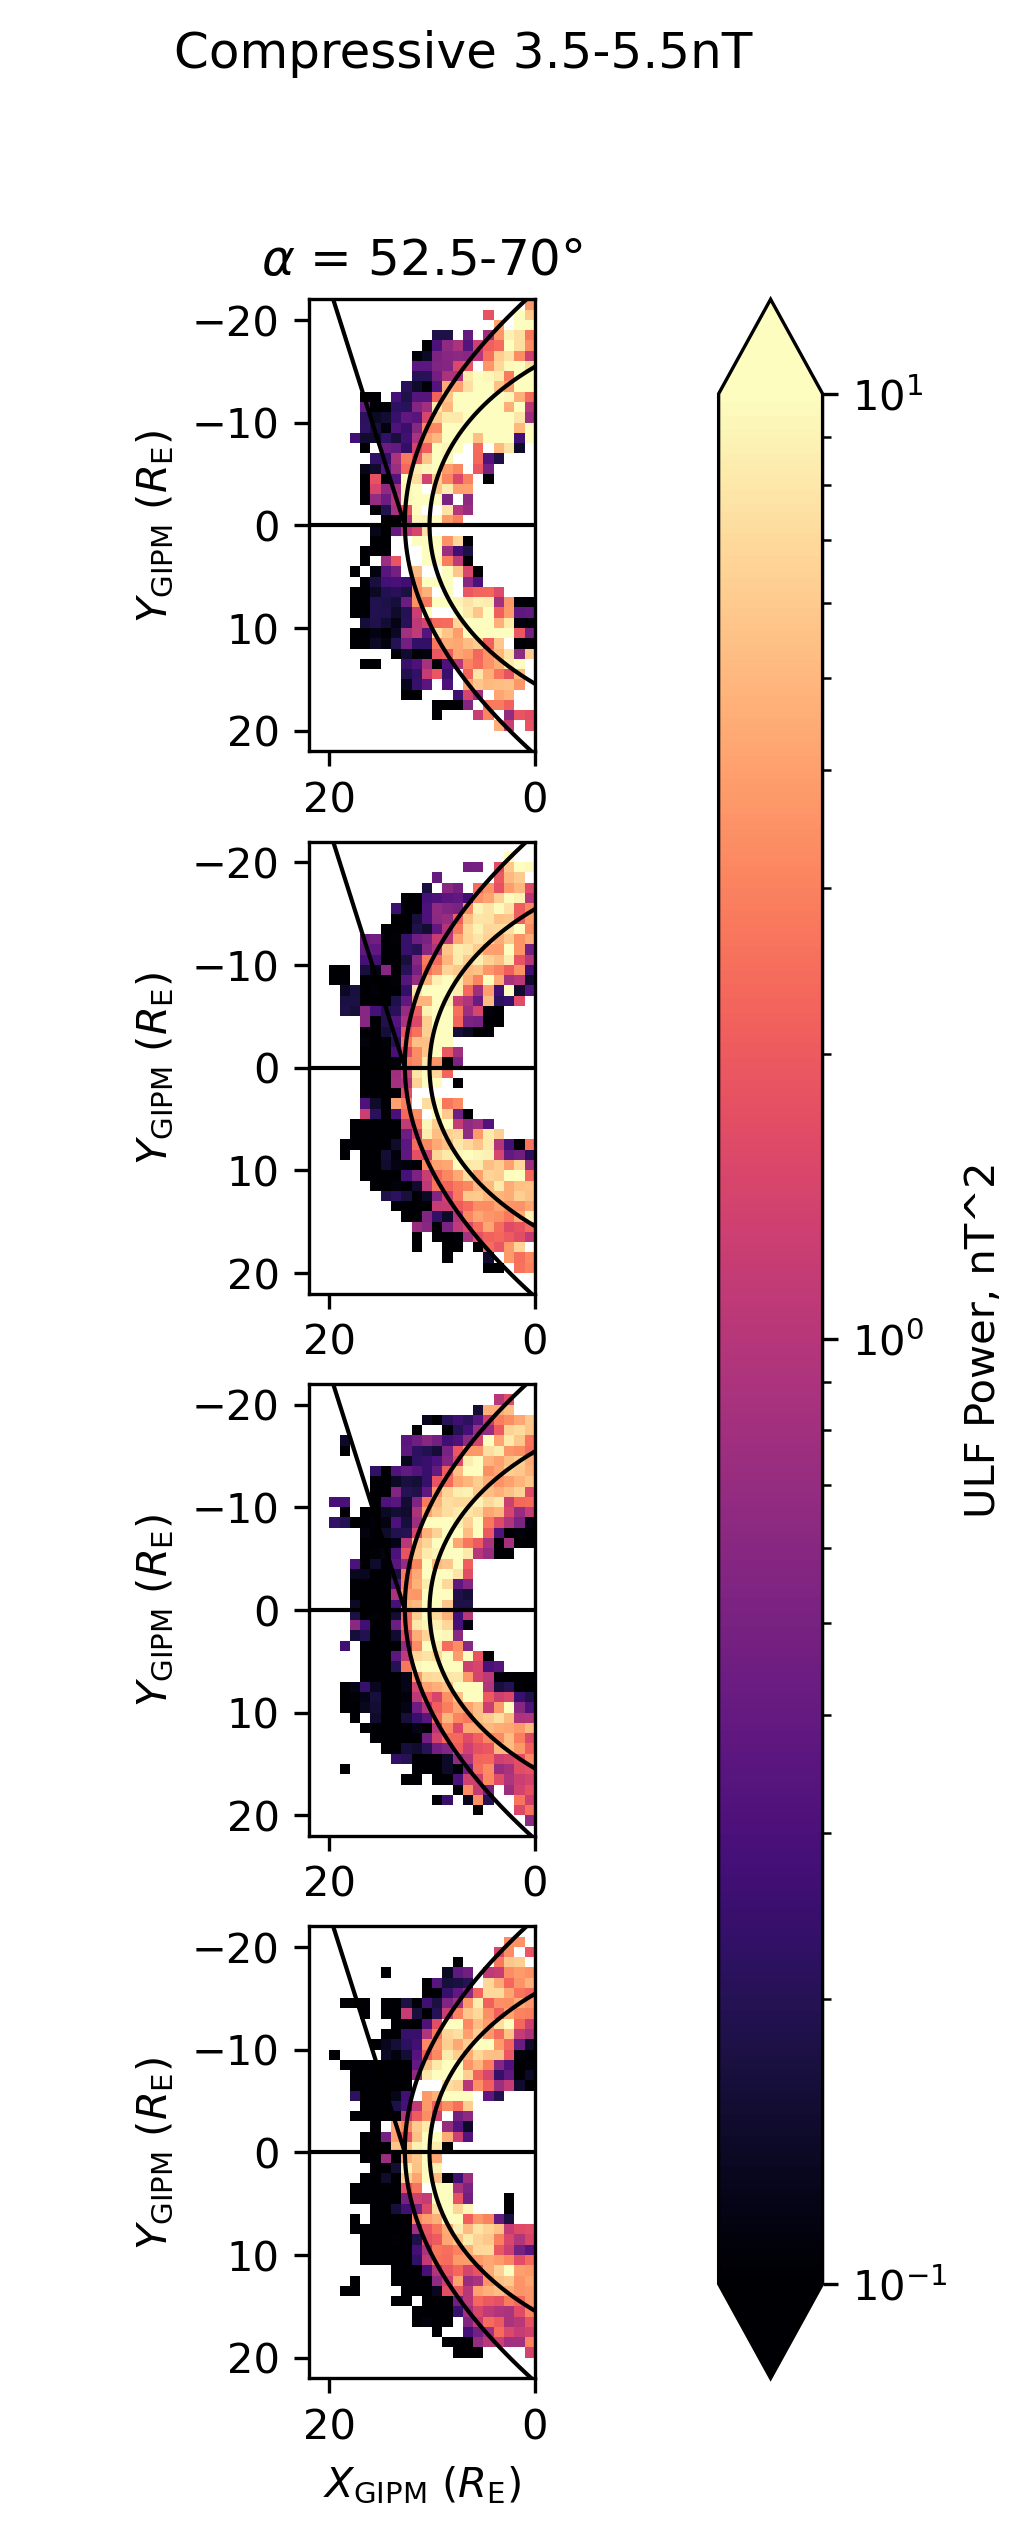

In [99]:
V_52_70_hists_para = [mean_para_spir_52_70_V4,mean_para_spir_52_70_V3,mean_para_spir_52_70_V2,mean_para_spir_52_70_V1]
B_3p5_5p5 = [3.5,5.5]
B_angle_52_70 = [52.5,70]
Velocity_Plots(V_52_70_hists_para, 'Compressive', B_3p5_5p5, B_angle_52_70)

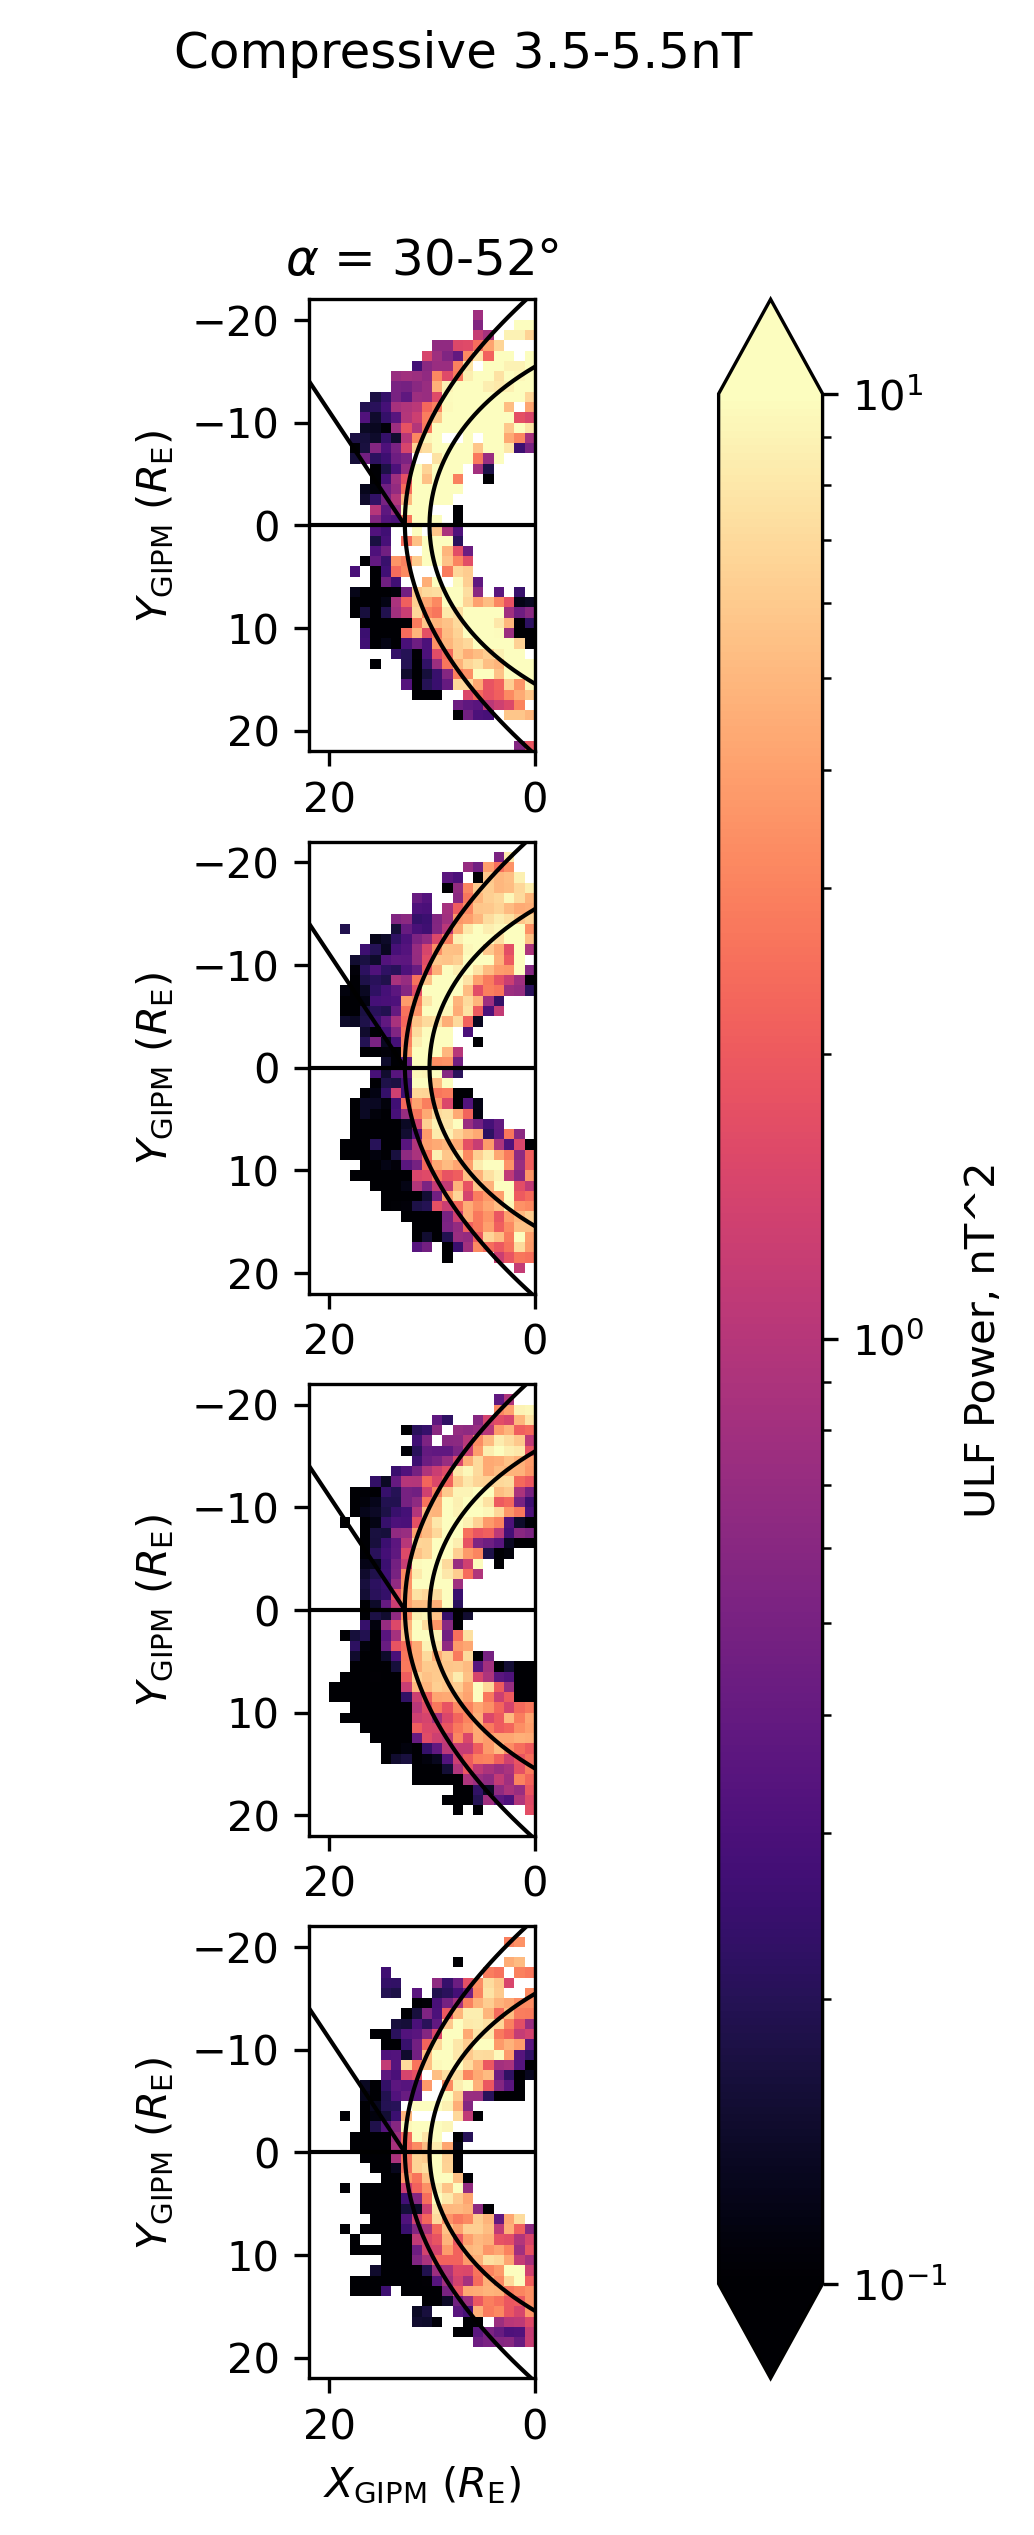

In [100]:
V_30_52_hists_para = [mean_para_spir_30_52_V4,mean_para_spir_30_52_V3,mean_para_spir_30_52_V2,mean_para_spir_30_52_V1]
Velocity_Plots(V_30_52_hists_para, 'Compressive', [3.5,5.5], [30,52])

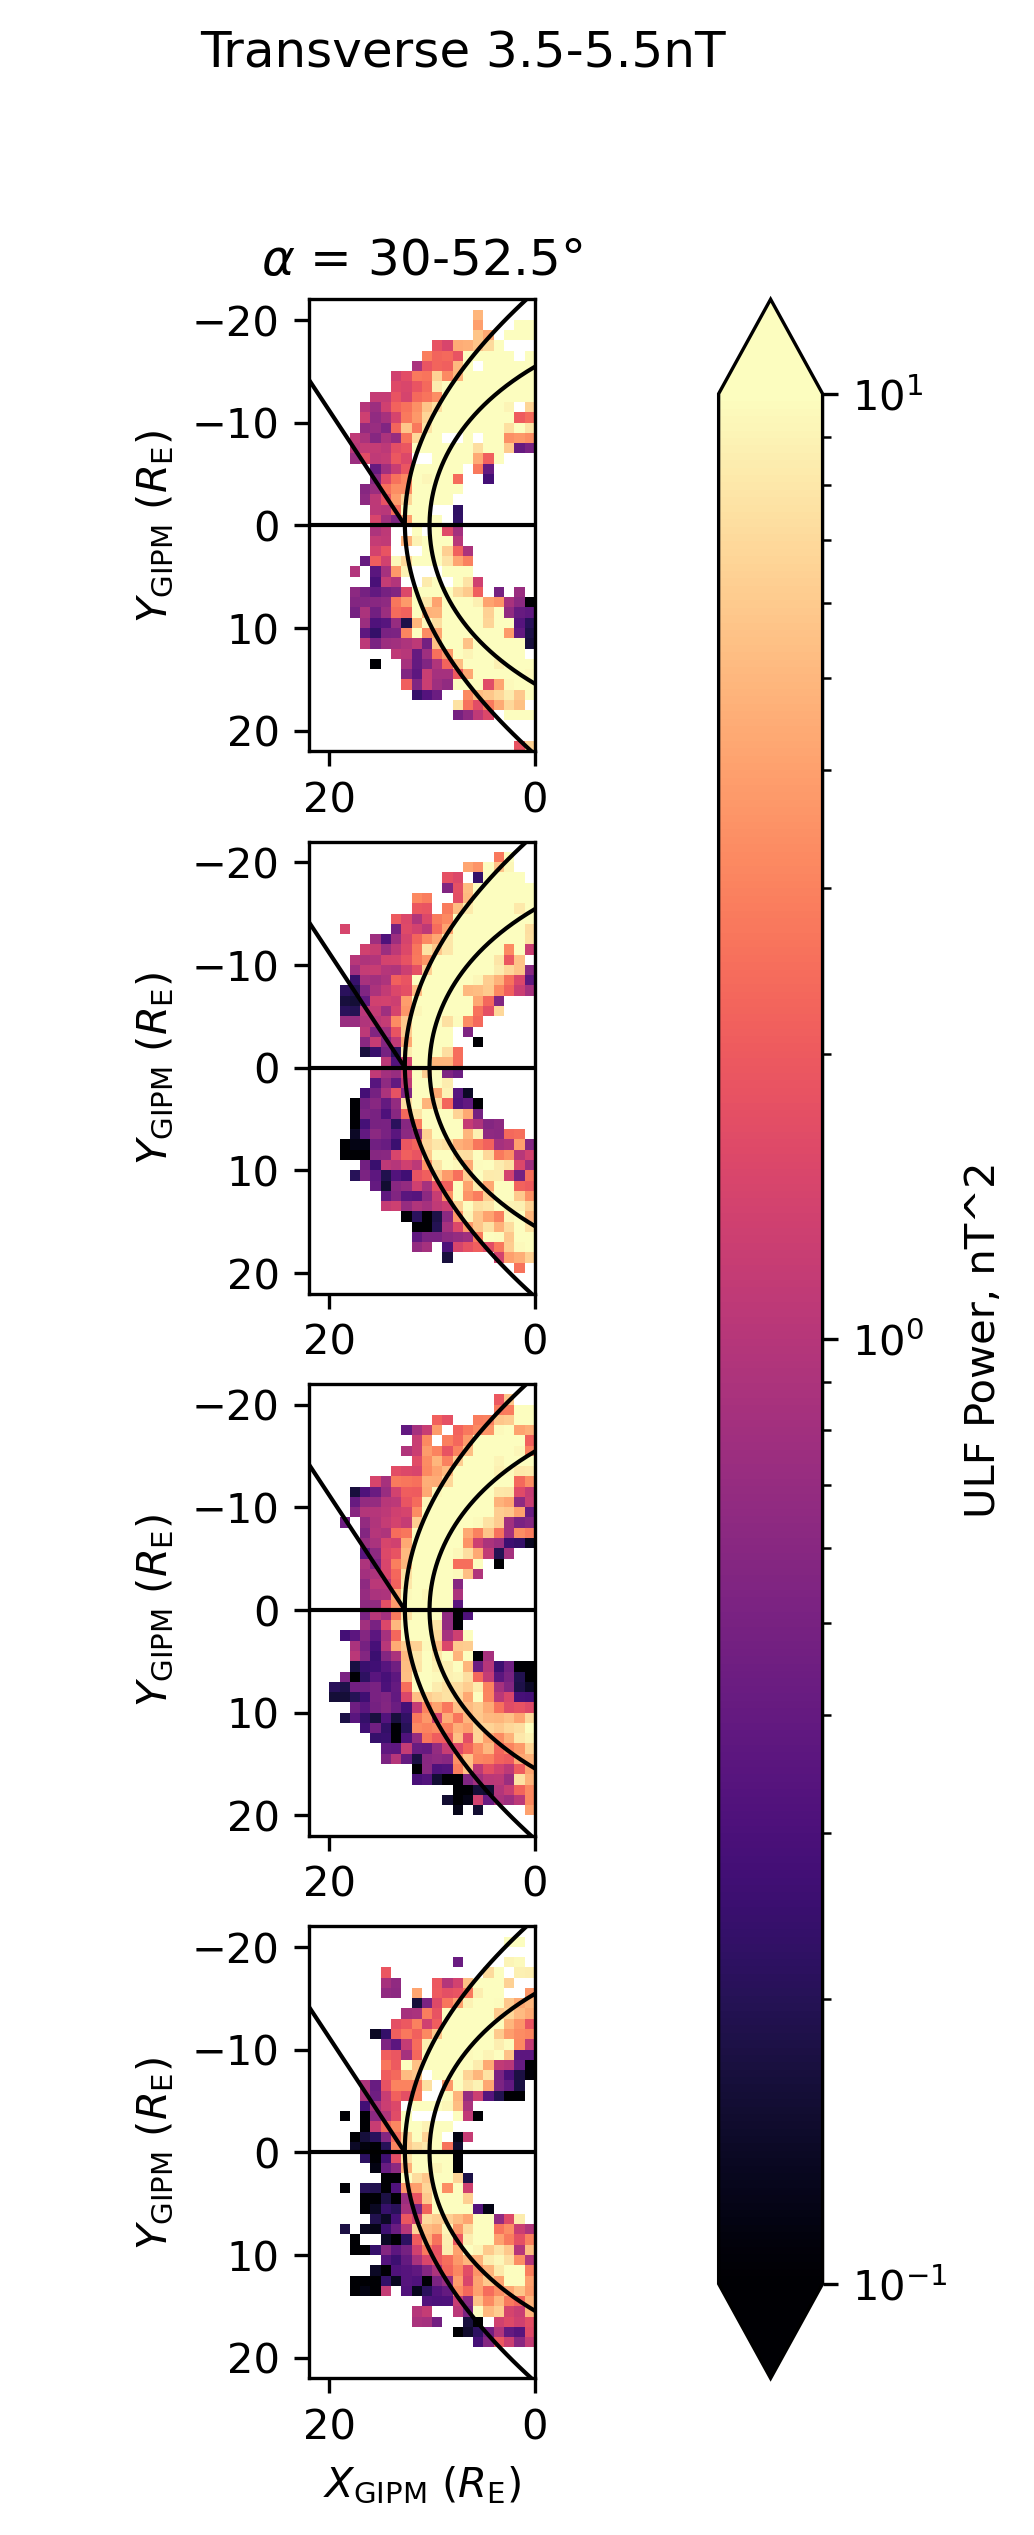

In [109]:
V_30_52_hists_perp = [mean_perp_spir_30_52_V4,mean_perp_spir_30_52_V3,mean_perp_spir_30_52_V2,mean_perp_spir_30_52_V1]
Velocity_Plots(V_30_52_hists_perp, 'Transverse', [3.5,5.5], [30,52.5])

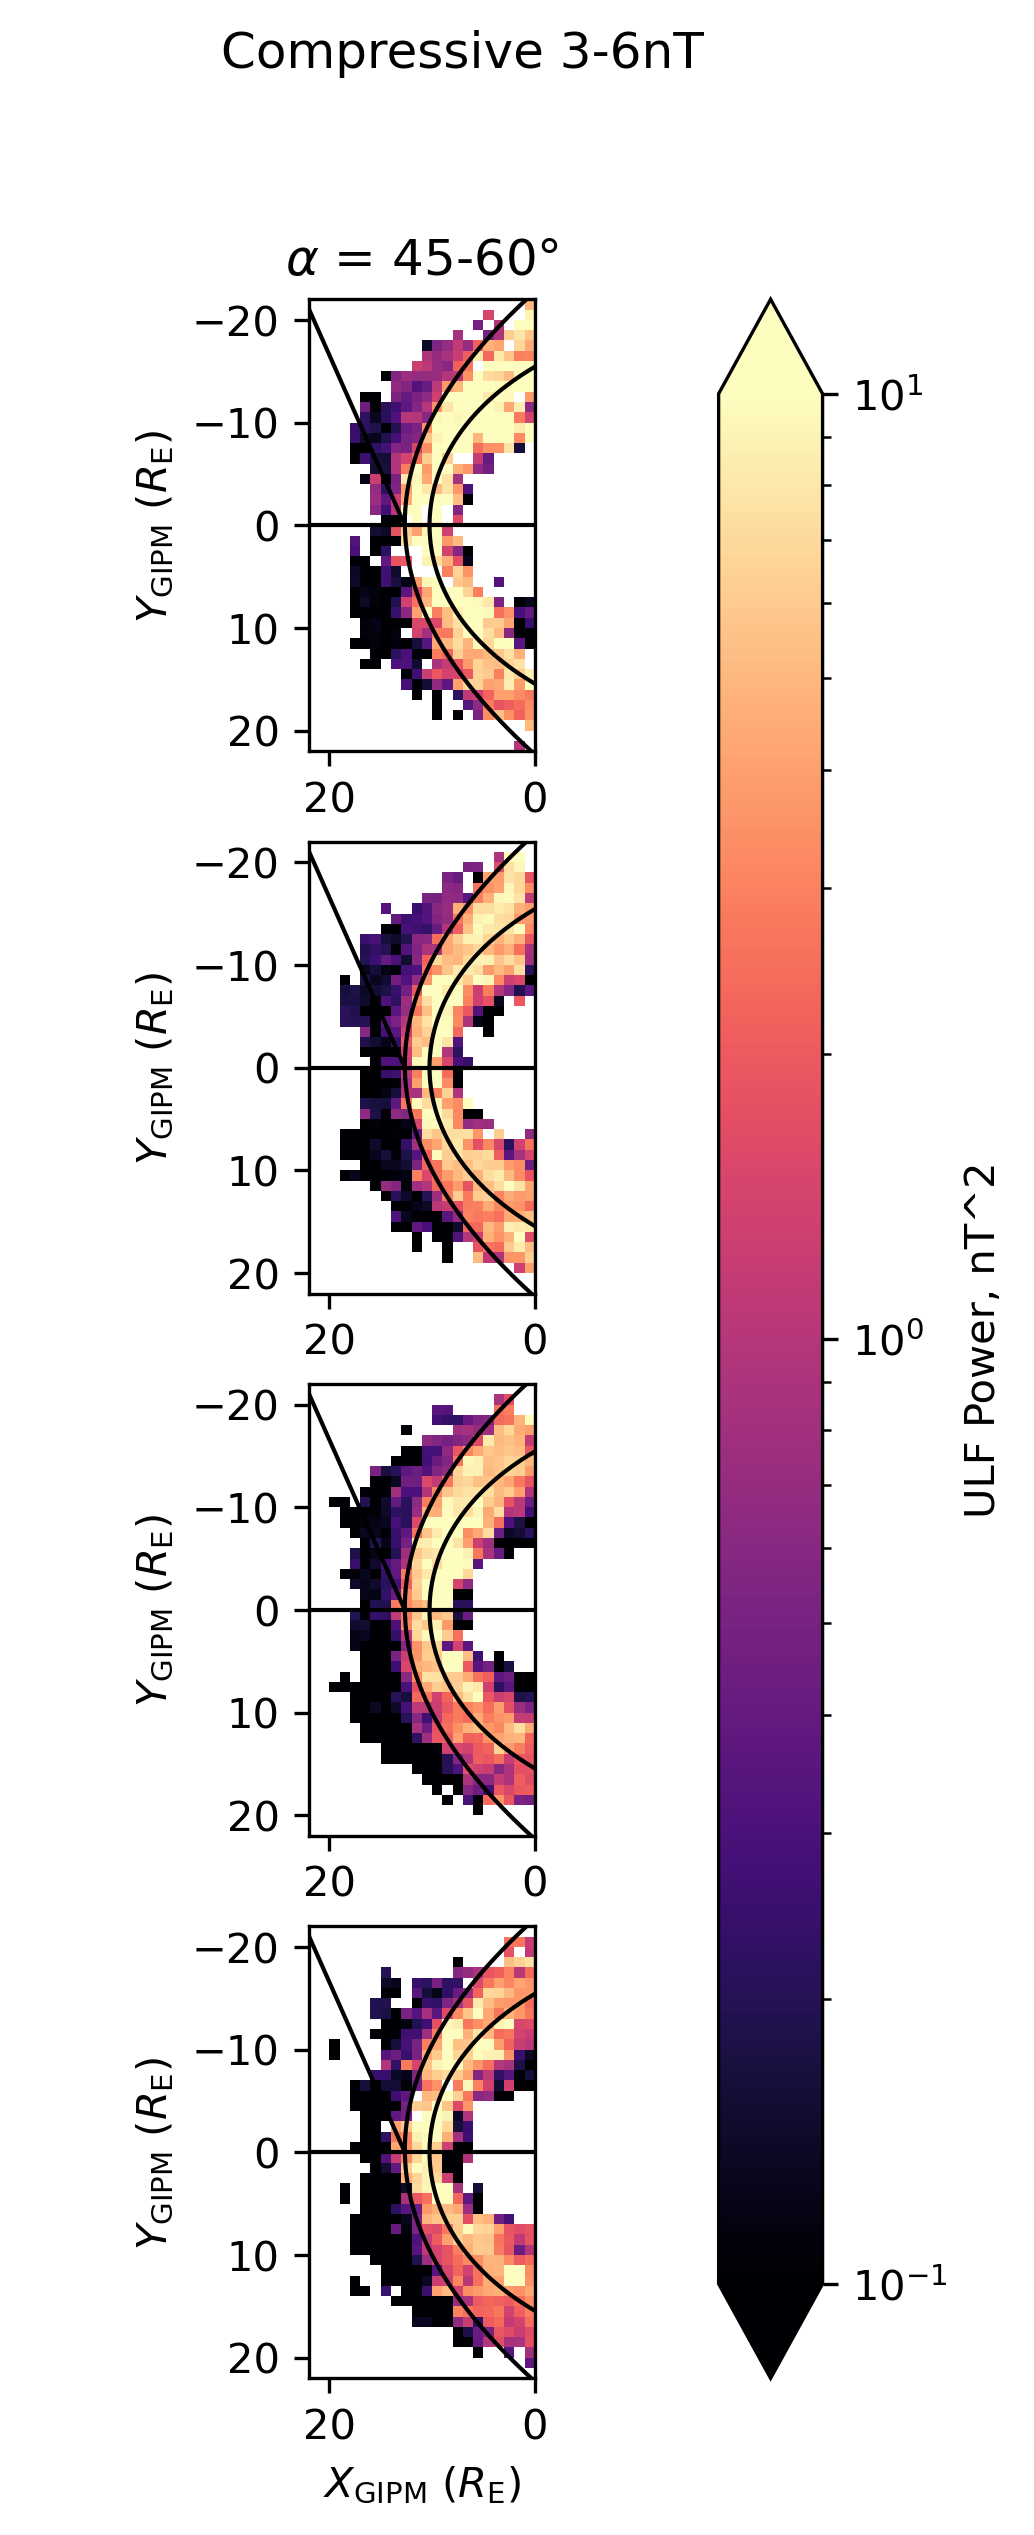

In [108]:
V_B_3_6_hists_para = [mean_para_highspir_V4_b, mean_para_highspir_V3_b,mean_para_highspir_V2_b,mean_para_highspir_V1_b]
Velocity_Plots(V_B_3_6_hists_para, 'Compressive', [3,6], [45,60])

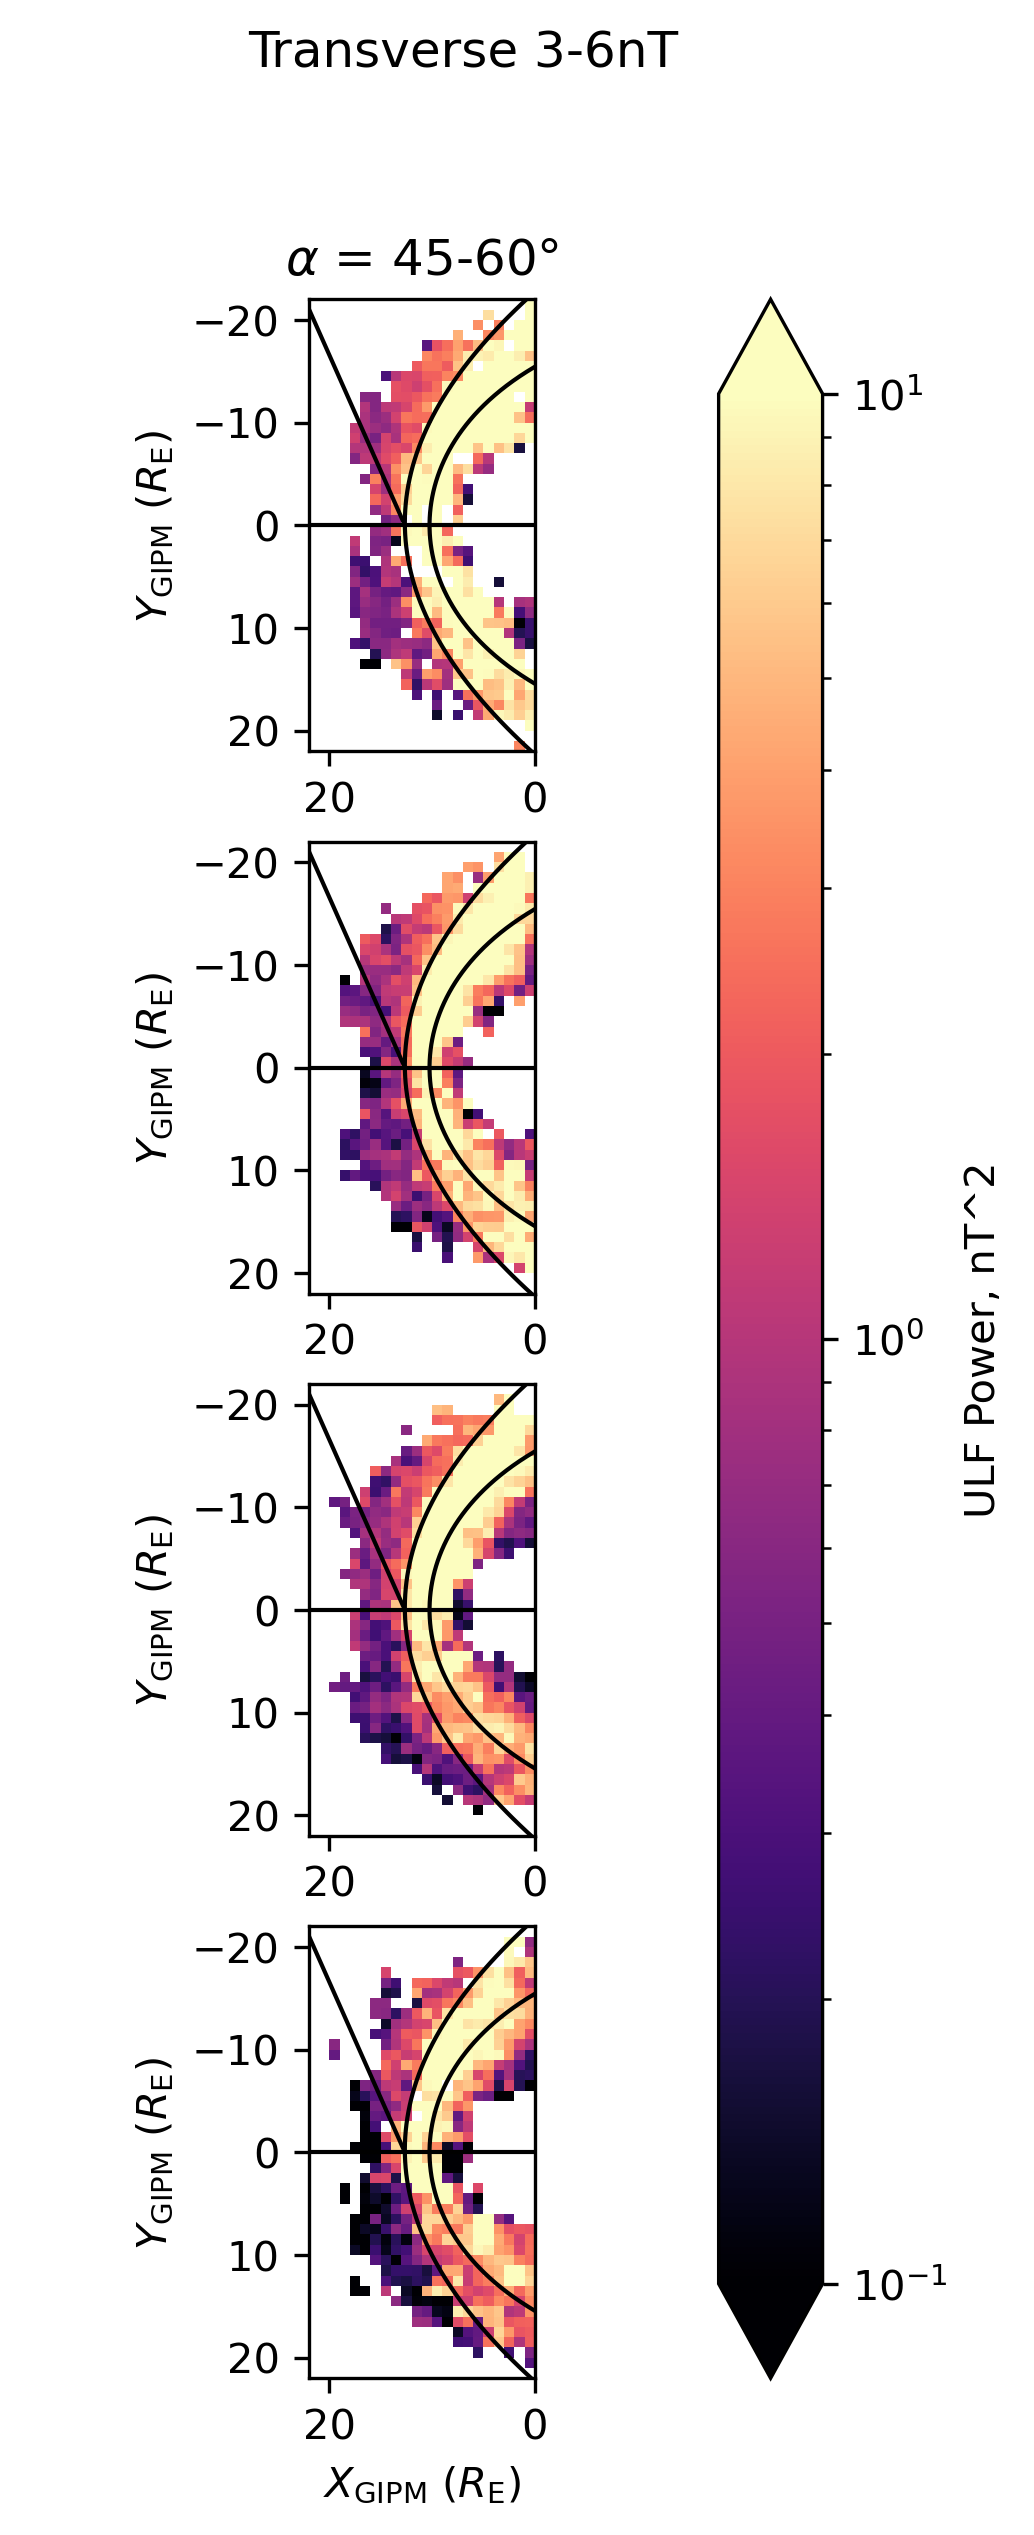

In [107]:
V_B_3_6_hists_perp = [mean_perp_highspir_V4_b, mean_perp_highspir_V3_b,mean_perp_highspir_V2_b,mean_perp_highspir_V1_b]
Velocity_Plots(V_B_3_6_hists_perp, 'Transverse', [3,6], [45,60])

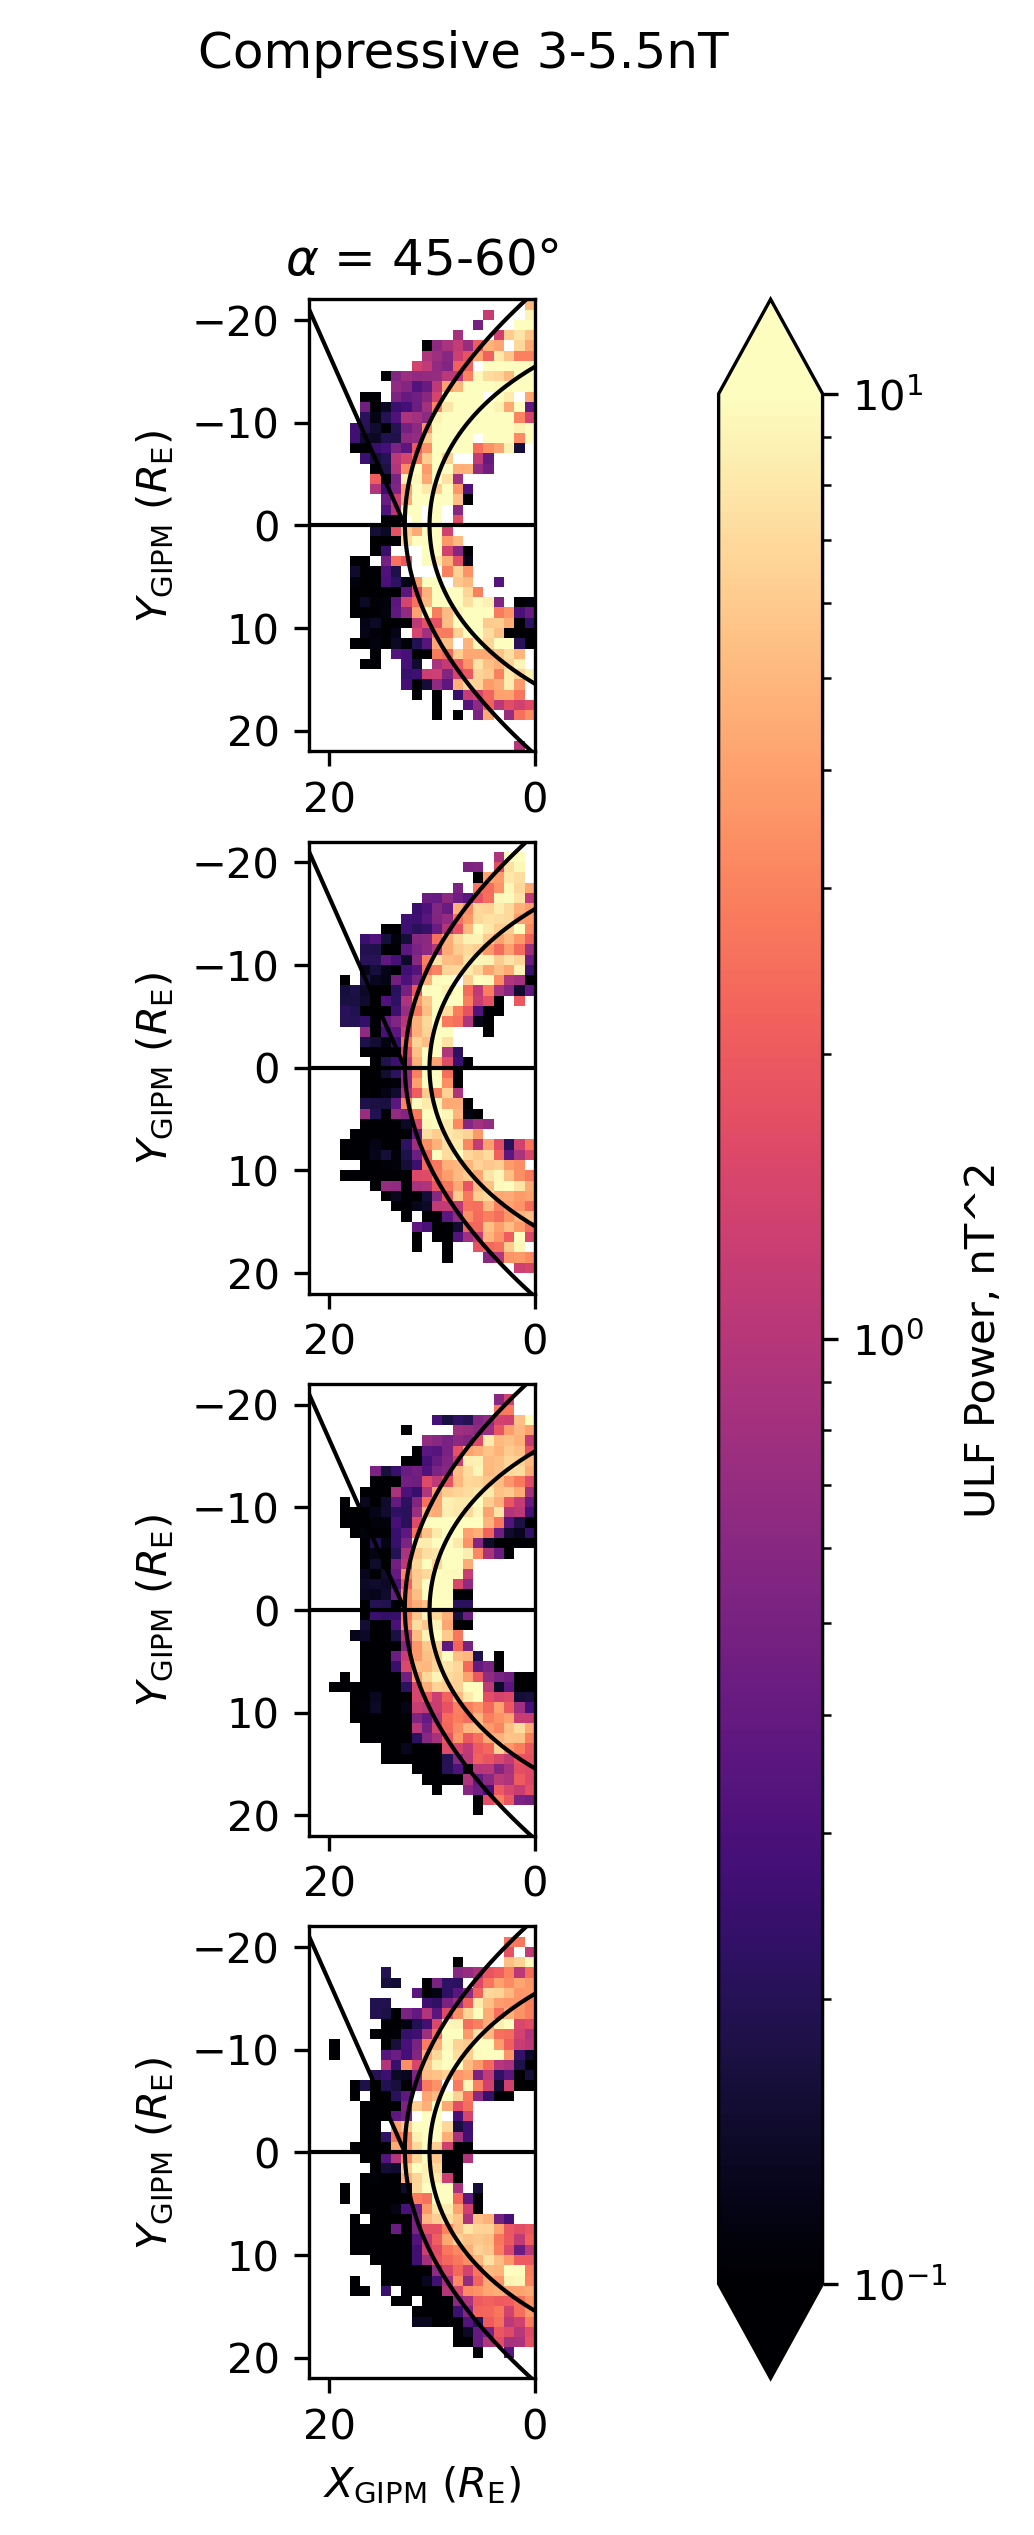

In [105]:
V_B_3_5p5_hists_para = [mean_para_highspir_V4_a, mean_para_highspir_V3_a,mean_para_highspir_V2_a,mean_para_highspir_V1_a]
Velocity_Plots(V_B_3_5p5_hists_para, 'Compressive', [3,5.5], [45,60])

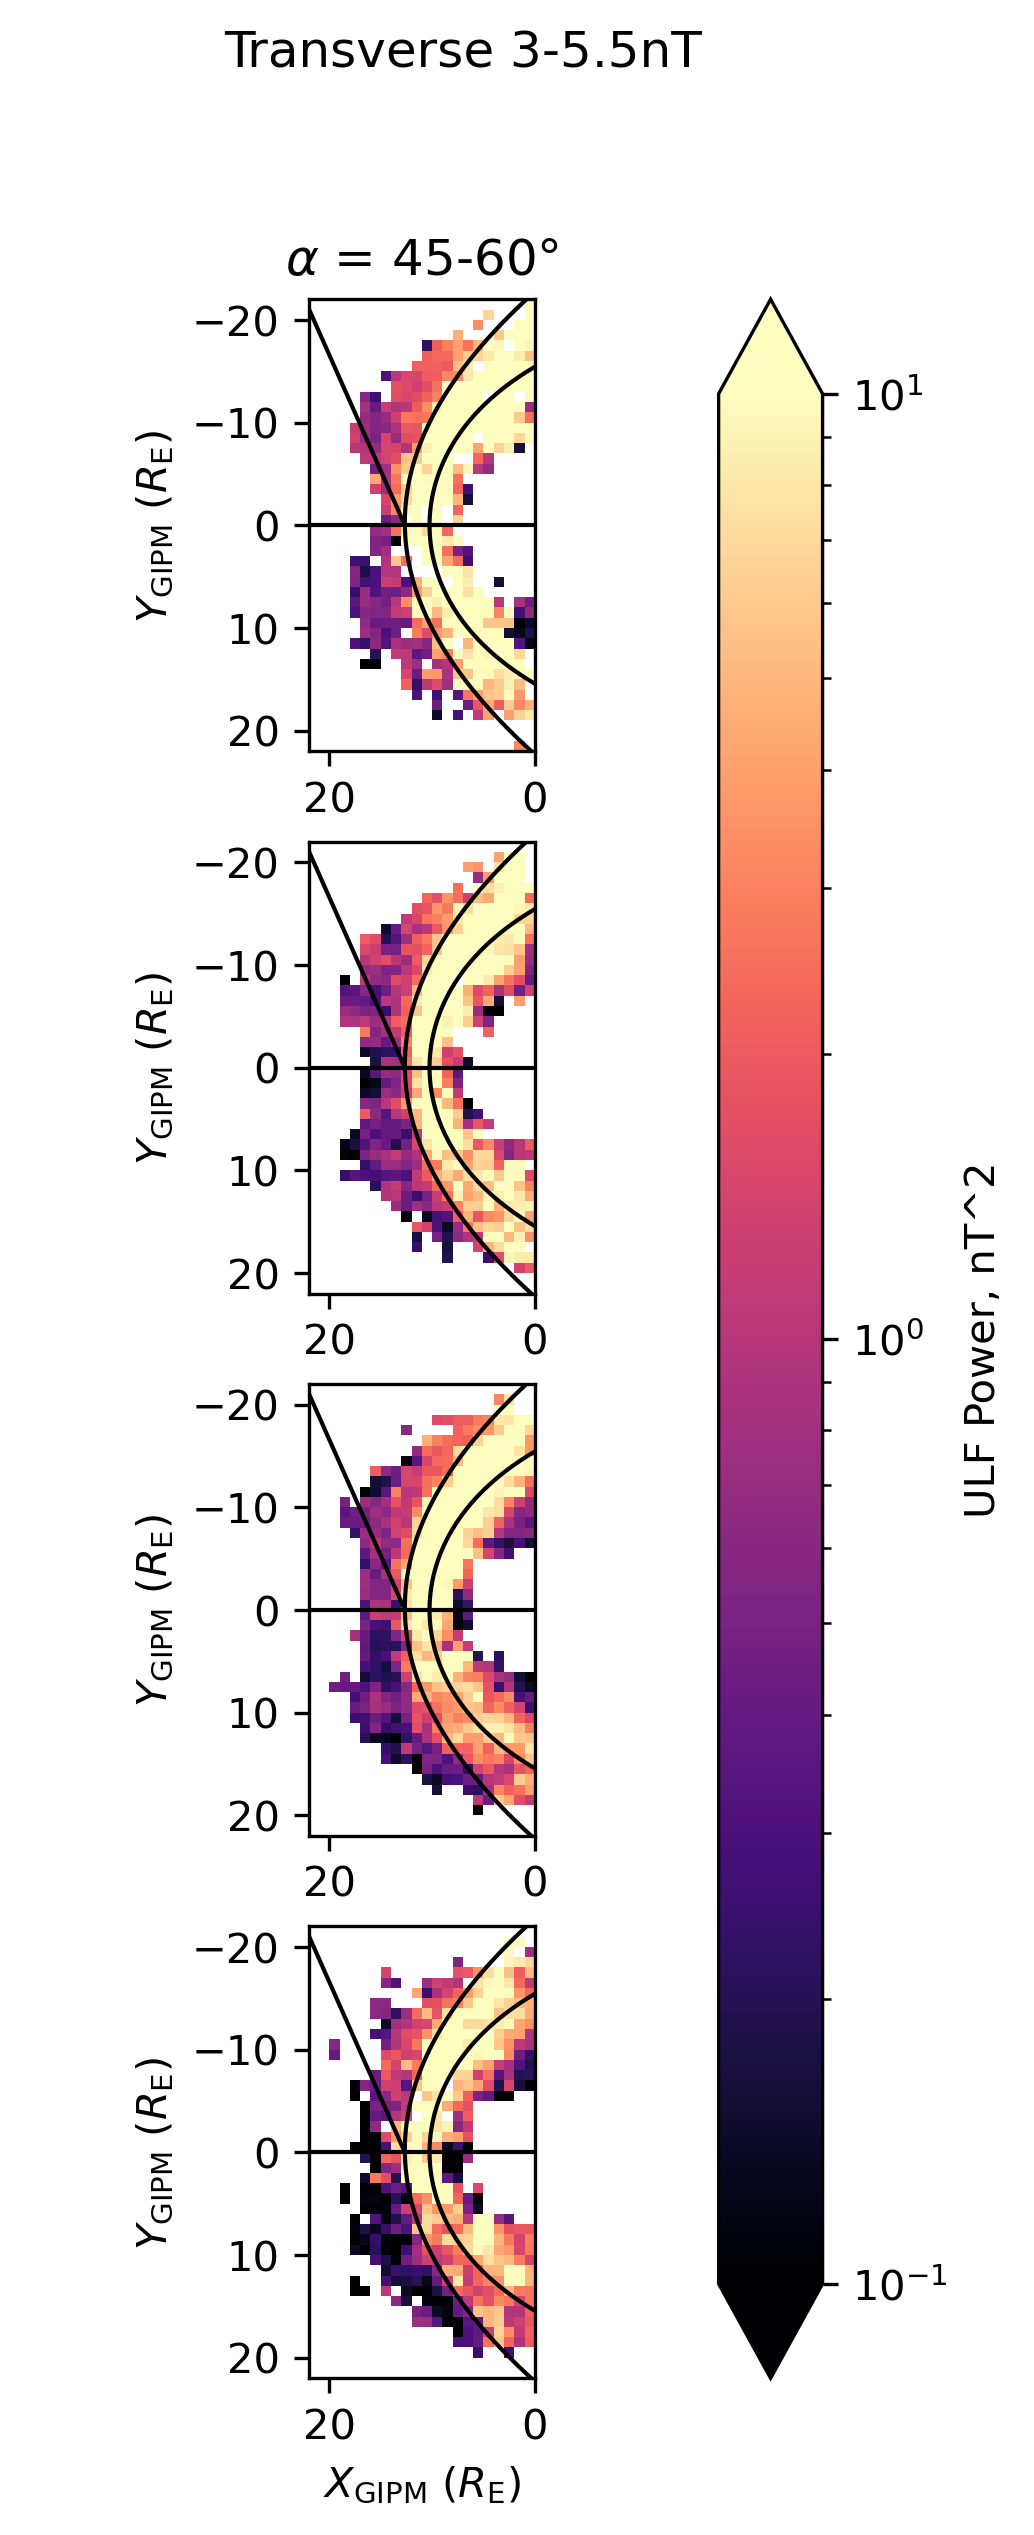

In [106]:
V_B_3_5p5_hists_perp = [mean_perp_highspir_V4_a, mean_perp_highspir_V3_a,mean_perp_highspir_V2_a,mean_perp_highspir_V1_a]
Velocity_Plots(V_B_3_5p5_hists_perp, 'Transverse', [3,5.5], [45,60])

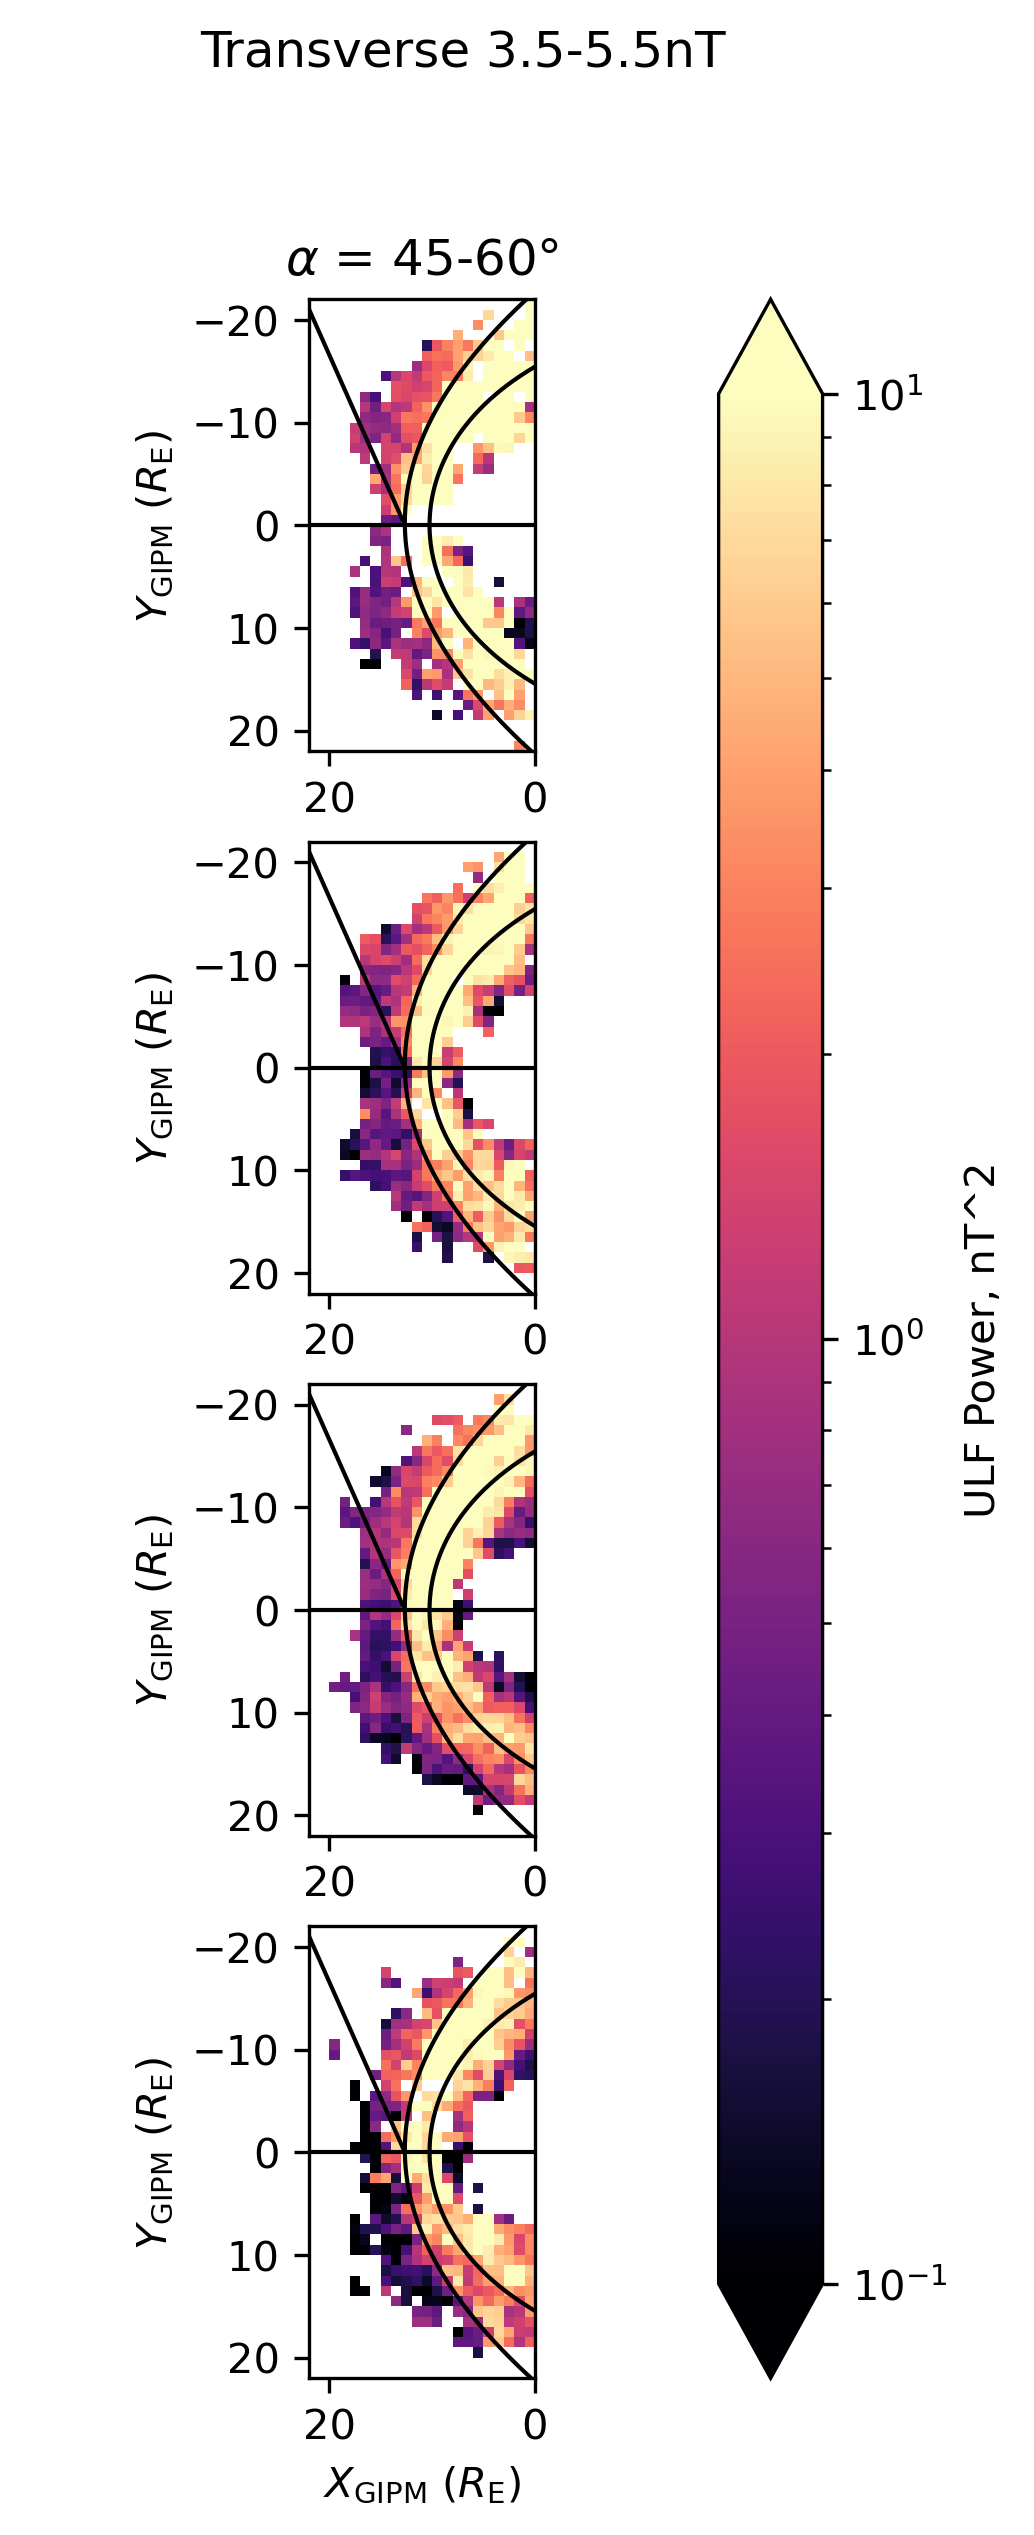

In [110]:
V_B_3p5_5p5_hists_perp = [mean_perp_highspir_V4, mean_perp_highspir_V3,mean_perp_highspir_V2,mean_perp_highspir_V1]
Velocity_Plots(V_B_3p5_5p5_hists_perp, 'Transverse', [3.5,5.5], [45,60])

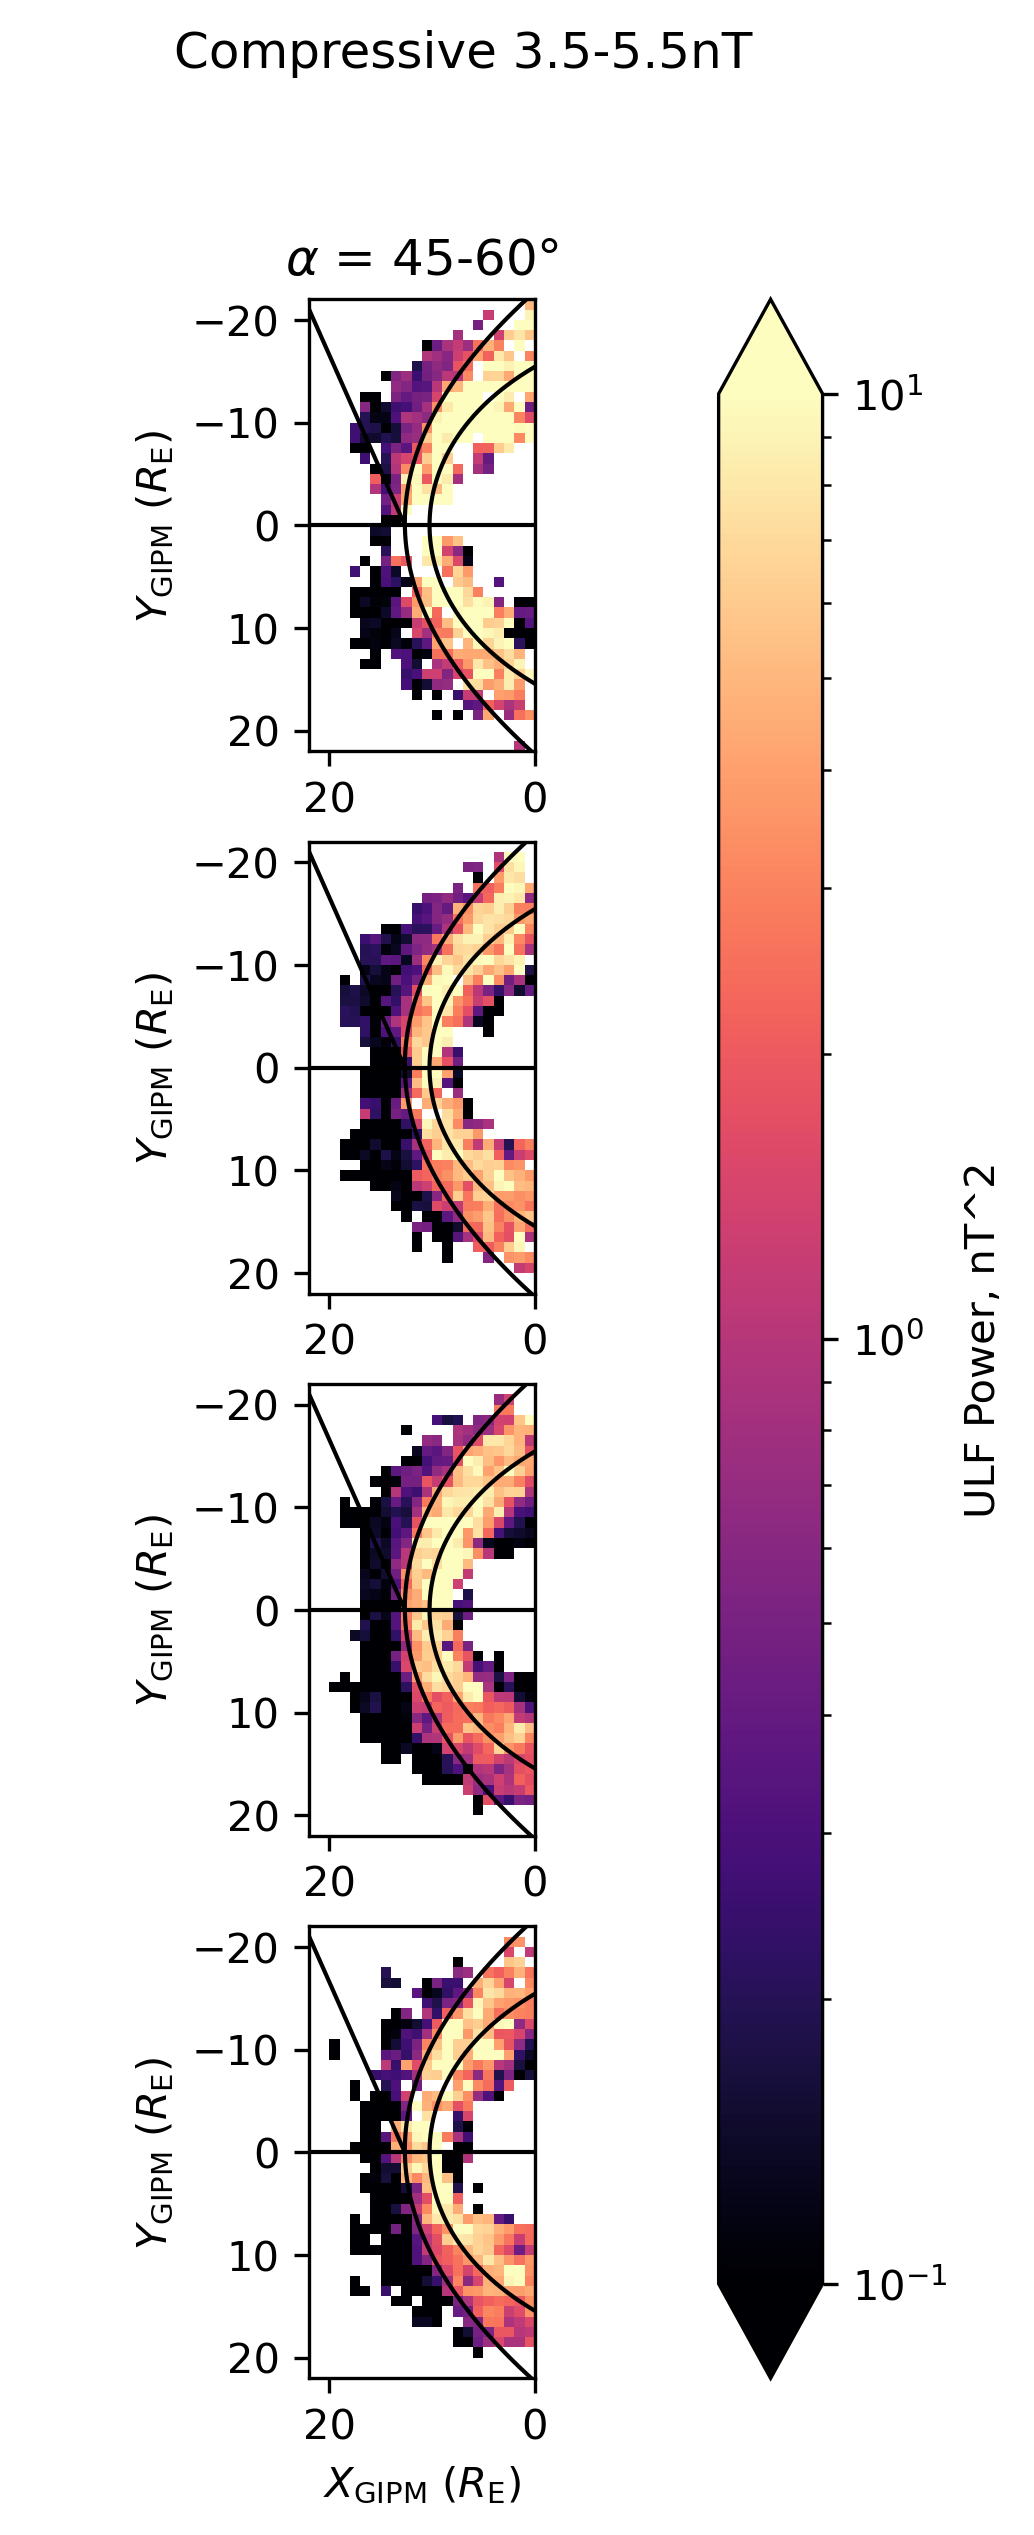

In [111]:
V_B_3p5_5p5_hists_para = [mean_para_highspir_V4, mean_para_highspir_V3,mean_para_highspir_V2,mean_para_highspir_V1]
Velocity_Plots(V_B_3p5_5p5_hists_para, 'Compressive', [3.5,5.5], [45,60])

In [114]:
list_of_df_lists_3p5_5p5 = [dt_list_V4, dt_list_V3, dt_list_V2, dt_list_V1]
list_of_df_lists_3_5p5 = [dt_list_V4_a, dt_list_V3_a, dt_list_V2_a, dt_list_V1_a]
list_of_df_lists_3_6 = [dt_list_V4_b, dt_list_V3_b, dt_list_V2_b, dt_list_V1_b]

para_hists_30_52_3_5p5, perp_hists_30_52_3_5p5, ratio_hists_30_52_3_5p5 = Velocity_Hists(df_30_52_lowZ, list_of_df_lists_3_5p5) 
para_hists_30_52_3_6, perp_hists_30_52_3_6, ratio_hists_30_52_3_6 = Velocity_Hists(df_30_52_lowZ, list_of_df_lists_3_6)


In [115]:
para_hists_52_70_3_5p5, perp_hists_52_70_3_5p5, ratio_hists_52_70_3_5p5 = Velocity_Hists(df_52_70_lowZ, list_of_df_lists_3_5p5) 
para_hists_52_70_3_6, perp_hists_52_70_3_6, ratio_hists_52_70_3_6 = Velocity_Hists(df_52_70_lowZ, list_of_df_lists_3_6)

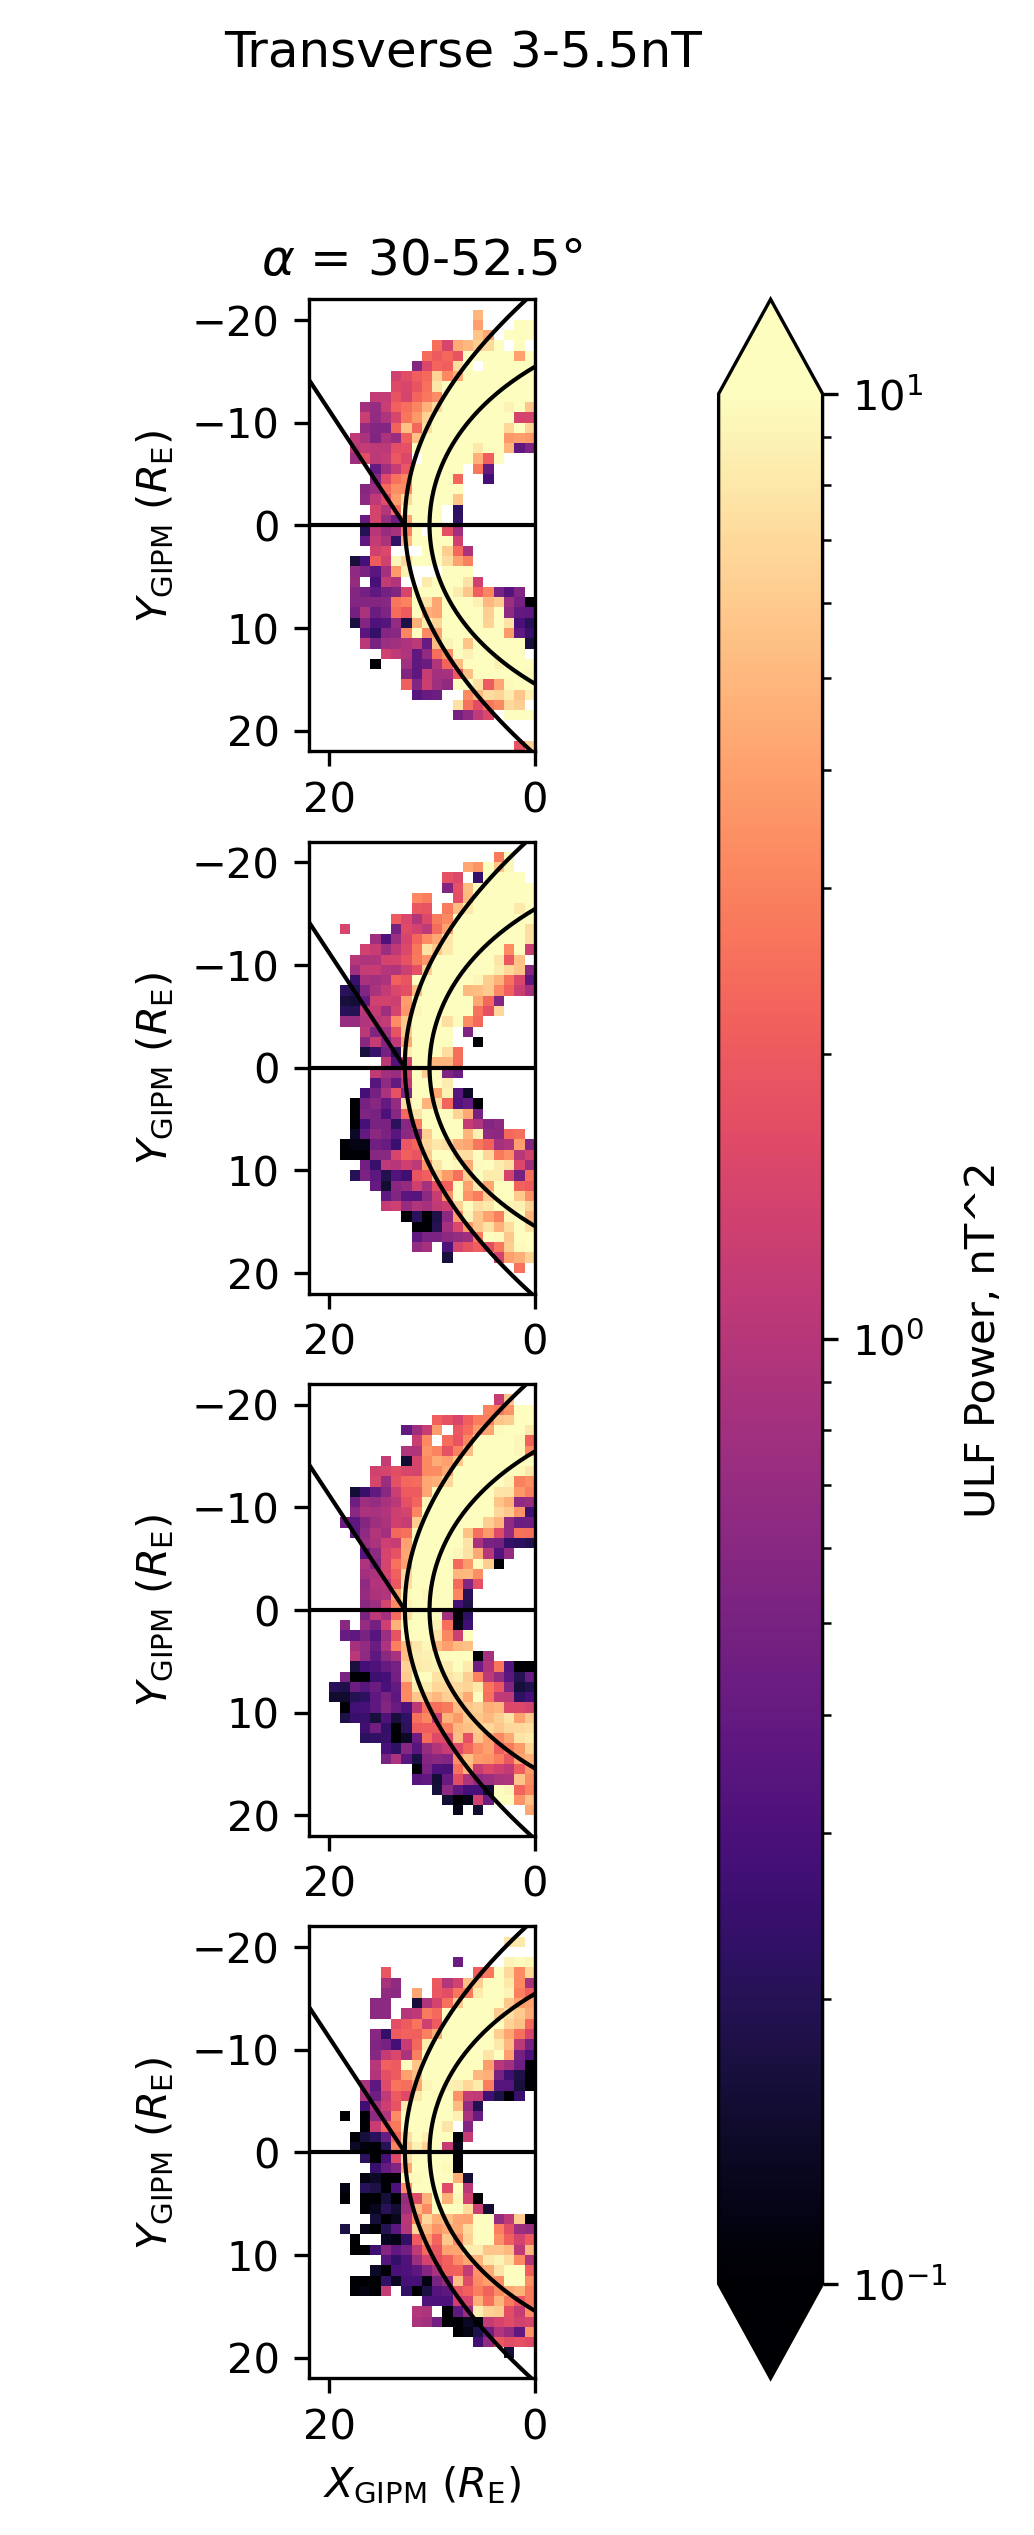

In [116]:
Velocity_Plots(perp_hists_30_52_3_5p5, 'Transverse', [3,5.5], [30,52.5])

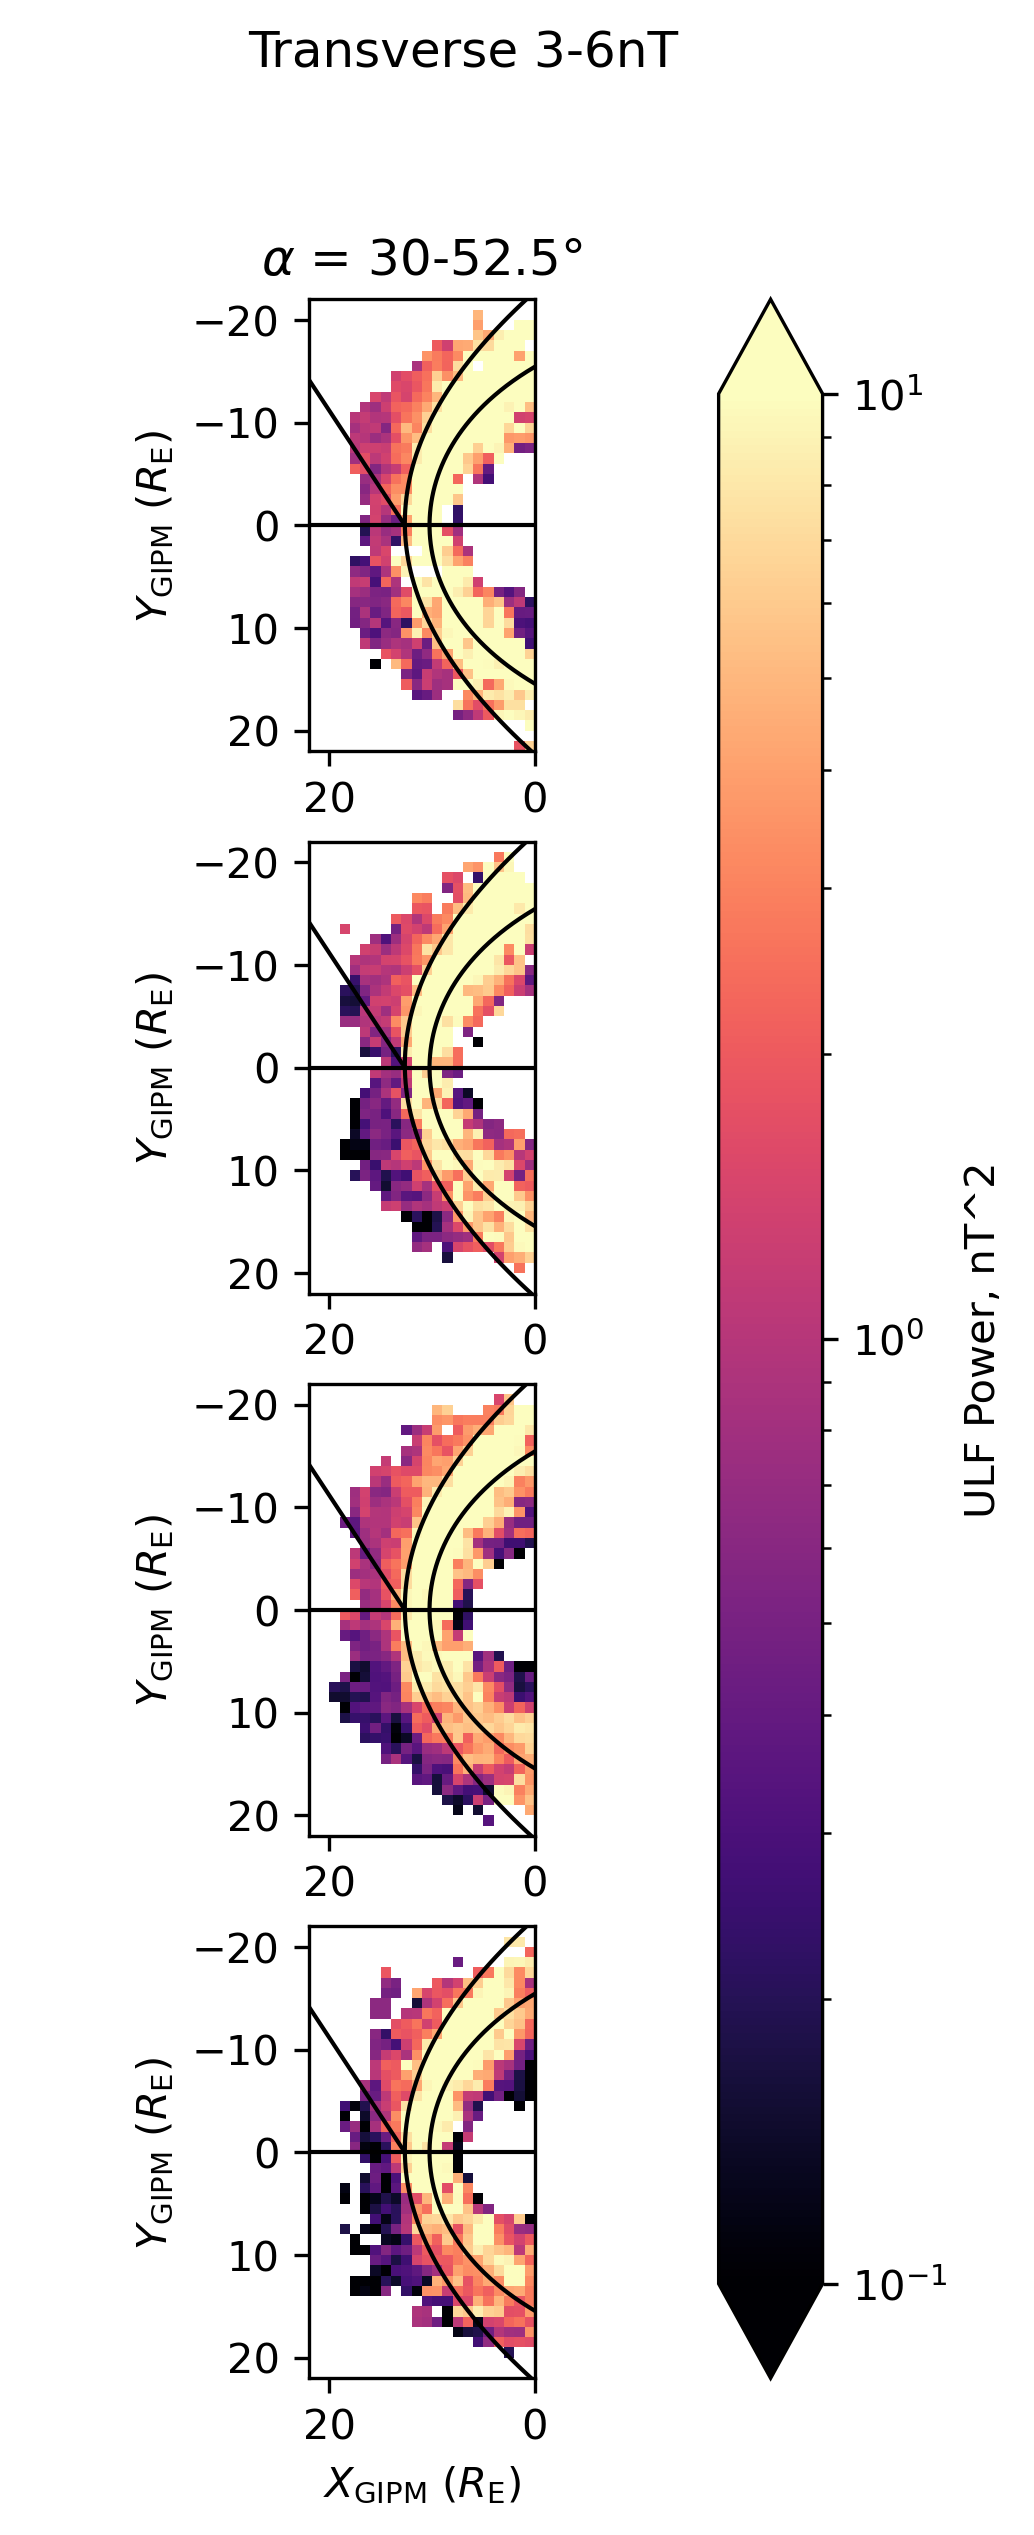

In [117]:
Velocity_Plots(perp_hists_30_52_3_6, 'Transverse', [3,6], [30,52.5])

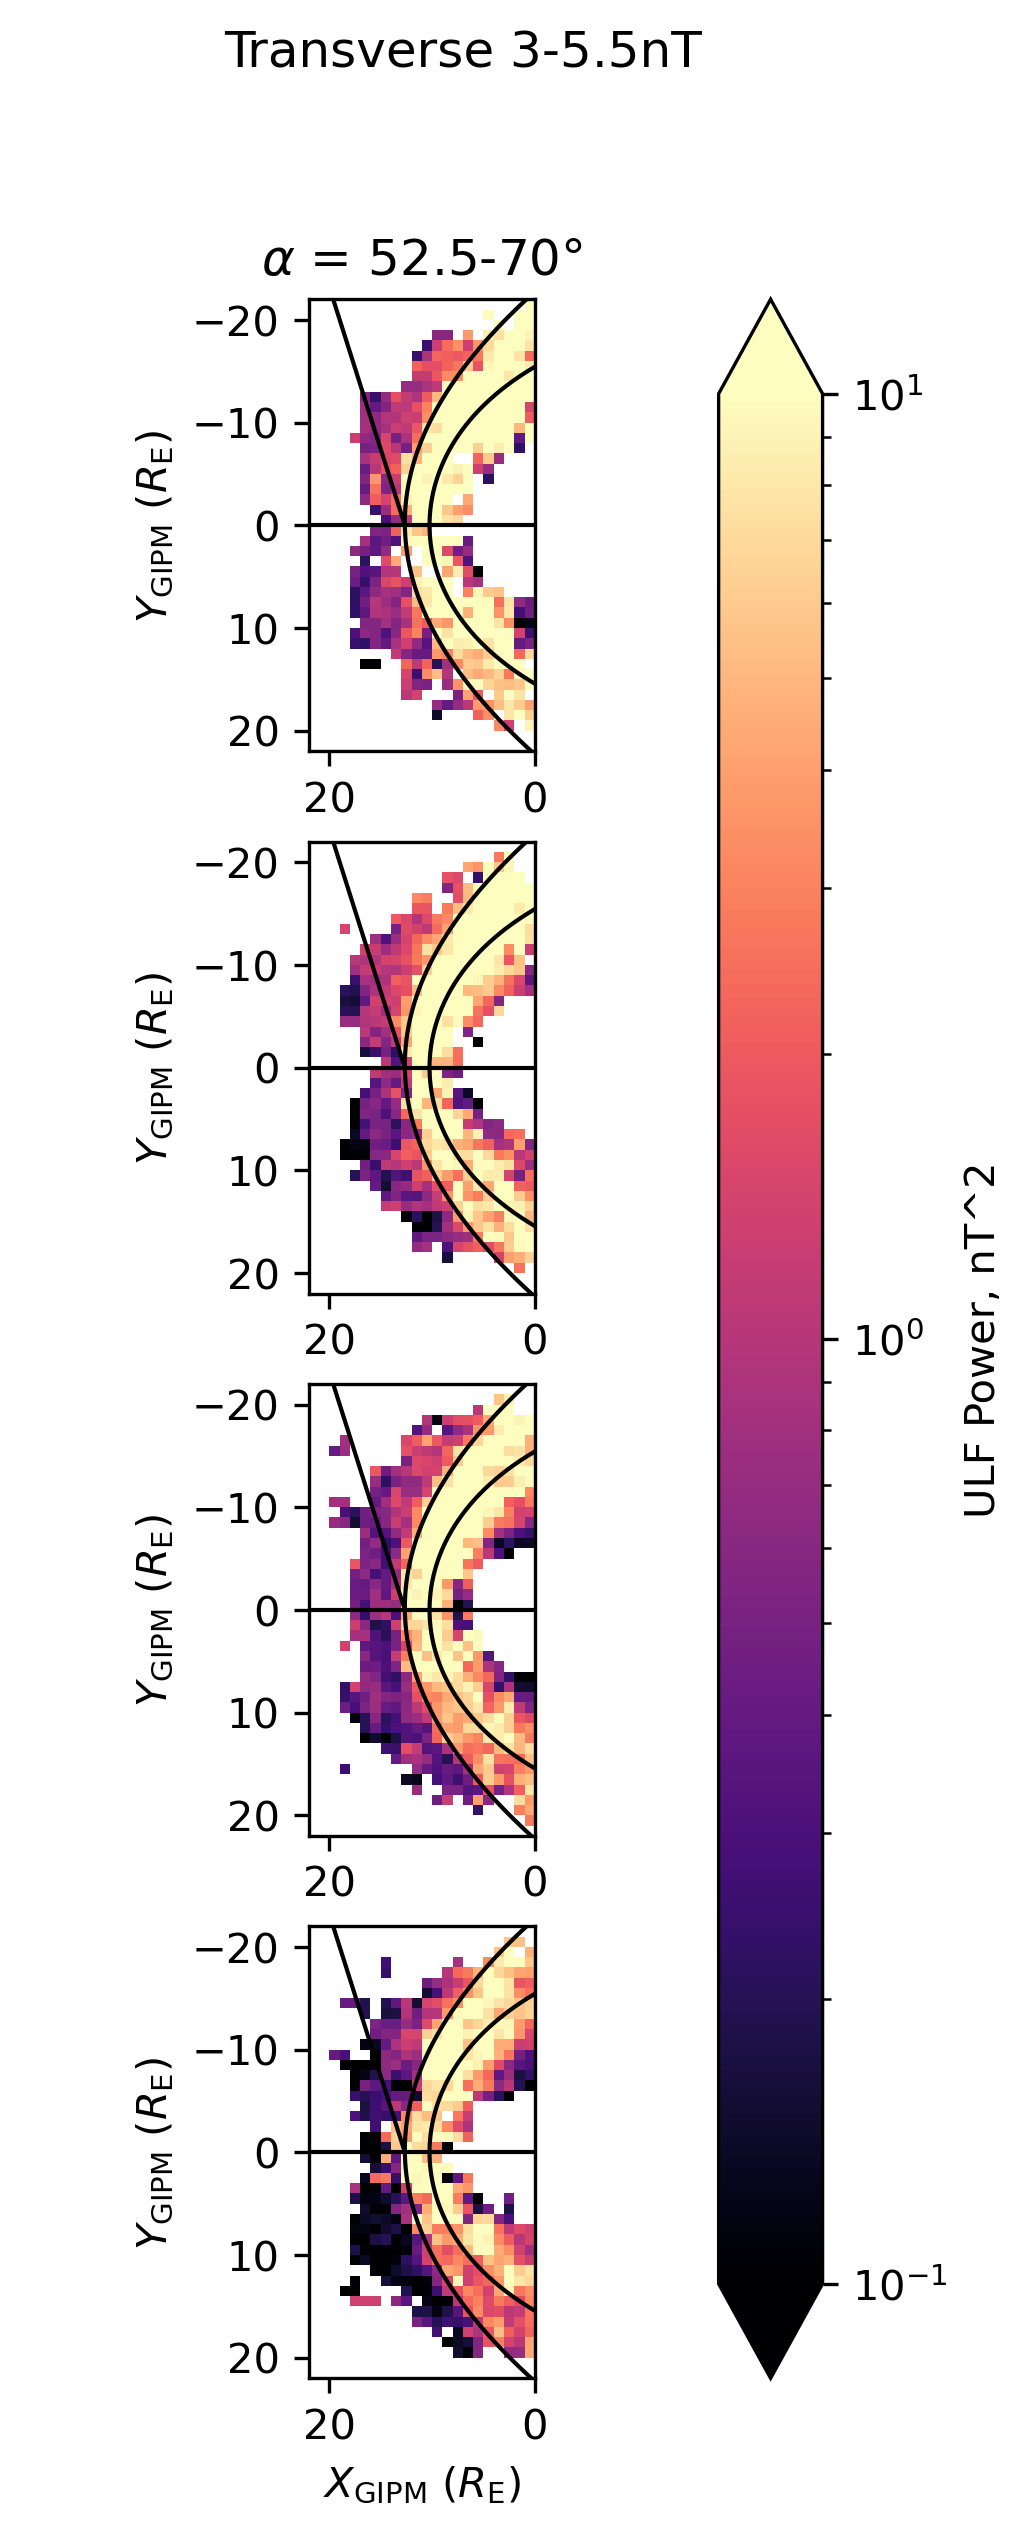

In [118]:
Velocity_Plots(perp_hists_52_70_3_5p5, 'Transverse', [3,5.5], [52.5,70])

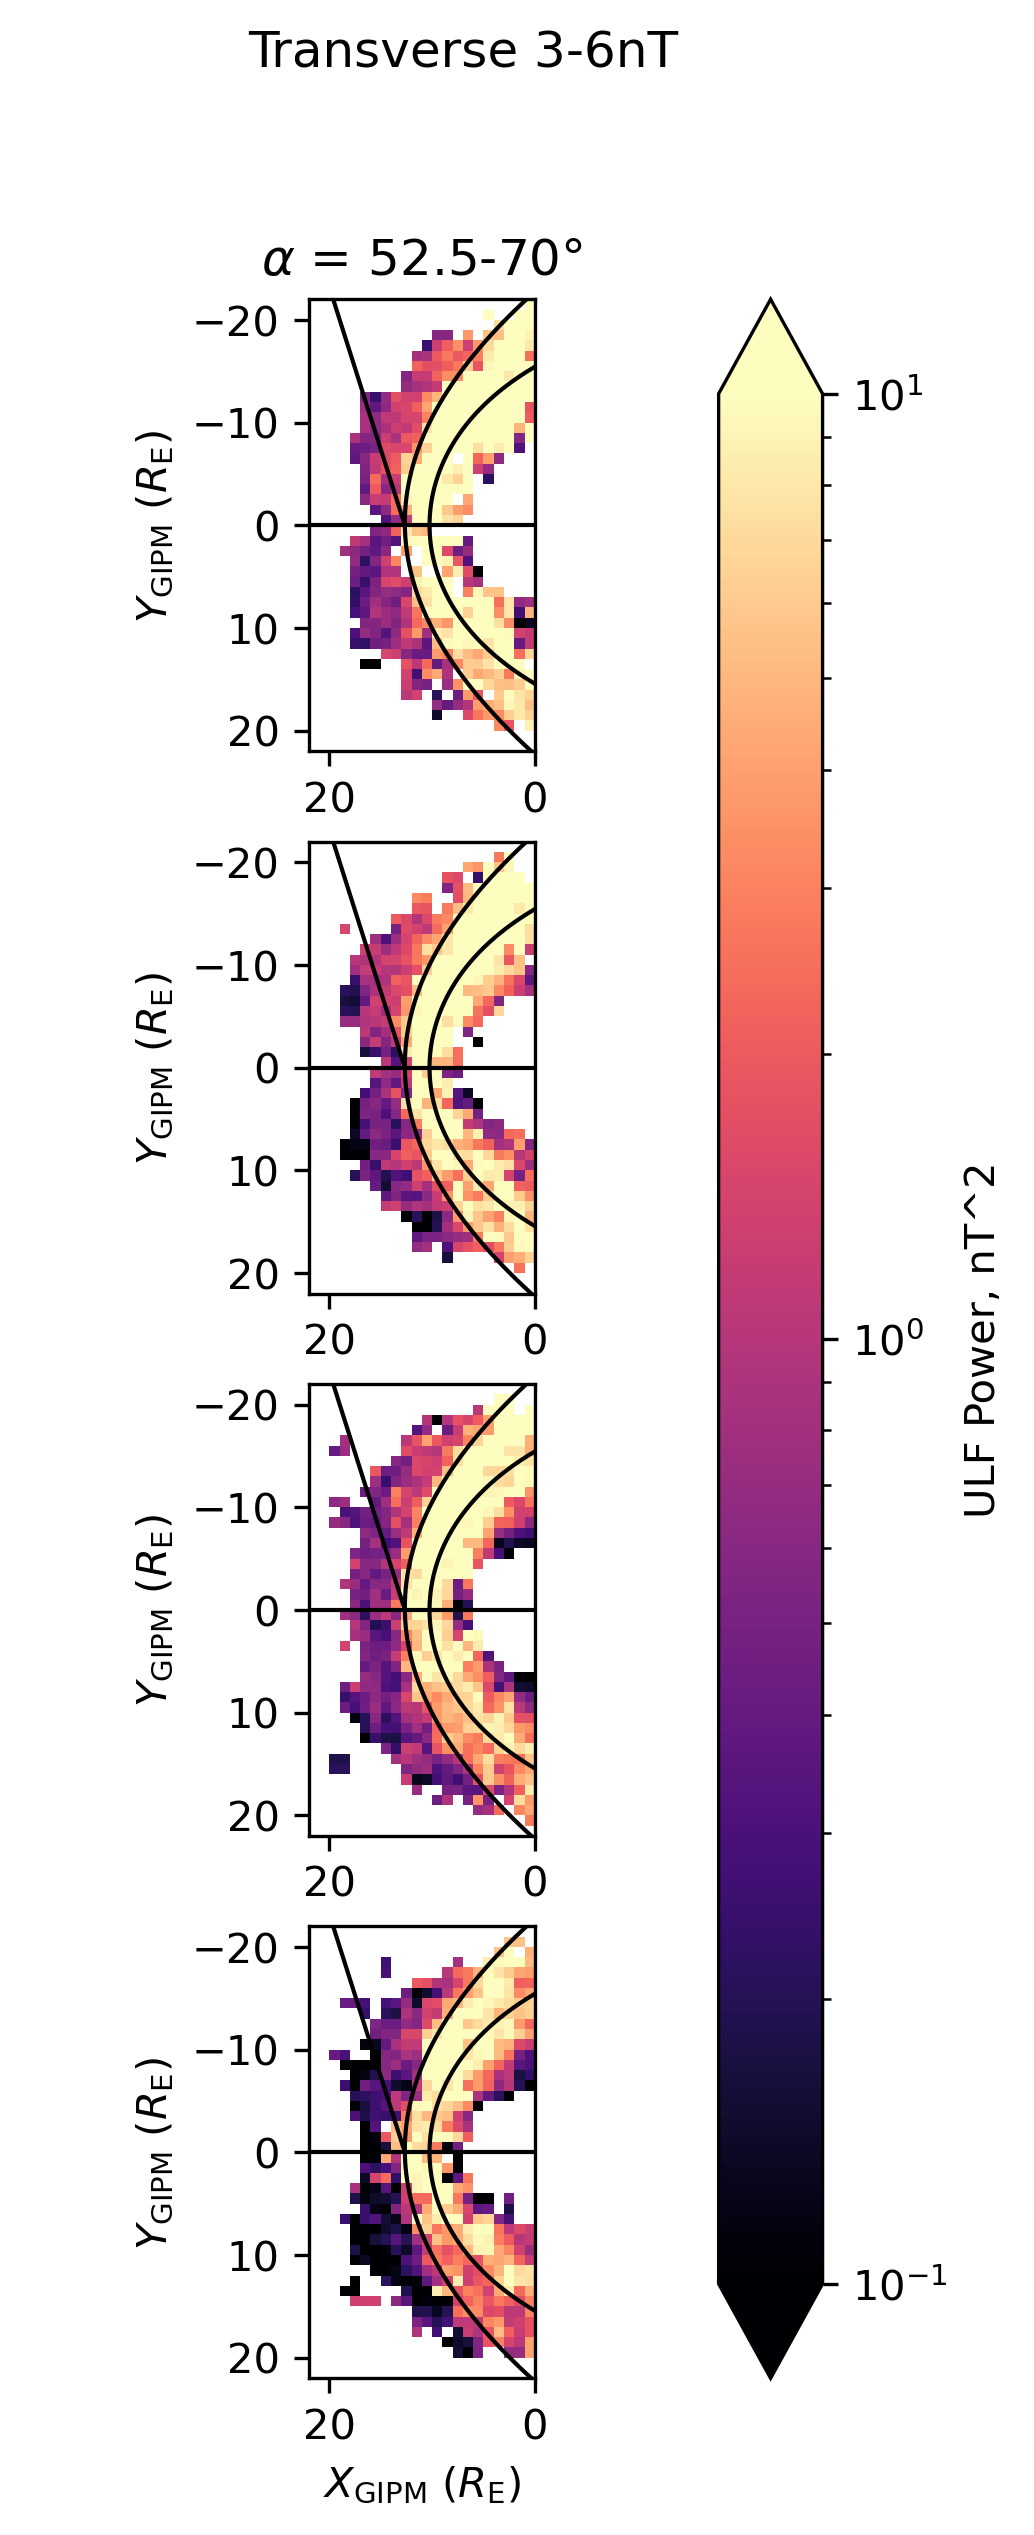

In [119]:
Velocity_Plots(perp_hists_52_70_3_6, 'Transverse', [3,6], [52.5,70])